# Schneider Electrics - Energy Consumption Forecast
https://www.drivendata.org/competitions/51/electricity-prediction-machine-learning/page/101/

**Goal:** forecast energy for given buildings based on builduings data and temperature records

**Structure of the Notebook**
1. EDA
2. Time Series Analysis with statsmodels package
    - 2.1 Correlation consumption vs temperature
    - 2.2 Autocorrelation analysis
        - stationarity test
        - ARIMA model fitting
        - Forecast
3. Time series analysis with LSTM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Set the size of all figures from matplotlib & statsmodels
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20, 10]
#mpl.rcParams

##  1. EDA of the datasets
https://www.drivendata.org/competitions/51/electricity-prediction-machine-learning/data/


### Metadata of the buidlings (metadata.csv)
- *SiteId*: ID of the building (range from 1 to 305 with missing values)
- *Binary columns*: xx_IsDayOff from monday to sunday (regular days-off of the building)
- *Numeric columns*: Surface, Sampling (number of minutes between each observation for this site), BaseTemperature (of the building in °C)

In [5]:
#Loading the file
metadata = pd.read_csv('metadata.csv')
metadata['Sampling'] = metadata['Sampling'].astype('category')
#Turning xxIsDayOff in dummy variables
for lab in metadata.iloc[:, 4:].columns:
    metadata[lab] = metadata[lab].map({False: 0, True:1})
#Total days-off per week as categorical type
metadata['Total_DaysOff'] = metadata.iloc[:, 4:].sum(axis=1)

print(metadata.head())
print(metadata.tail())
print(metadata.info())

   SiteId       Surface Sampling  BaseTemperature  MondayIsDayOff  \
0       1   1387.205119     15.0             18.0               0   
1       2   6098.278376     30.0             18.0               0   
2       3  10556.293605      5.0             18.0               0   
3       5  12541.181277     30.0             18.0               0   
4       6   9150.195373     30.0             18.0               0   

   TuesdayIsDayOff  WednesdayIsDayOff  ThursdayIsDayOff  FridayIsDayOff  \
0                0                  0                 0               0   
1                0                  0                 0               0   
2                0                  0                 0               0   
3                0                  0                 0               0   
4                0                  0                 0               0   

   SaturdayIsDayOff  SundayIsDayOff  Total_DaysOff  
0                 1               1              2  
1                 1         

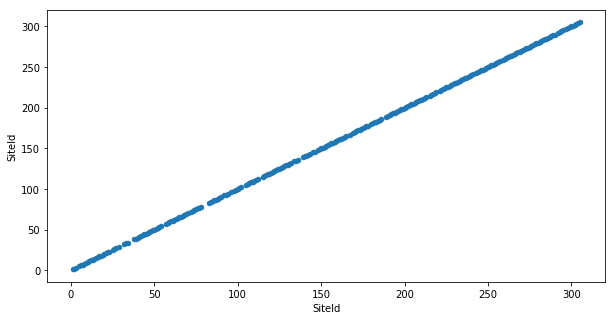

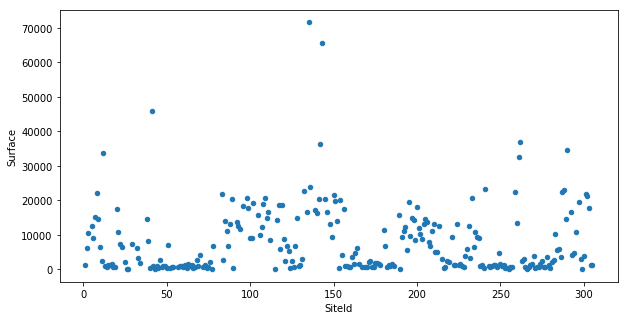

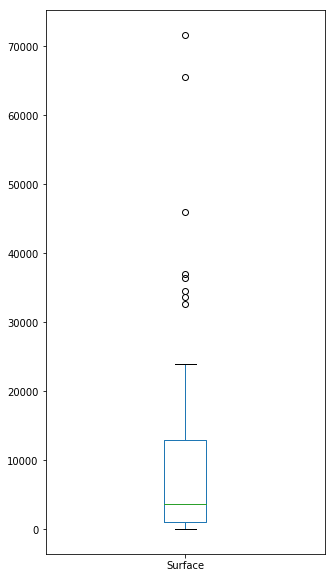

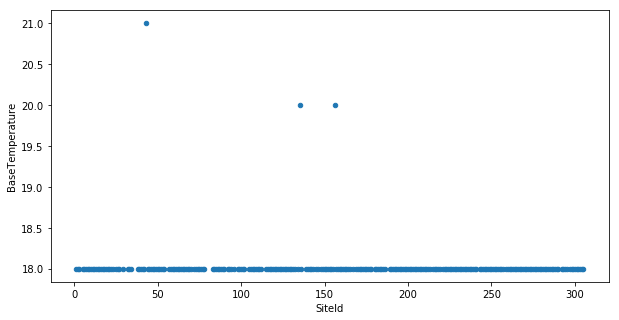

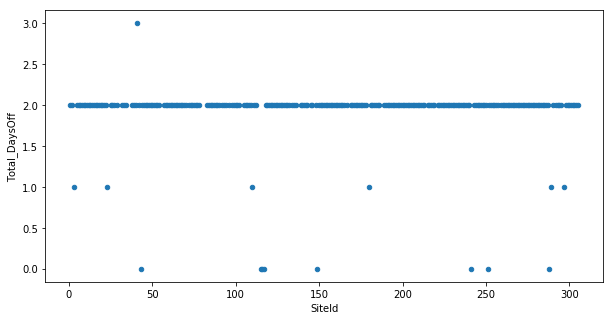

In [6]:
#Graphic visualizations of numerical values
_ = metadata.plot(kind='scatter', x='SiteId', y='SiteId', figsize=(10,5))
plt.show()

_ = metadata.plot(kind='scatter', x='SiteId', y='Surface', figsize=(10,5))
plt.show()

_ = metadata.plot(kind='box', y='Surface', figsize=(5,10))
plt.show()

_ = metadata.plot(kind='scatter', x='SiteId', y='BaseTemperature', figsize=(10,5))
plt.show()

_ = metadata.plot(kind='scatter', x='SiteId', y='Total_DaysOff', figsize=(10,5))
plt.show()


### Public Holidays (holidays.csv)
Public holidays at the sites included in the dataset, which may be helpful for identifying days where consumption may be lower than expected.

                 Date                              Holiday SiteId
Date                                                             
2016-01-01 2016-01-01                             New year      1
2016-01-18 2016-01-18  Birthday of Martin Luther King, Jr.      1
2016-02-15 2016-02-15                Washington's Birthday      1
2016-05-30 2016-05-30                         Memorial Day      1
2016-07-04 2016-07-04                     Independence Day      1
                 Date                       Holiday SiteId
Date                                                      
2015-08-15 2015-08-15  Assumption of Mary to Heaven    305
2015-11-01 2015-11-01                All Saints Day    305
2015-12-08 2015-12-08         Immaculate Conception    305
2015-12-25 2015-12-25                 Christmas Day    305
2015-12-26 2015-12-26              St Stephen's Day    305
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8387 entries, 2016-01-01 to 2015-12-26
Data columns (total 3 columns):
D

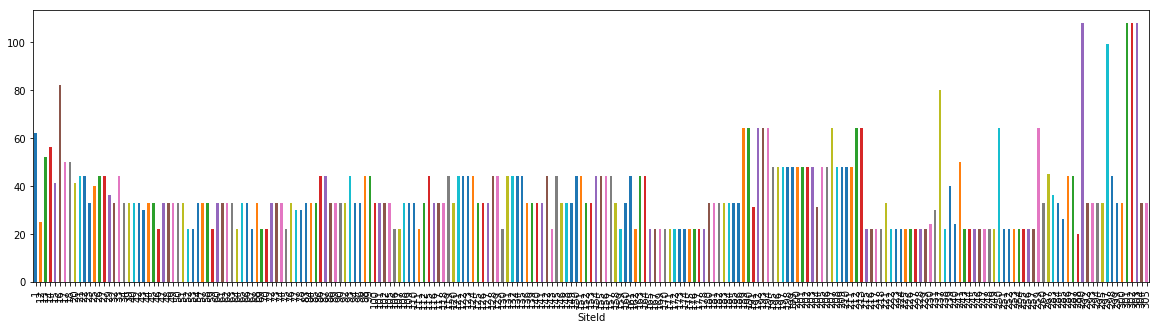

In [7]:
#Loading the file
holidays = pd.read_csv('holidays.csv', parse_dates=[1])
holidays.index = holidays['Date']
holidays = holidays.drop(['Unnamed: 0'], axis='columns')
holidays['SiteId'] = holidays['SiteId'].astype('category')
print(holidays.head())
print(holidays.tail())
print(holidays.info())

#Days off count per building
holidays_count = holidays.groupby('SiteId').count()

_ = holidays_count['Holiday'].plot(kind='bar', figsize=(20, 5))
plt.show()

### Historical Consumption - Training set (train.csv)


- *obs_id*: Arbitrary ID for the observation
- *SiteId*: ID number for the building that matches across datasets
- *ForecastId*: ID for a timeseries that is part of a forecast (can be matched with the submission file)
- *Timestamp*: The time of the measurement
- *Value*: A measure of consumption for that building


In [8]:
#Loading the file
training = pd.read_csv('train.csv', parse_dates=[2])
training.index = training['Timestamp']
#training = training.drop(['Timestamp'], axis=1)
training['SiteId'] = training['SiteId'].astype('category')

print(training.head())
print(training.tail())
print(training.info())

print("\n Buildings in the set: {}\n".format(len(training['SiteId'].unique().tolist())), 
      training['SiteId'].unique().tolist())

             obs_id SiteId  Timestamp  ForecastId         Value
Timestamp                                                      
2014-09-03   744519      1 2014-09-03           1  9.096555e+05
2014-09-04  7627564      1 2014-09-04           1  1.748273e+06
2014-09-05  7034705      1 2014-09-05           1           NaN
2014-09-06  5995486      1 2014-09-06           1           NaN
2014-09-07  7326510      1 2014-09-07           1           NaN
                      obs_id SiteId           Timestamp  ForecastId  \
Timestamp                                                             
2015-11-19 11:30:00  2344172    305 2015-11-19 11:30:00        6974   
2015-11-19 11:45:00  5113853    305 2015-11-19 11:45:00        6974   
2015-11-19 12:00:00  5227641    305 2015-11-19 12:00:00        6974   
2015-11-19 12:15:00  3750622    305 2015-11-19 12:15:00        6974   
2015-11-19 12:30:00  2559139    305 2015-11-19 12:30:00        6974   

                           Value  
Timestamp          

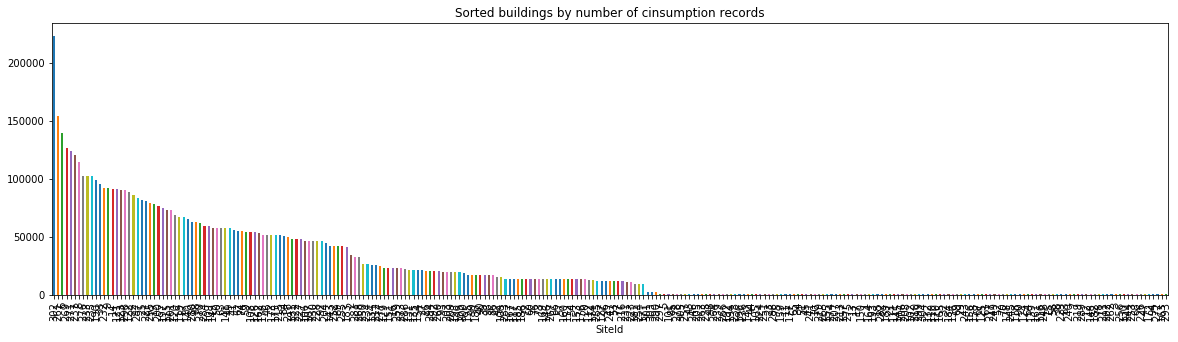

SiteId
302    223620
261    154219
6      139716
269    126370
271    124407
237    120432
8      114962
276    102359
233    102255
235    102187
190     98998
33      95782
232     92116
9       91926
14      91676
121     91112
123     90850
298     90188
122     89031
22      86349
Name: Value, dtype: int64


In [10]:
#Count number of records per site to pick up the biggest one for machine learning
records_count = training.groupby('SiteId').count()['Value'].sort_values(ascending=False)

_ = records_count.plot(kind='bar', figsize=(20,5))
_ = plt.title('Sorted buildings by number of consumption records')
plt.show()

print(records_count.head(20))

*SiteId = 162 has 53 687 records, enough to train a ML model for this building only as a start*

Percentage of NaN values in the 'Value' column:  0.01320171406880971


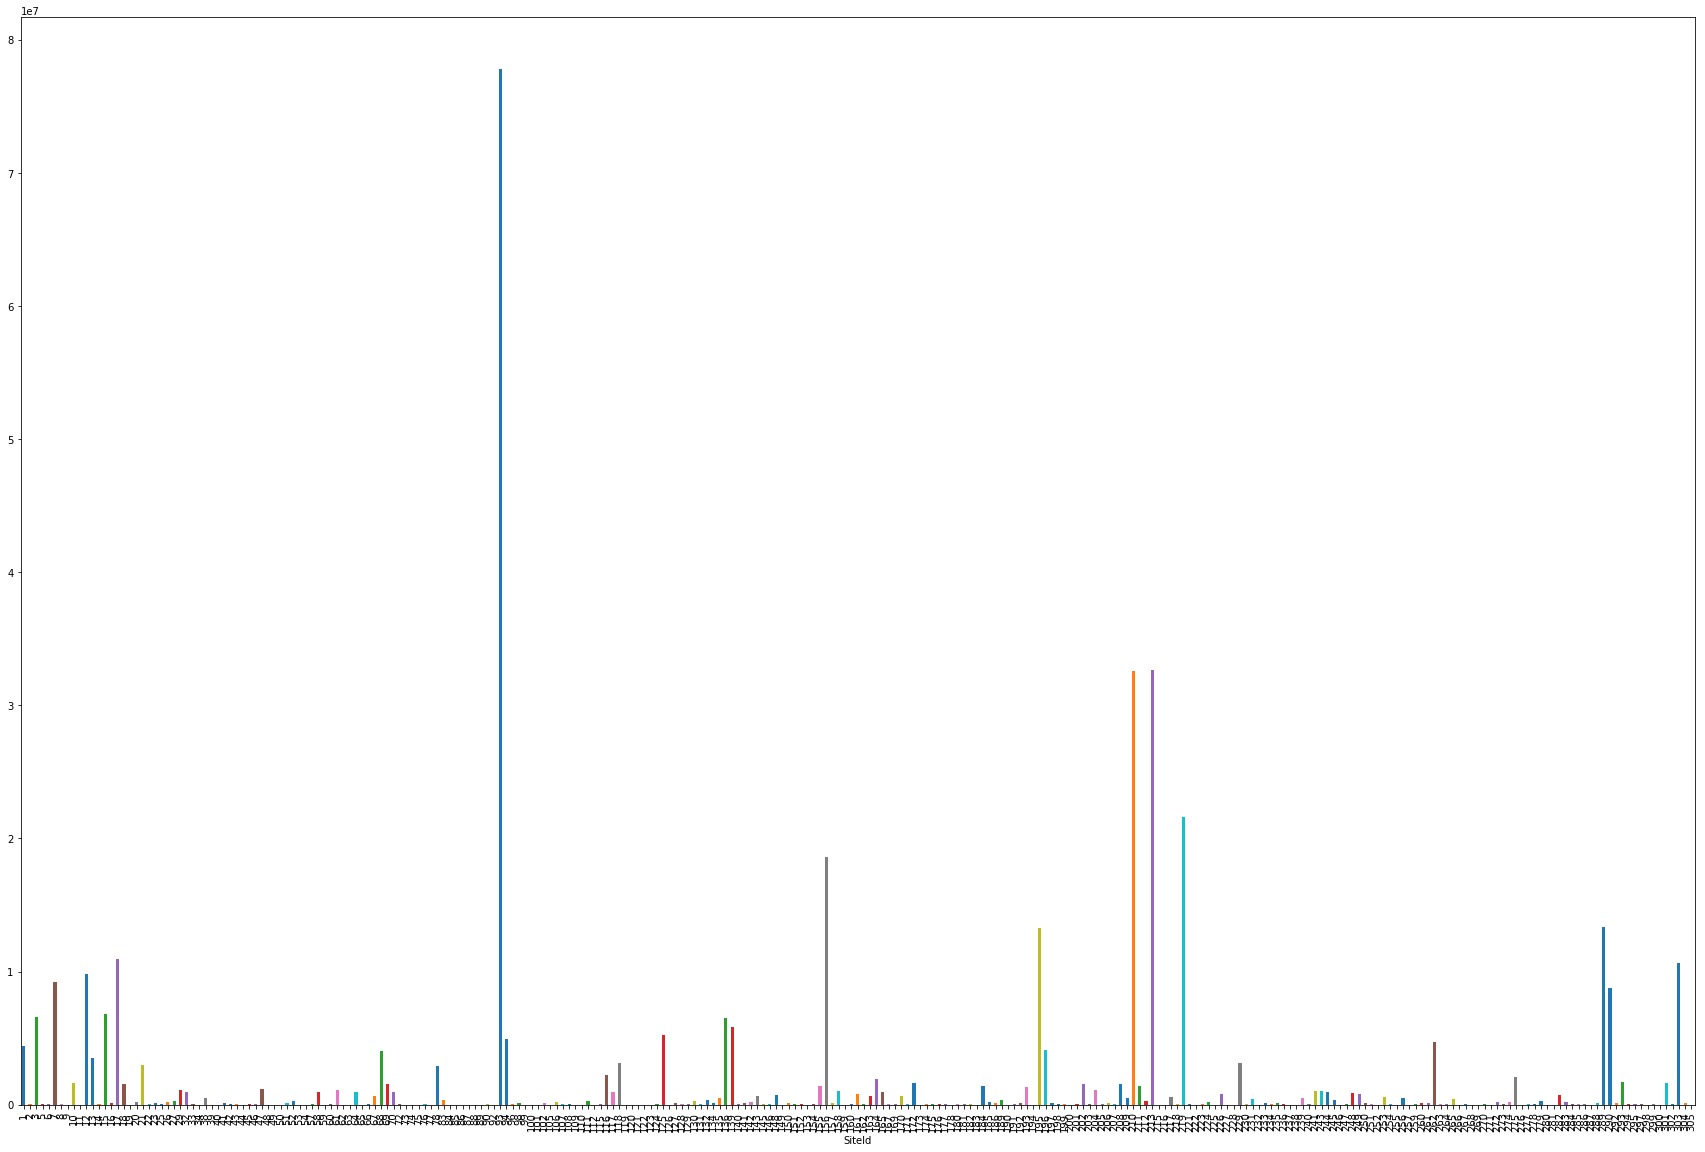

In [11]:
#NaN values = 1.3% of the "Value" column
print("Percentage of NaN values in the 'Value' column: ",
      len(training[training['Value'].isnull()]) / len(training))

#Visualization of means for each building
site_means = training.groupby('SiteId')['Value'].mean()
_ = site_means.plot(kind='bar', figsize=(30,20))
plt.show()

                   Value  Timestamp week_day month
Timestamp                                         
2014-09-03  9.096555e+05 2014-09-03        2     9
2014-09-04  1.748273e+06 2014-09-04        3     9
2014-09-05           NaN 2014-09-05        4     9
2014-09-06           NaN 2014-09-06        5     9
2014-09-07           NaN 2014-09-07        6     9
2014-09-08  1.964878e+06 2014-09-08        0     9
2014-09-09  3.266904e+06 2014-09-09        1     9
2014-09-10  2.926094e+06 2014-09-10        2     9
2014-09-11  1.720502e+06 2014-09-11        3     9
2014-09-12  1.136248e+06 2014-09-12        4     9


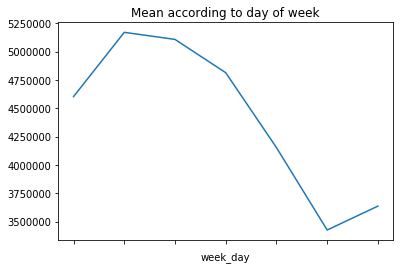

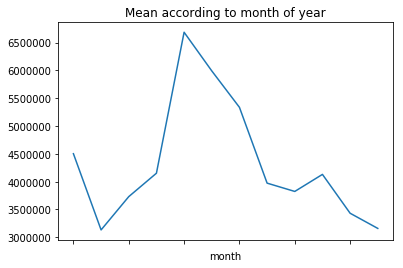

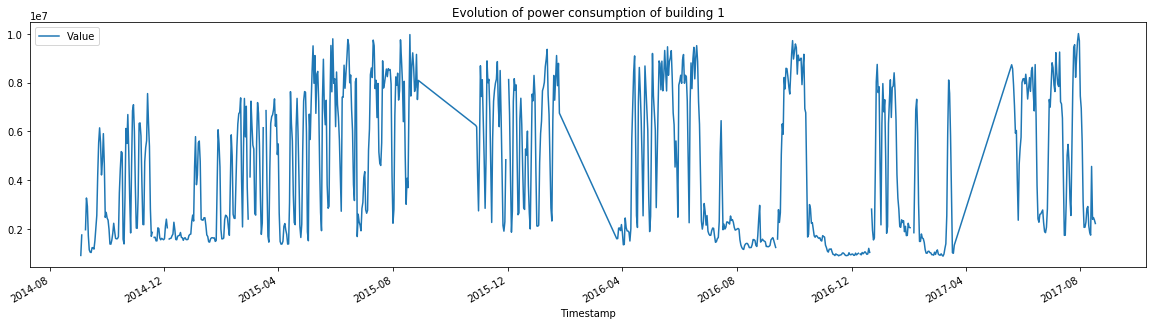

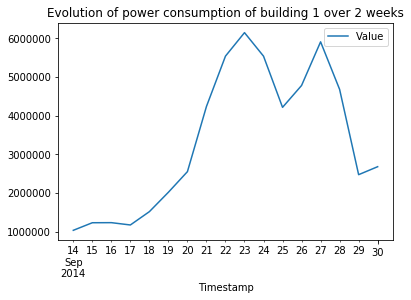

In [17]:
#Evolution of power consumption for 1 building
siteid = 1
one_building = training[training['SiteId'] == siteid][['Value', 'Timestamp']]
one_building['week_day'] = one_building['Timestamp'].dt.dayofweek.astype('category')
one_building['month'] = one_building['Timestamp'].dt.month.astype('category')
#one_building['day_year'] = one_building['Timestamp'].dt.dayofyear.astype('category')
print(one_building.head(10))

#Mean according to day in the week
day_mean = one_building.groupby('week_day')['Value'].mean()
#print("Mean according to week_day: ", day_mean)
_ = day_mean.plot()
_ = plt.title('Mean according to day of week')
plt.show()

#Mean according to month of the year
month_mean = one_building.groupby('month')['Value'].mean()
#print("Mean according to month of year: ", month_mean)
_ = month_mean.plot()
_ = plt.title('Mean according to month of year')
plt.show()

#Power evolution
_ = one_building.plot(y='Value', figsize=(20,5))
_ = plt.title('Evolution of power consumption of building {}'.format(siteid))
plt.show()

#Days-off for the SiteID 1 are Saturday and sunday
_ = one_building['2014-09-14' : '2014-09-30'].plot(y='Value')
_ = plt.title('Evolution of power consumption of building {} over 2 weeks'.format(siteid))
plt.show()

- *For a buidling, the consumption seems to be higher in May-June-july (air conditionning ?)*
- *The power consumption substantially drops during days-off of the building*

### Weather data (weather.csv)
temperature data from several stations near each site. For each site several temperature measurements were retrieved from stations in a radius of 30 km if available

In [12]:
weather = pd.read_csv('weather.csv', index_col=0, parse_dates=[1])
weather.index = weather['Timestamp']
weather = weather.drop(['Timestamp'], axis=1)
weather['SiteId'] = weather['SiteId'].astype('category')

print(weather.head(50))
print(weather.info())

print("\nNumber of site that have temeprature records available: {}\n".format(len(weather['SiteId'].unique().tolist())),
     weather['SiteId'].unique().tolist())

C:\Users\Damien\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                     Temperature   Distance SiteId
Timestamp                                         
2013-12-31 19:00:00         -7.2  24.889929      1
2013-12-31 19:00:00         -8.3  23.303097      1
2013-12-31 19:00:00         -7.8  20.952256      1
2013-12-31 19:00:00         -8.0  20.952256      1
2013-12-31 19:34:00         -8.1  16.610602      1
2013-12-31 19:55:00         -8.2  16.610602      1
2013-12-31 20:00:00         -7.8  24.889929      1
2013-12-31 20:00:00         -8.0  20.952256      1
2013-12-31 20:15:00         -8.3  16.610602      1
2013-12-31 20:35:00         -8.5  16.610602      1
2013-12-31 20:54:00         -8.4  16.610602      1
2013-12-31 21:00:00         -8.1  24.889929      1
2013-12-31 21:00:00         -8.0  20.952256      1
2013-12-31 21:15:00         -8.3  16.610602      1
2013-12-31 21:35:00         -8.3  16.610602      1
2013-12-31 21:55:00         -8.5  16.610602      1
2013-12-31 22:00:00         -8.0  24.889929      1
2013-12-31 22:00:00         -8.

***--> 247 building IDs vs 267 in the training set: sites have no temperature records available & there a temeprature records for building with no energy measurements !***

<Figure size 2160x720 with 0 Axes>

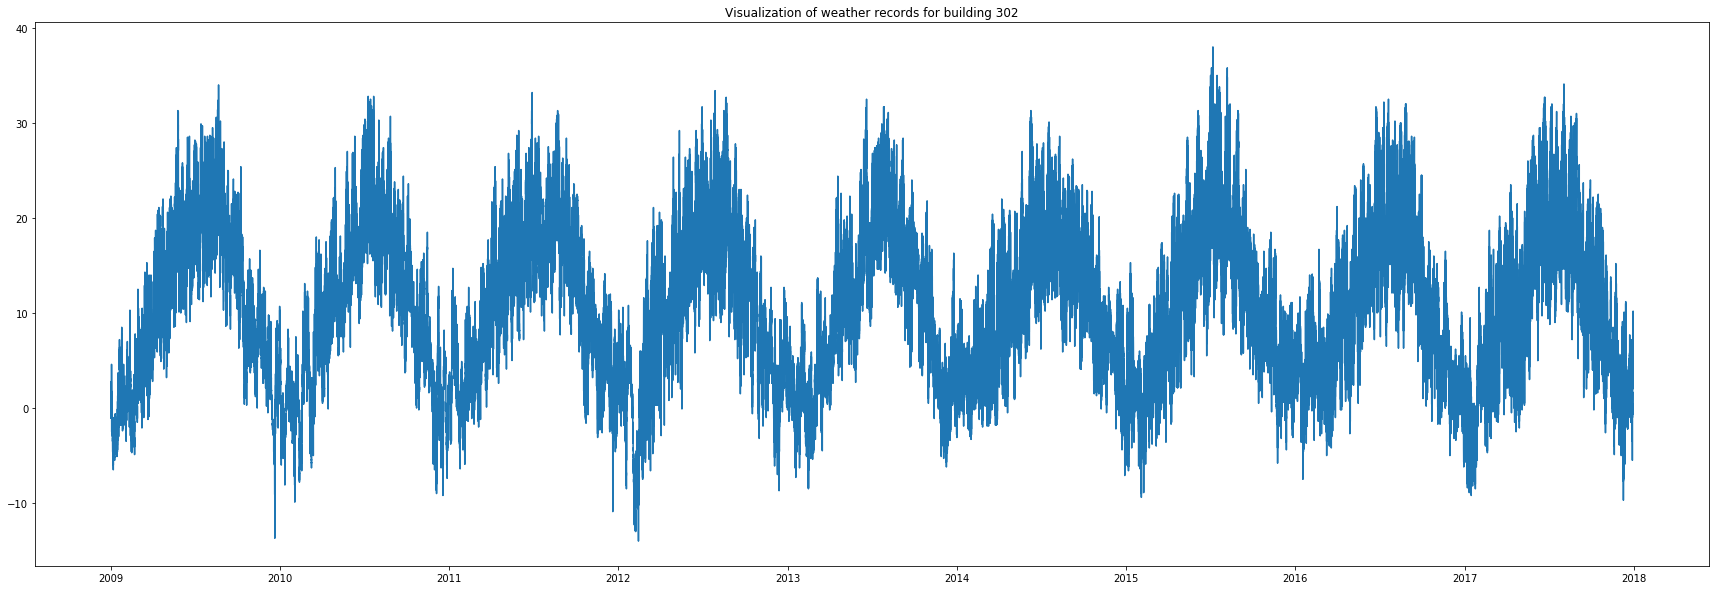

In [13]:
#Visualize the records for 1 site
siteid = 302
_ = plt.figure(figsize=(30,10))
_ = plt.plot(weather[weather['SiteId'] == siteid]['Temperature'])
_ = plt.title('Visualization of weather records for building {}'.format(siteid))
plt.show()

        Temperature
SiteId             
1          9.791213
2         15.687259
3         15.687259
4         11.762090
5         15.687259
6         15.687259
7         15.757237
8         11.762090
9         11.761654
10        11.762090
12        14.849709
13        14.491488
16        23.179443
17        22.547170
18        22.547170
19        11.796748
20        15.938711
21        12.428298
22        15.694554
23        13.948289


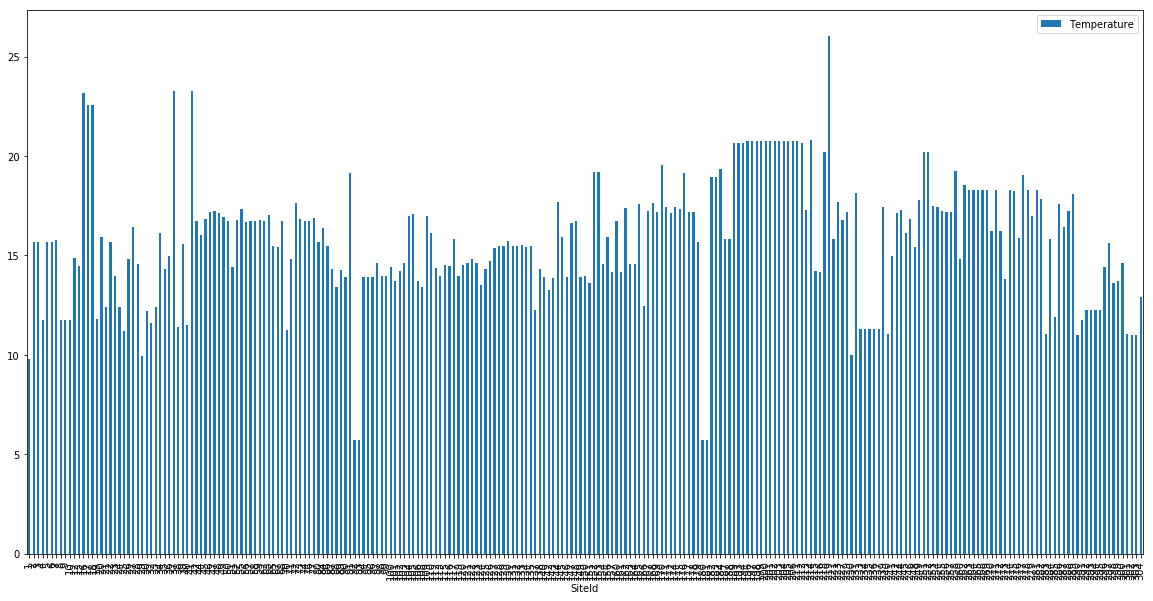

In [20]:
#Temperature means per site
mean_t_sites = weather.drop(columns=['Distance'])
mean_t_sites = mean_t_sites.groupby('SiteId').mean()
print(mean_t_sites.head(20))

#Visualization
_ = mean_t_sites.plot(kind='bar', figsize=(20,10))
plt.show()

*--> Highly depends on the number of temperature records !*

*--> No assumption that all the buildings are in the same city*

*--> Tertiary or industrial buidlings (Not residential buildings)*

---

## 2. Time Series Analysis
For buildings 6 & 269 (with a huge amount of data and only ones with temperature records within [302, 6, 261, 269, 271] , analyse of :
- The correlation between consumption and outdoor temperature
- The autocorrelation (ARIMA model)

In [11]:
#Function that gets the time series for a given building from the initial train set
def get_timeseries(SiteId, step=None):
    """For a given SiteId, the function gets the time series of the consumption value from the original training set
    and of the corresponding temperature records after proper resampling"""


    #Load the energy consumption values of the building
    train = pd.read_csv('train.csv', parse_dates=[2], index_col=2)
    train['Value'] = train['Value'].astype(float)
    train.index = pd.to_datetime(train.index)
    #print(train.head())
    #print(train.info())
    building_consumptions = train.loc[train['SiteId'] == SiteId]['Value']
    print("Consumptions series head: \n", building_consumptions.head())
    print("Number of NaN in the building {} consumption series: ".format(SiteId), 
          building_consumptions.isnull().sum())
    
    
    #Load the temperature records and resample
    weather = pd.read_csv('weather.csv', index_col=1, parse_dates=[1])
    building_weather = weather.loc[weather['SiteId'] == SiteId]['Temperature']
    if step is not None:
        building_weather = building_weather.resample(step).mean().interpolate('linear')
        
    print("Temperature series head: \n", building_weather.head())
    print("Number of NaN in the building {} temperature series: ".format(SiteId), 
      building_weather.isnull().sum())
    
    
    #vizualize the raw time series
    _ = building_consumptions.plot(figsize=(20,10), 
                                   title="Evolution of the energy consumption for building {}".format(SiteId))
    plt.show()
    _ = building_weather.plot(figsize=(20,10), title="Evolution of the temperature for building {}".format(SiteId))
    plt.show()
    
    return building_consumptions, building_weather

Consumptions series head: 
 Timestamp
2013-01-01 01:00:00    25108.373290
2013-01-01 01:15:00    25062.047878
2013-01-01 01:30:00    25015.722466
2013-01-01 01:45:00    24969.397055
2013-01-01 02:00:00    24923.071643
Name: Value, dtype: float64
Number of NaN in the building 6 consumption series:  1028
Temperature series head: 
 Timestamp
2013-01-01 13:00:00    21.8500
2013-01-01 13:15:00    21.8875
2013-01-01 13:30:00    21.9250
2013-01-01 13:45:00    21.9625
2013-01-01 14:00:00    22.0000
Freq: 15T, Name: Temperature, dtype: float64
Number of NaN in the building 6 temperature series:  0


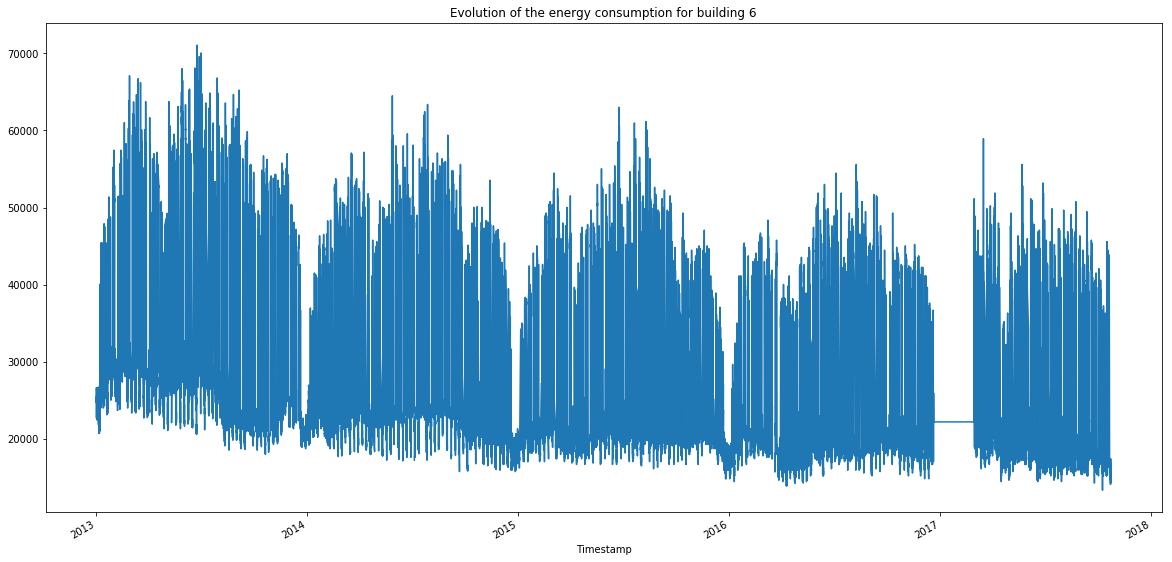

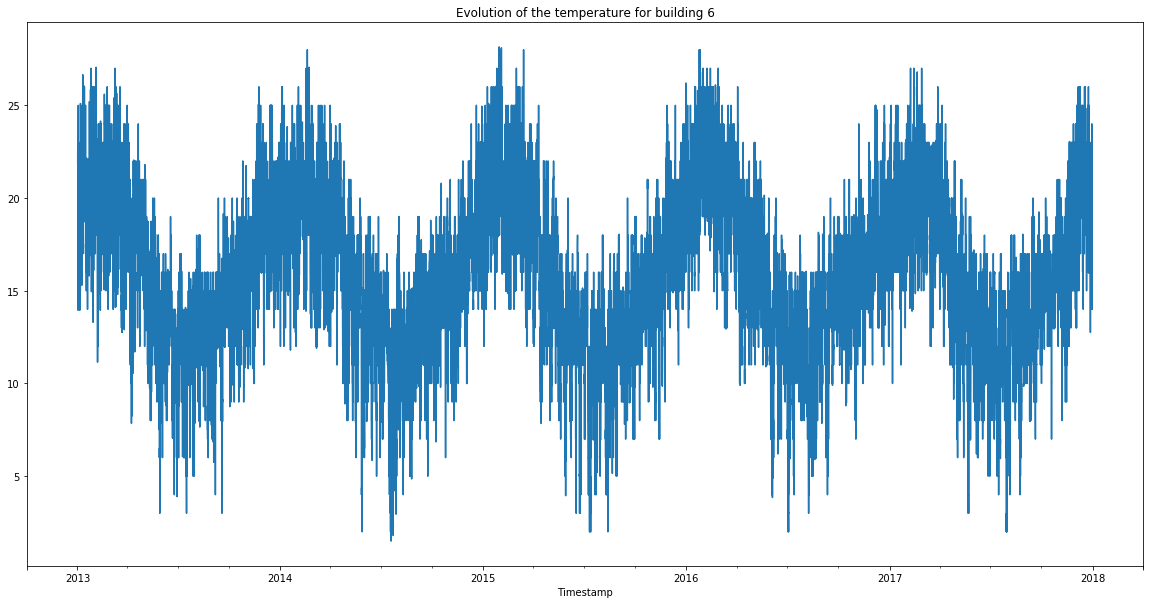

In [49]:
#Get timeseries for building ID=6
consumptions_6, temperatures_6 = get_timeseries(6, '15T')

*The seasonality of the 2 time series is apparent when visualizing them (non-stationary)*

Consumptions series head: 
 Timestamp
2013-05-30 09:15:00    20641.958202
2013-05-30 09:30:00    18606.632254
2013-05-30 09:45:00    18245.758858
2013-05-30 10:00:00    17110.210575
2013-05-30 10:15:00    16114.200004
Name: Value, dtype: float64
Number of NaN in the building 269 consumption series:  878
Temperature series head: 
 Timestamp
2013-01-01 02:15:00    11.0
2013-01-01 02:30:00    11.0
2013-01-01 02:45:00    11.0
2013-01-01 03:00:00    11.0
2013-01-01 03:15:00    11.0
Freq: 15T, Name: Temperature, dtype: float64
Number of NaN in the building 269 temperature series:  0


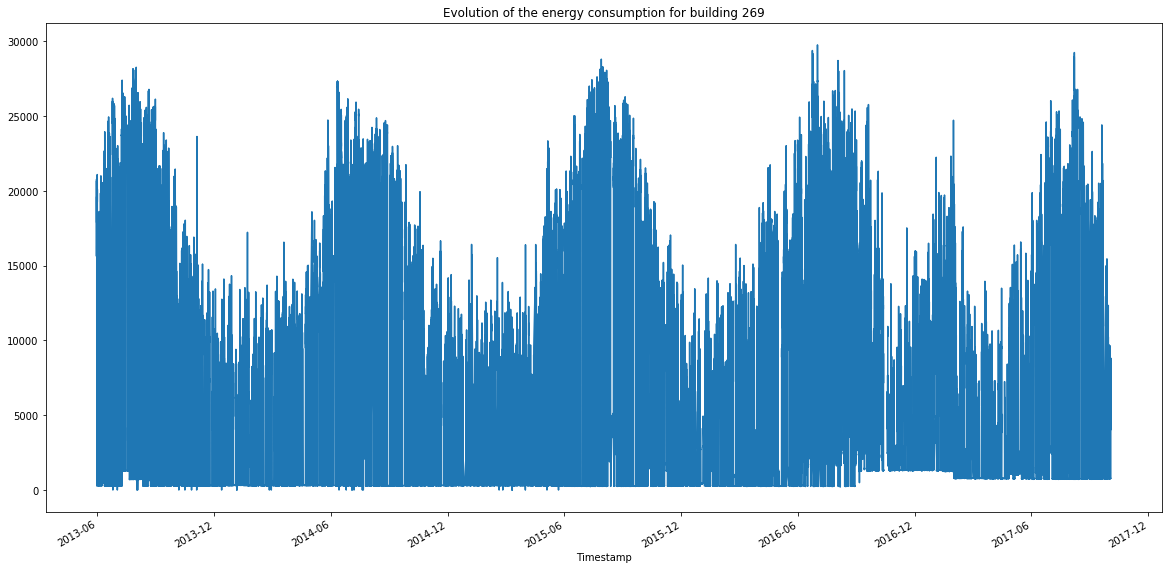

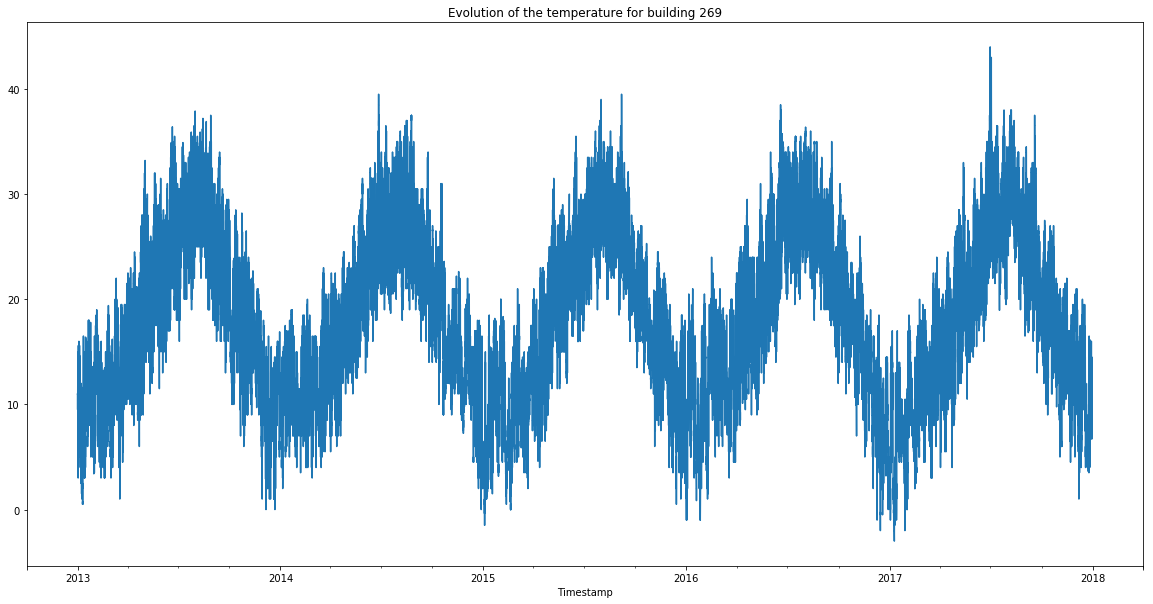

In [12]:
#Get timeseries for building ID=269
consumptions_269, temperatures_269 = get_timeseries(269, '15T')

### 2.1 Correlation between energy consumption & temperature
#### Building 6

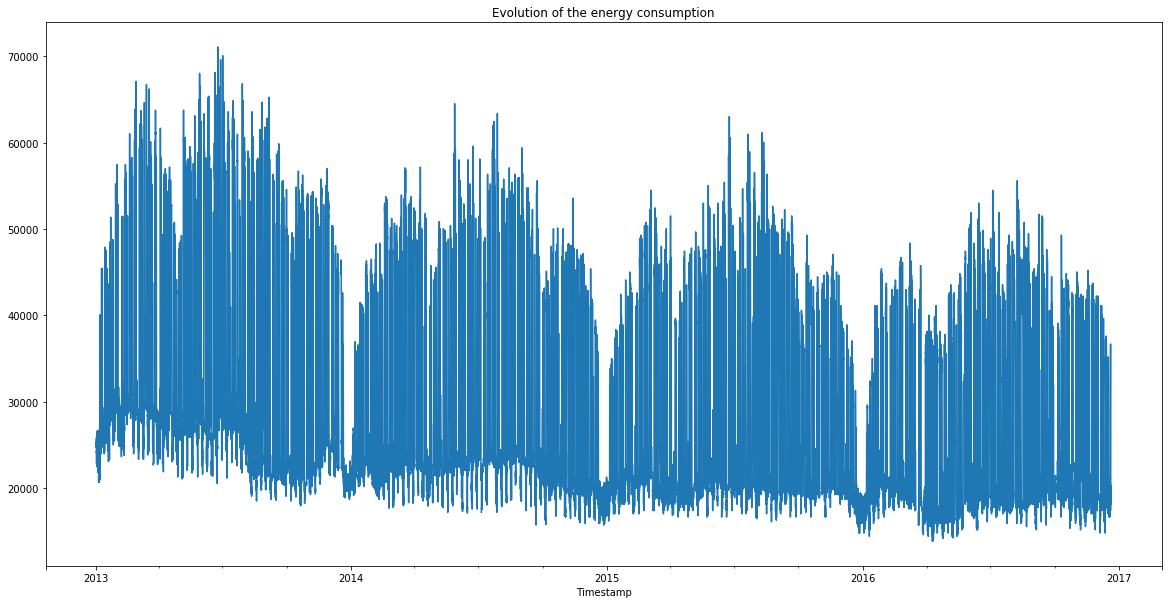

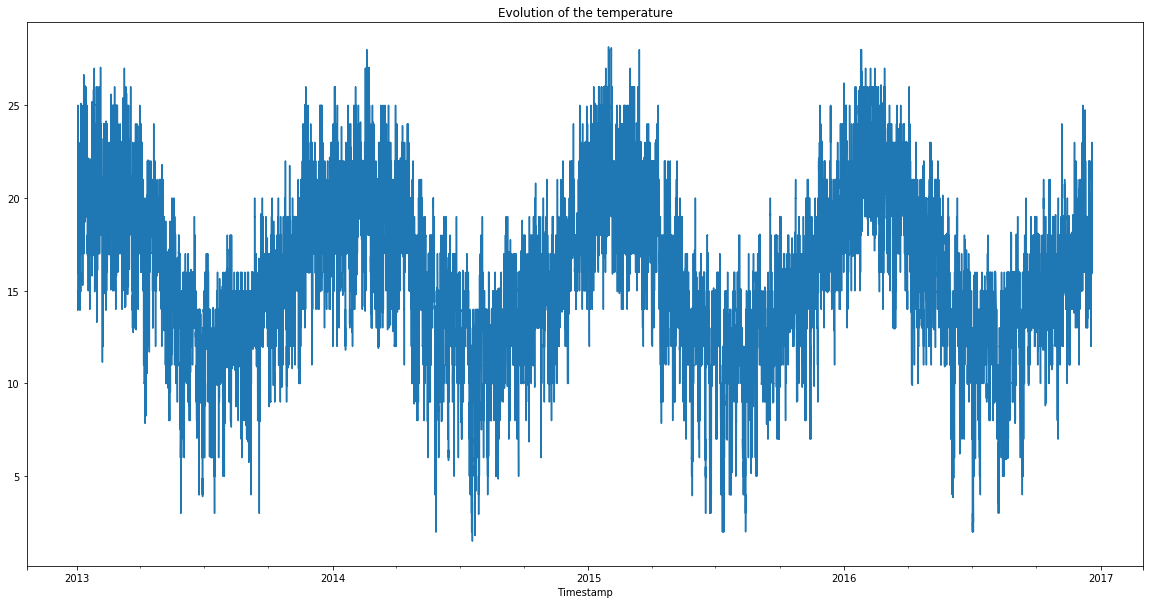

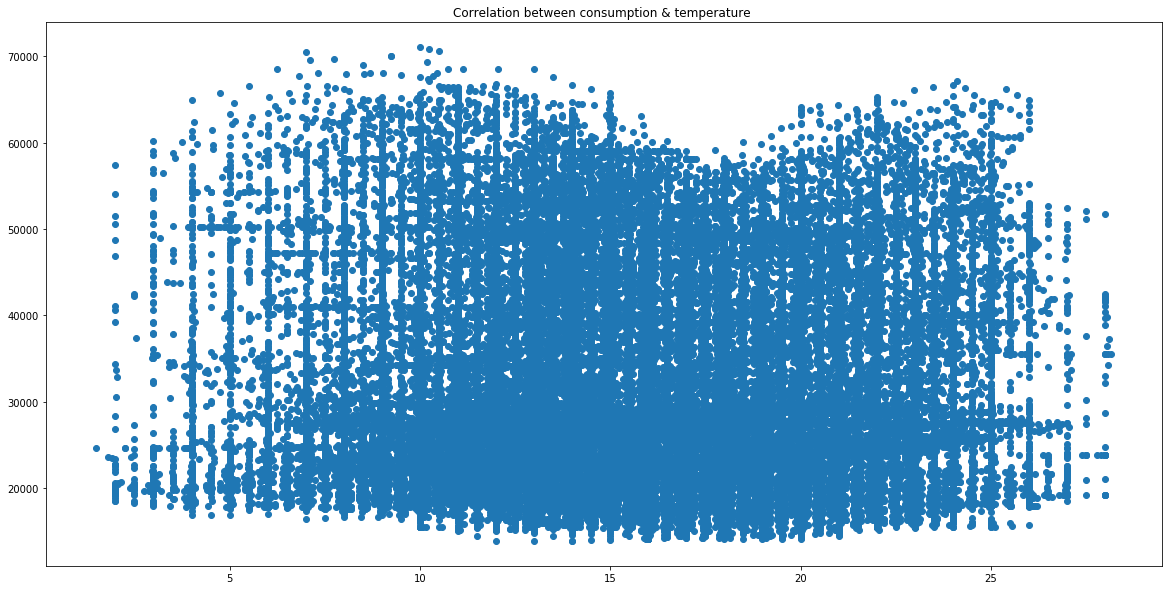

Mean values: Energy = 28401.287106620686, Temperature = 15.643977265097506
                     Temperature         Value  Value_Return  \
Timestamp                                                      
2013-01-02 00:15:00         15.0  25177.861408     -0.000919   
2013-01-02 00:30:00         15.0  25154.698702     -0.000920   
2013-01-02 00:45:00         15.0  25177.861408      0.000921   
2013-01-02 01:00:00         15.0  25201.024114      0.000920   
2013-01-02 01:15:00         15.0  24946.234349     -0.010110   

                     Temperature_Return  Value_Diff  Temperature_Diff  
Timestamp                                                              
2013-01-02 00:15:00                 0.0  -23.162706               0.0  
2013-01-02 00:30:00                 0.0  -23.162706               0.0  
2013-01-02 00:45:00                 0.0   23.162706               0.0  
2013-01-02 01:00:00                 0.0   23.162706               0.0  
2013-01-02 01:15:00                 0.0 -254

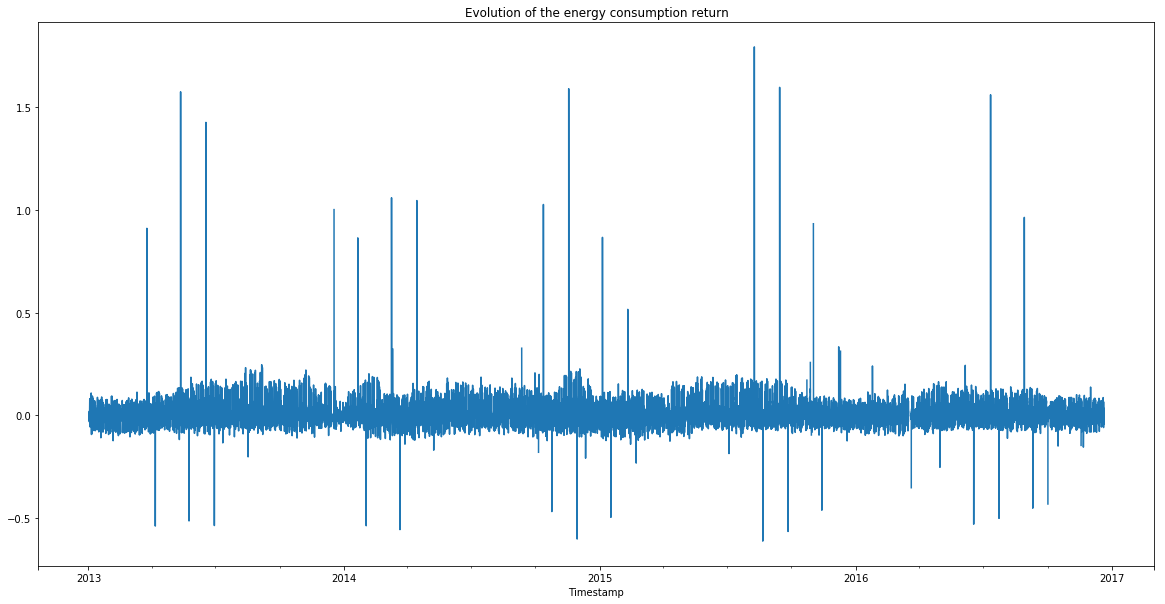

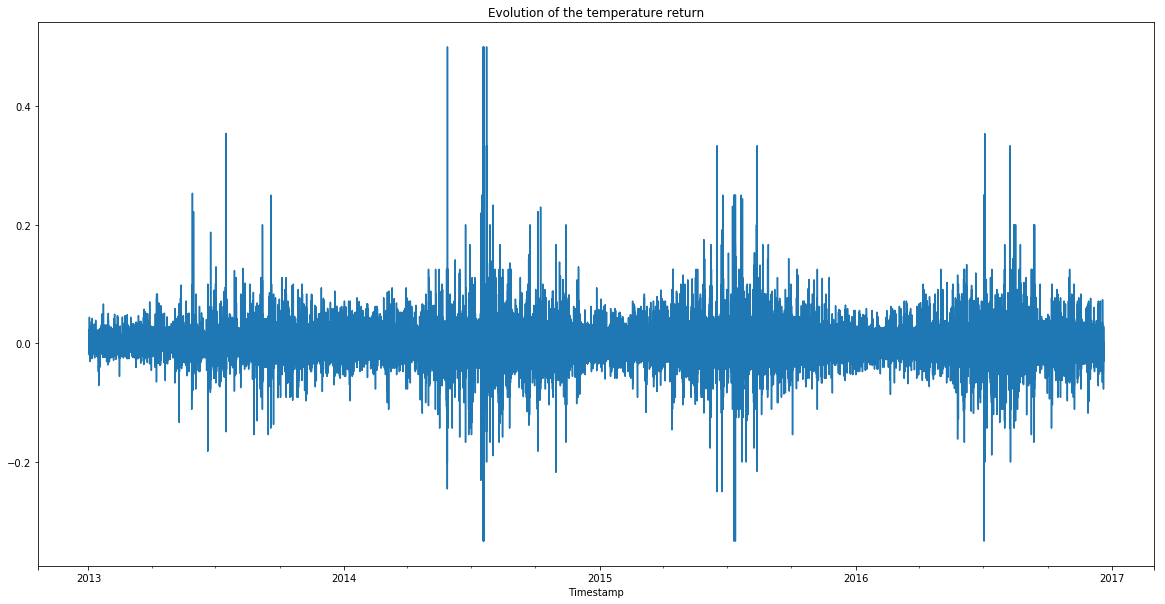

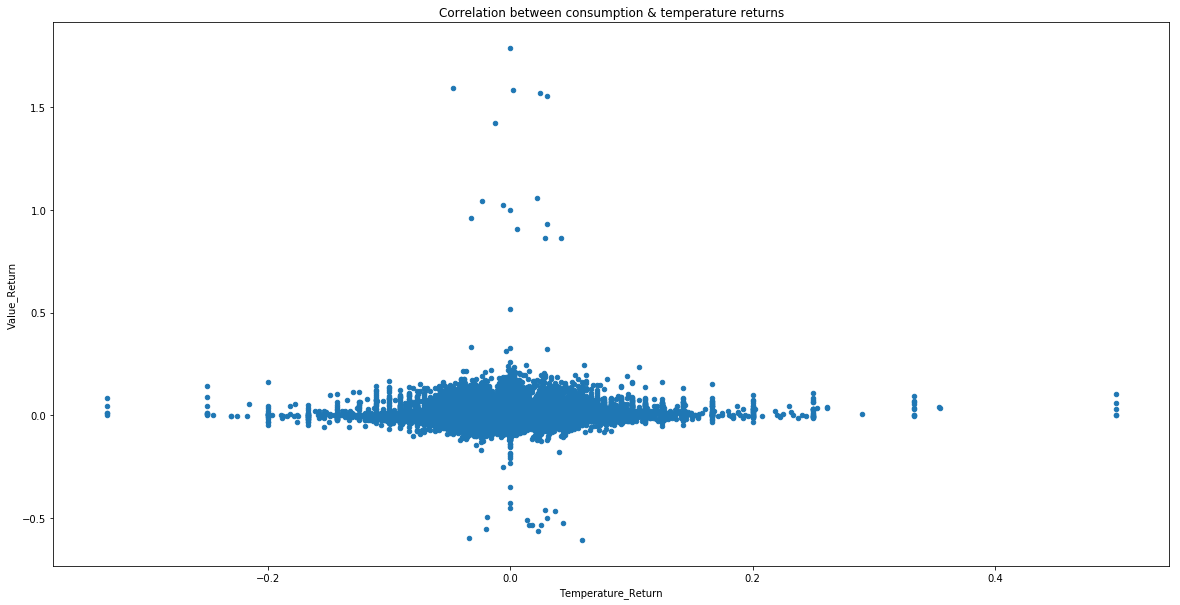

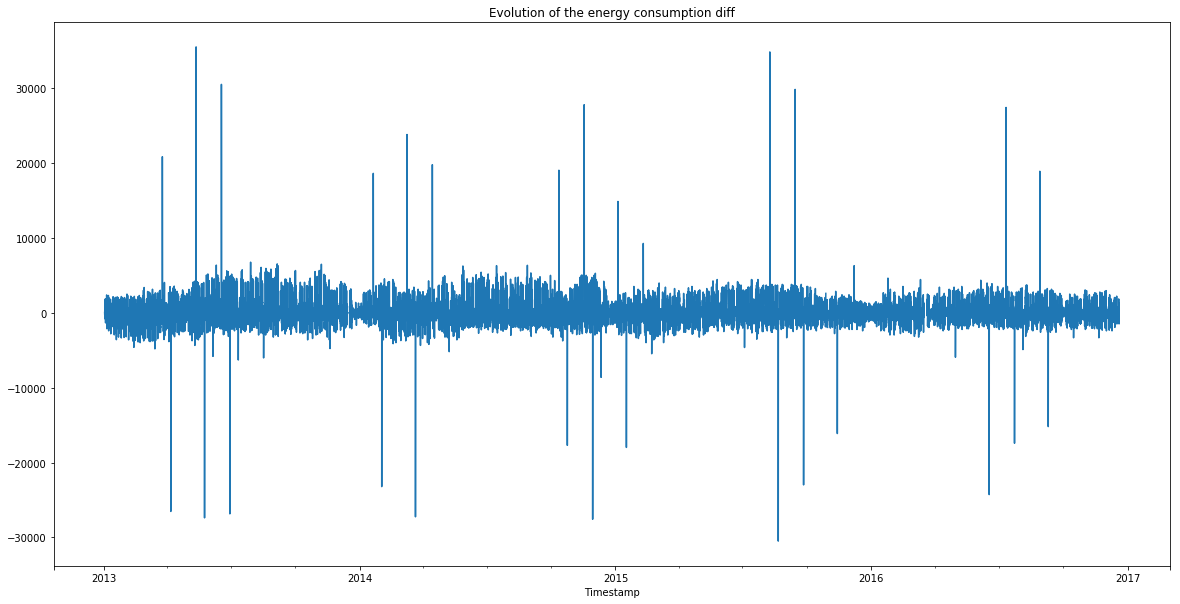

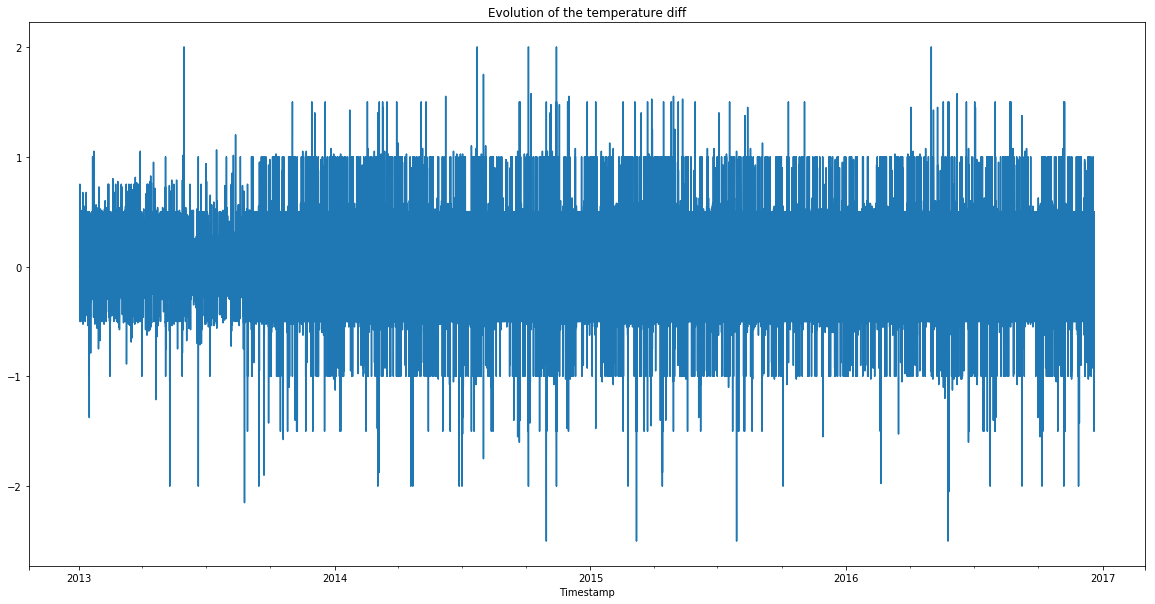

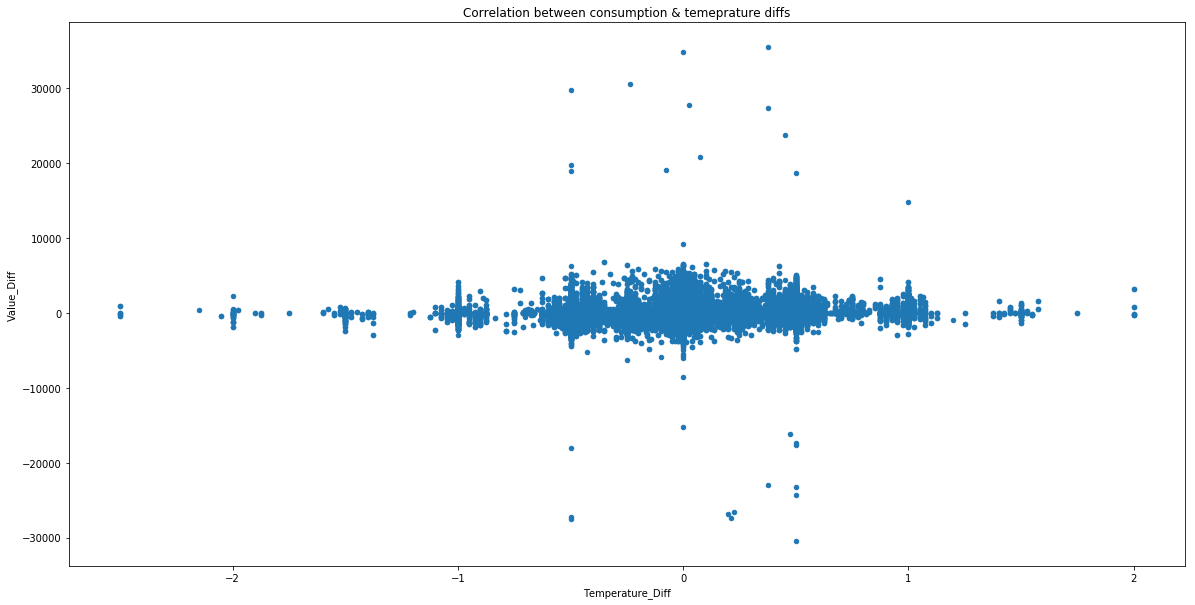

Correlations values for the variables, their returns and their diffs: 
 0.026558995265724604 0.06458486291650684 0.09102443156281974


In [88]:
#Get only the time series from the begining until the date where there are missing values

#len(consumptions_6)
#print(consumptions.head(), consumptions.tail())
#print(consumptions['2016-12-20 07:00:00':'2016-12-20 08:00:00'])

#Take the time series from 2013-01-02 until the 2016-12-19 not included to avoid constant values
consumptions_sliced = consumptions_6['2013-01-02':'2016-12-19']
#print(len(consumptions_sliced))
#print(consumptions_sliced.head(10), print(consumptions_sliced.tail(10)))
temperatures_sliced = temperatures_6['2013-01-02':'2016-12-19']
#print(len(temperatures_sliced))
#print(temperatures_sliced.head(10), temperatures_sliced.tail(10))

#Reindex the consmption series as there are missing values (length inferior to temepratures)
consumptions_sliced = consumptions_sliced.reindex(temperatures_sliced.index, method='nearest')
#print(len(consumptions_sliced))

#Plotting for visual check
_ = consumptions_sliced.plot(figsize=(20,10), title="Evolution of the energy consumption")
plt.show()
_ = temperatures_sliced.plot(figsize=(20,10), title="Evolution of the temperature")
plt.show()

_ = plt.figure(figsize=(20,10))
_ = plt.title("Correlation between consumption & temperature ")
_ = plt.scatter(x=temperatures_sliced, y=consumptions_sliced)
plt.show()

#Print the mean values of the time series
print("Mean values: Energy = {}, Temperature = {}".format(consumptions_sliced.mean(), temperatures_sliced.mean()))

#Get the returns of the consumption and temperature
timeseries = pd.DataFrame({'Value':consumptions_sliced, 'Temperature': temperatures_sliced})
timeseries['Value_Return'] = timeseries['Value'].pct_change()
timeseries['Temperature_Return'] = timeseries['Temperature'].pct_change()

#Get the diff(1)
timeseries['Value_Diff'] = timeseries['Value'].diff()
timeseries['Temperature_Diff'] = timeseries['Temperature'].diff()

#Remove first row with NaN values after pct_change() and diff()
timeseries = timeseries.iloc[1:, :]

#Save the dataframe containing the timeseries
timeseries.to_csv('timeseries_6_DB.csv')
print(timeseries.head())

#Plot the return values
_ = timeseries['Value_Return'].plot(figsize=(20,10), title="Evolution of the energy consumption return")
plt.show()
_ = timeseries['Temperature_Return'].plot(figsize=(20,10), title="Evolution of the temperature return")
plt.show()
_ = timeseries.plot(kind='scatter', x='Temperature_Return', y='Value_Return', figsize=(20,10), 
                    title="Correlation between consumption & temperature returns")
plt.show()

#Plot the diff values
_ = timeseries['Value_Diff'].plot(figsize=(20,10), title="Evolution of the energy consumption diff")
plt.show()
_ = timeseries['Temperature_Diff'].plot(figsize=(20,10), title="Evolution of the temperature diff")
plt.show()
_ = timeseries.plot(kind='scatter', x='Temperature_Diff', y='Value_Diff', figsize=(20,10), 
                    title="Correlation between consumption & temeprature diffs")
plt.show()

#Compute the correlation
correlation = timeseries['Value'].corr(timeseries['Temperature'])
correlation_return = timeseries['Value_Return'].corr(timeseries['Temperature_Return'])
correlation_diff = timeseries['Value_Diff'].corr(timeseries['Temperature_Diff'])
print("Correlations values for the variables, their returns and their diffs: \n", 
      correlation, correlation_return, correlation_diff)

*--> Very low correlation between the consumption and the temperature for this building, that can be explained by a special activity of the building (servers, industrial machines, etc.)*

#### Building 269

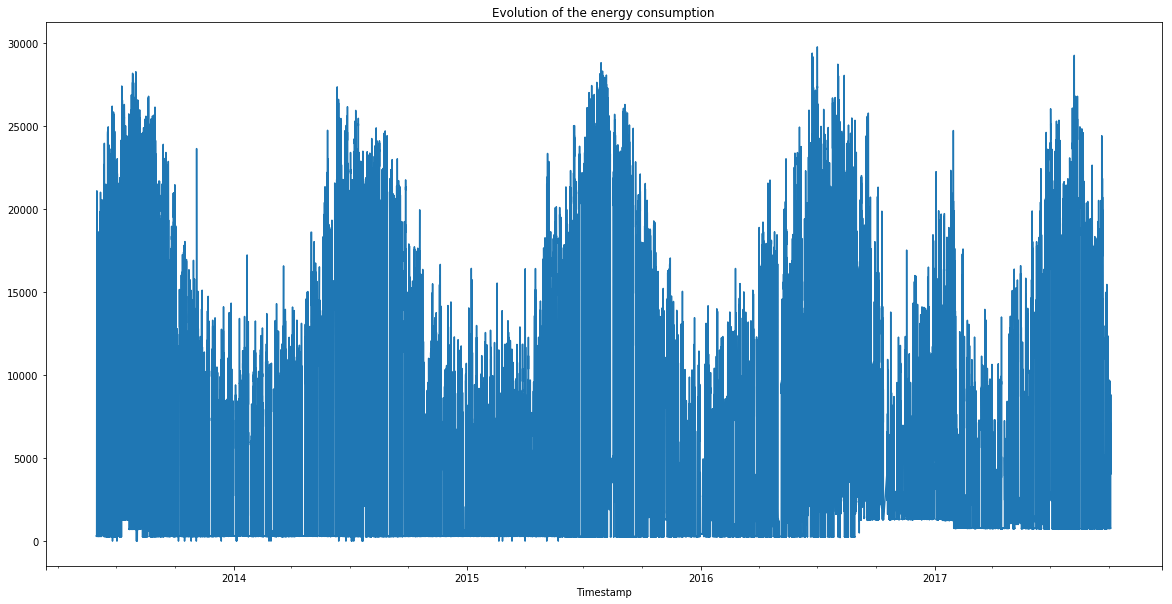

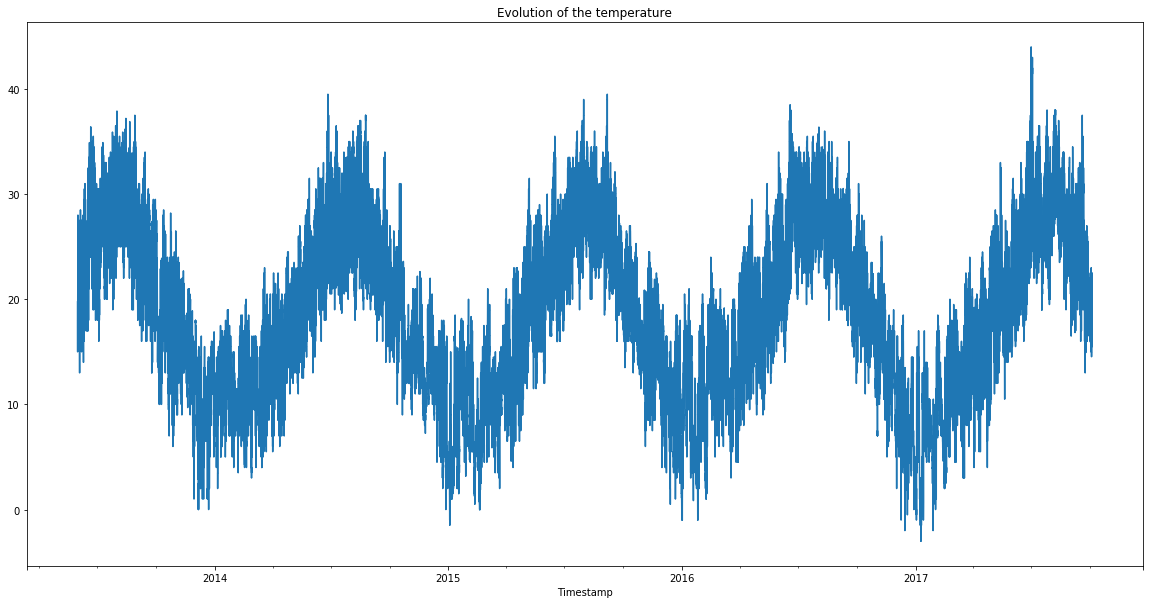

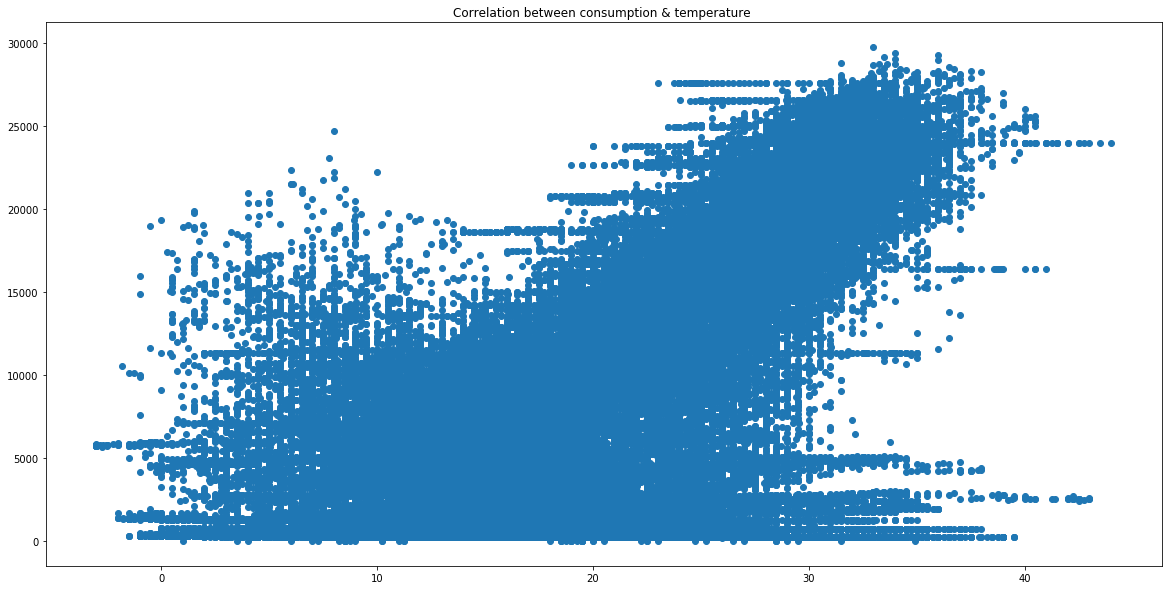

Mean values: Energy = 6049.376194683743, Temperature = 18.765666947813862
                     Temperature       Value  Value_Return  \
Timestamp                                                    
2013-05-31 00:15:00        19.00  283.887071     -0.016667   
2013-05-31 00:30:00        19.25  283.887071      0.000000   
2013-05-31 00:45:00        19.50  283.887071      0.000000   
2013-05-31 01:00:00        18.25  293.510361      0.033898   
2013-05-31 01:15:00        17.00  312.756942      0.065574   

                     Temperature_Return  Value_Diff  Temperature_Diff  
Timestamp                                                              
2013-05-31 00:15:00           -0.037975   -4.811645             -0.75  
2013-05-31 00:30:00            0.013158    0.000000              0.25  
2013-05-31 00:45:00            0.012987    0.000000              0.25  
2013-05-31 01:00:00           -0.064103    9.623291             -1.25  
2013-05-31 01:15:00           -0.068493   19.246581        

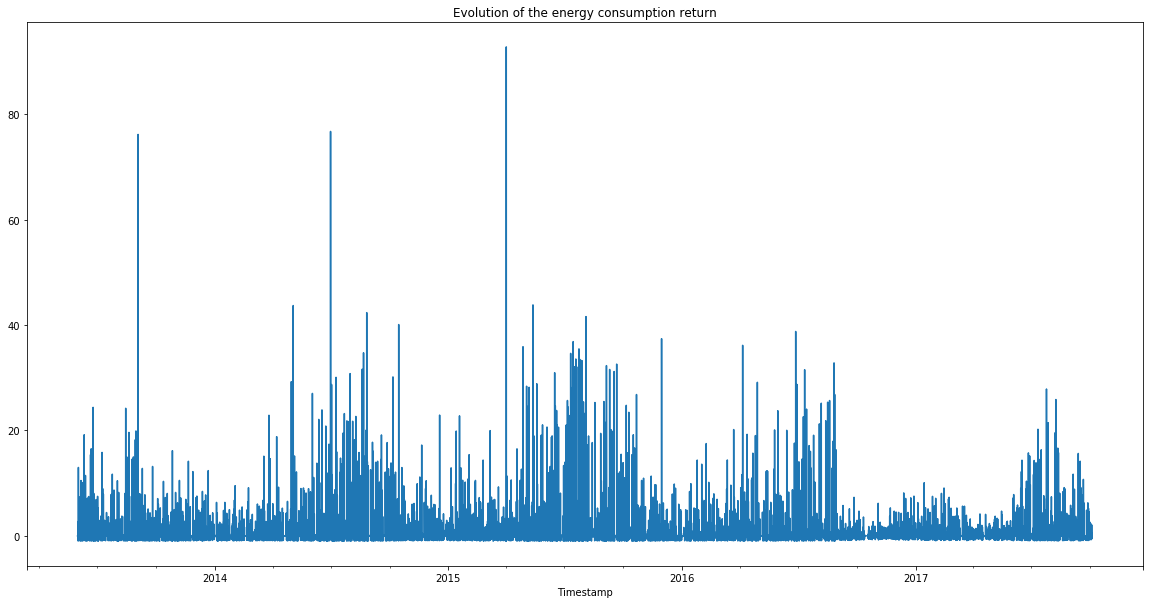

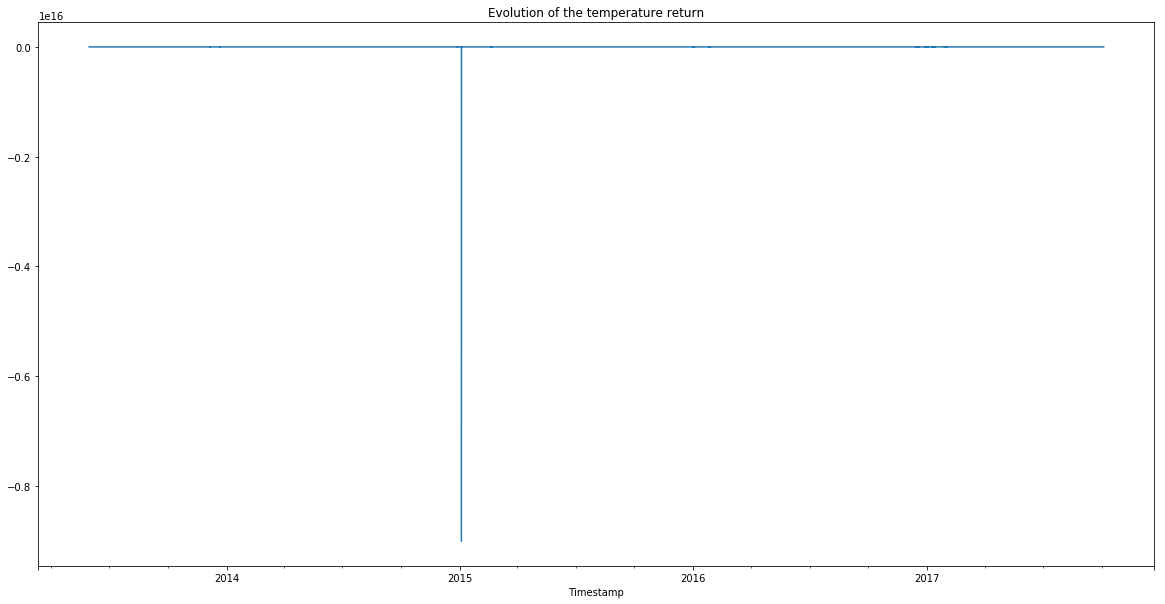

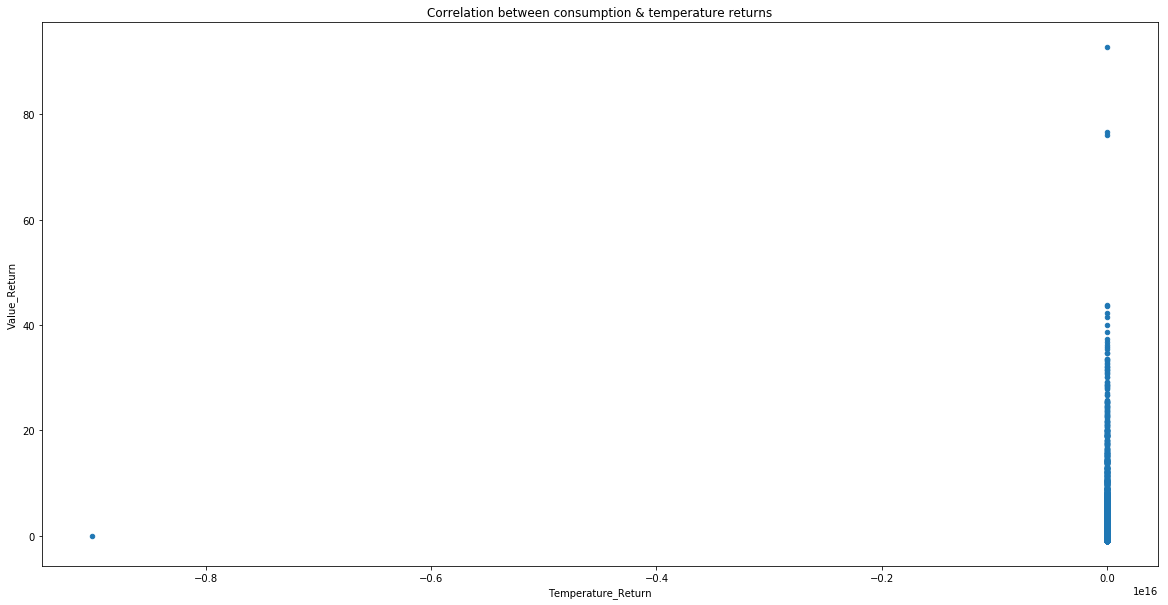

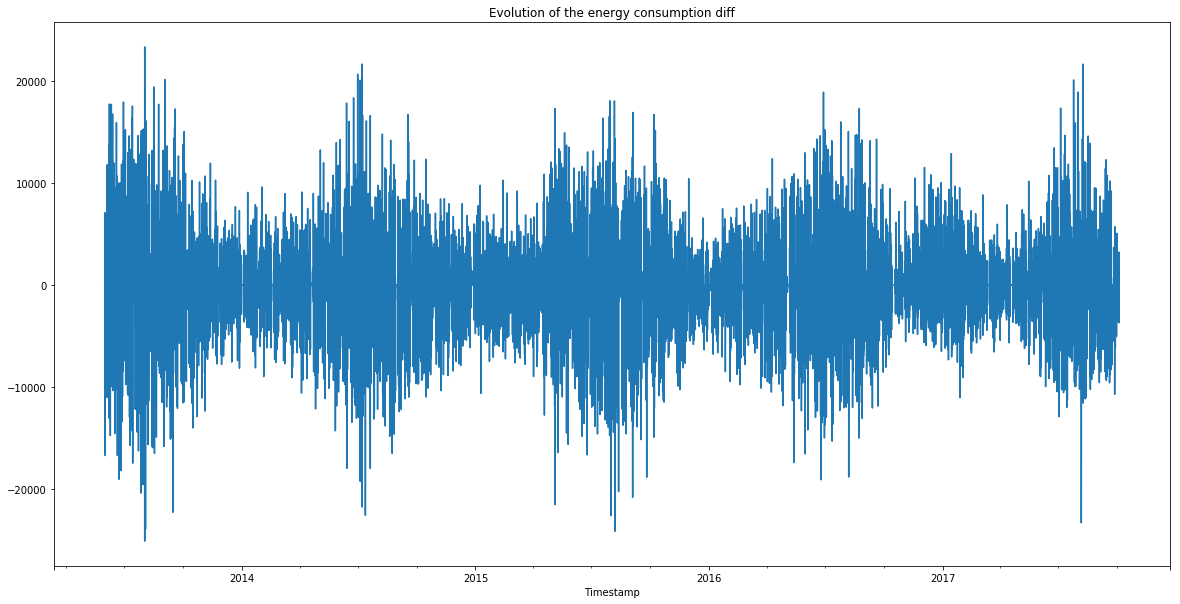

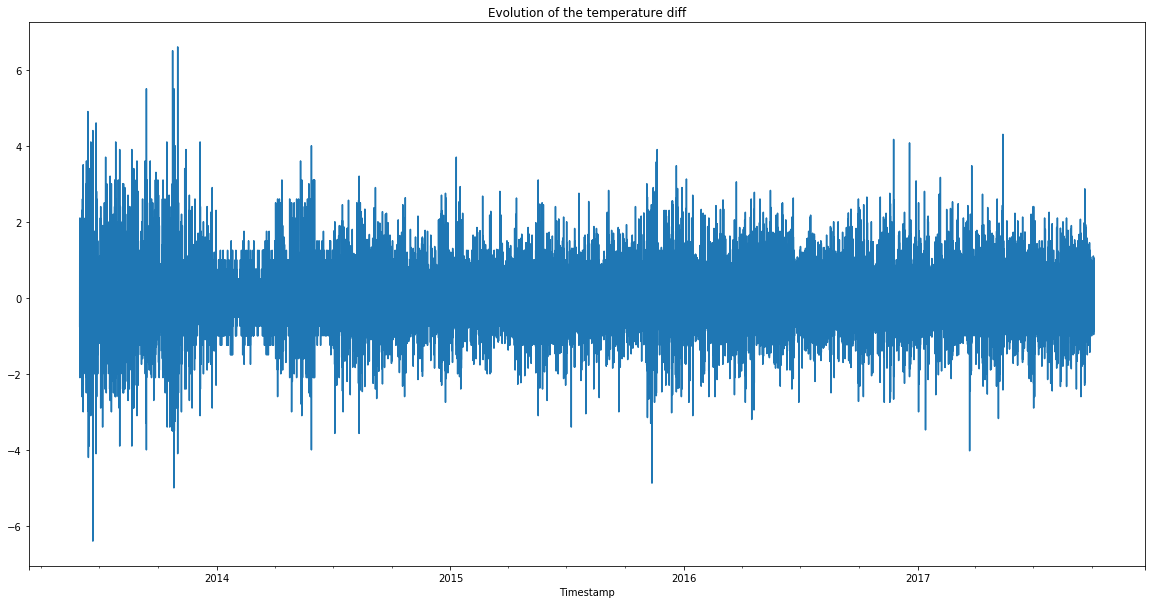

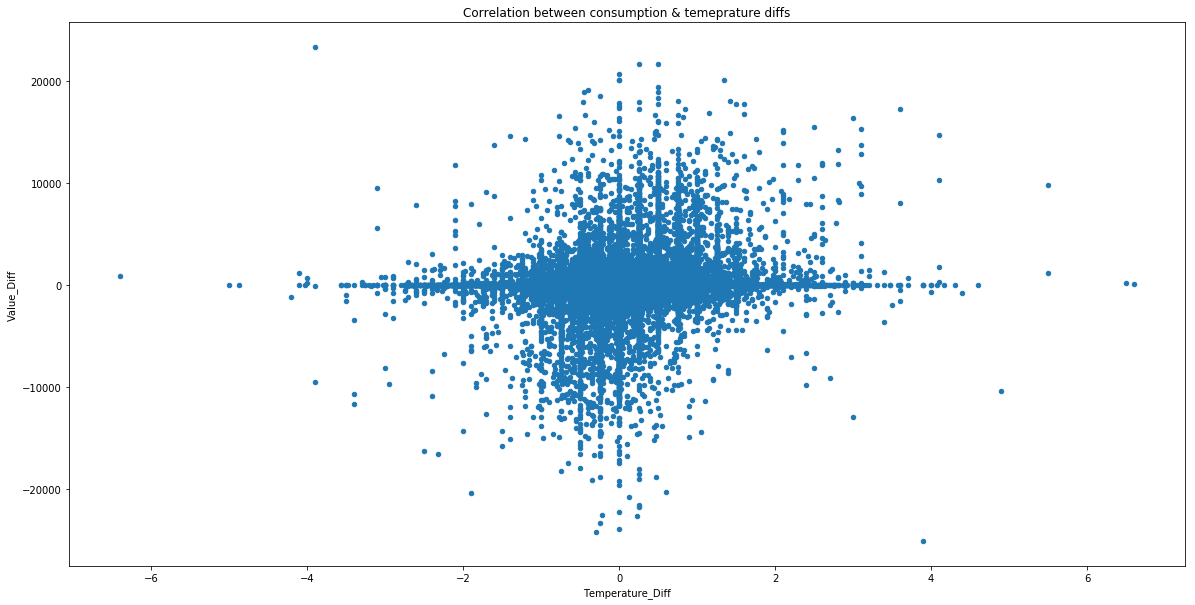

Correlations values for the variables, their returns and their diffs: 
 0.5246952623885605 nan 0.10872496219963915


In [29]:
#Get only the time series from the begining until the date where there are missing values

#len(consumptions_269)
#print(consumptions_269.head(), consumptions_269.tail())
#print(consumptions['2016-12-20 07:00:00':'2016-12-20 08:00:00'])

#Take the time series from 2013-01-02 until the 2016-12-19 not included to avoid constant values
consumptions_sliced = consumptions_269['2013-05-31':'2017-10-03']
#print(len(consumptions_sliced))
#print(consumptions_sliced.head(10), print(consumptions_sliced.tail(10)))
temperatures_sliced = temperatures_269['2013-05-31':'2017-10-03']
#print(len(temperatures_sliced))
#print(temperatures_sliced.head(10), temperatures_sliced.tail(10))

#Reindex the consmption series as there are missing values (temperatures has all of them after resampling)
consumptions_sliced = consumptions_sliced.reindex(temperatures_sliced.index, method='nearest').interpolate('linear')
#print(len(consumptions_sliced))

#Plotting for visual check
_ = consumptions_sliced.plot(figsize=(20,10), title="Evolution of the energy consumption")
plt.show()
_ = temperatures_sliced.plot(figsize=(20,10), title="Evolution of the temperature")
plt.show()

_ = plt.figure(figsize=(20,10))
_ = plt.title("Correlation between consumption & temperature ")
_ = plt.scatter(x=temperatures_sliced, y=consumptions_sliced)
plt.show()

#Print the mean values of the time series
print("Mean values: Energy = {}, Temperature = {}".format(consumptions_sliced.mean(), temperatures_sliced.mean()))

#Get the returns of the consumption and temperature
timeseries = pd.DataFrame({'Value':consumptions_sliced, 'Temperature': temperatures_sliced})
timeseries['Value_Return'] = timeseries['Value'].pct_change()
timeseries['Value_Return'].fillna(method='ffill', inplace=True)
timeseries['Temperature_Return'] = timeseries['Temperature'].pct_change()
timeseries['Temperature_Return'].fillna(method='ffill', inplace=True)

#Get the diff(1)
timeseries['Value_Diff'] = timeseries['Value'].diff()
timeseries['Temperature_Diff'] = timeseries['Temperature'].diff()

#Remove first row with NaN values after pct_change() and diff()
timeseries = timeseries.iloc[1:, :]

#Save the dataframe containing the timeseries
timeseries.to_csv('timeseries_269_DB.csv')
print(timeseries.head())

#Plot the return values
_ = timeseries['Value_Return'].plot(figsize=(20,10), title="Evolution of the energy consumption return")
plt.show()
_ = timeseries['Temperature_Return'].plot(figsize=(20,10), title="Evolution of the temperature return")
plt.show()
_ = timeseries.plot(kind='scatter', x='Temperature_Return', y='Value_Return', figsize=(20,10), 
                    title="Correlation between consumption & temperature returns")
plt.show()

#Plot the diff values
_ = timeseries['Value_Diff'].plot(figsize=(20,10), title="Evolution of the energy consumption diff")
plt.show()
_ = timeseries['Temperature_Diff'].plot(figsize=(20,10), title="Evolution of the temperature diff")
plt.show()
_ = timeseries.plot(kind='scatter', x='Temperature_Diff', y='Value_Diff', figsize=(20,10), 
                    title="Correlation between consumption & temeprature diffs")
plt.show()

#Compute the correlation
correlation = timeseries['Value'].corr(timeseries['Temperature'])
correlation_return = timeseries['Value_Return'].corr(timeseries['Temperature_Return'])
correlation_diff = timeseries['Value_Diff'].corr(timeseries['Temperature_Diff'])
print("Correlations values for the variables, their returns and their diffs: \n", 
      correlation, correlation_return, correlation_diff)

*For this building there is a greater correlation between the consumption and the temeprature values compared to the building 6, but no correlation for the return and the diff*

### 2.2 Autocorrelation
The autocorrelation analysis consists in the following step for each building:
- Resample the data to create hourly, daily, weekly, and montlhy time series (sum() is used as energy is cumulated over time)
- Test if the series are random walks (Dikey-Fuller test)
- Computes the return and diff series to get stationary series
- Computes the autocorrelation functions
- Fit models and Forecast the series using the ARMA model

#### Custom functions for Autocorrelation analysis

In [207]:
from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.tsa.arima_model import ARMA, ARIMA

In [40]:
#Function that resamples the data and computes the autocorrelation function
def get_acf(timeseries, method, alpha=0.05, Diff=False, Return=False):
    """Resamples a given time series to daily, weekly, monthly (and yearly)
    time steps using the method in argument, compute for each the autocorrelation function
    and if Diff=True and Return=True the ACF for the return and diff values for each time series"""
    
    #Replace the NaN values by interpolation
    timeseries = timeseries.interpolate('linear')
    
    #Resample using the sum() method as we deal with energy that is cummulated
    if method == 'sum':
        ts_hourly = timeseries.resample(rule='H').sum()
        ts_daily = timeseries.resample(rule='D').sum()
        ts_weekly = timeseries.resample(rule='W').sum()
        ts_monthly = timeseries.resample(rule='M').sum()
        #ts_yearly = timeseries.resample(rule='A').sum()
    
    elif method == 'mean':
        ts_hourly = timeseries.resample(rule='H').mean()
        ts_daily = timeseries.resample(rule='D').mean()
        ts_weekly = timeseries.resample(rule='W').mean()
        ts_monthly = timeseries.resample(rule='M').mean()
        #ts_yearly = timeseries.resample(rule='A').mean()
     
    for ts, lags, label in zip([timeseries, ts_hourly, ts_daily, ts_weekly, ts_monthly],
                               [1000, 200, 500, 15, 10],
                               ['original', 'hourly', 'daily', 'weekly', 'monthly']):
        print("\nAutocorrelation of the {} timeseries: ".format(label), ts.autocorr())
        print("NaN values: ", ts.isnull().sum())
        print("Length of resampled series: ", len(ts))
        #plot the time series
        ts.plot(title='{} time series'.format(label))
        plt.show()
        #plot the autocorrelation function
        plot_acf(ts, lags=lags, alpha=alpha, zero=False,
                 title="Autocorrelation Function of the {} timeseries".format(label))
        plt.show()
        
        if Return == True:
            #Plot the % change values and its ACF
            ts_return = ts.pct_change().iloc[1:]
            ts_return.plot(title="Return of the consumption for the {} timeseries".format(label))
            plt.show()
            plot_acf(ts_return, lags=lags, alpha=alpha, zero=False,
                     title="Autocorrelation Function of the {} returns timeseries".format(label))
            plt.show()
        
        if Diff == True:
        #Plot the diff values
            ts_diff = ts.diff().iloc[1:]
            ts_diff.plot(title="Diff of the consumption for the {} timeseries".format(label))
            plt.show()
            plot_acf(ts_diff, lags=lags, alpha=alpha, zero=False,
                     title="Autocorrelation Function of the {} diff timeseries".format(label))
            plt.show()
                   
    return ts_hourly, ts_daily, ts_weekly, ts_monthly#, ts_yearly

In [188]:
#Get the p-value of a time series to check whether it is a random walk
def adf_test(ts_list, labels_list):
    """Computes a Dickey-Fuller test in order to get the p-values for the
    time series put in argument (list) and their return & diff series
    to check whether they are random walk, and forecastable"""

    #Are the series random walks?  Vt = mu + phi.Vt-1 + white noise
    for ts, label in zip(ts_list, labels_list):

        #Dickey-Fuller test for the consumption values
        results = adfuller(ts)
        print("\n\np-value for {} timeseries: ".format(label), results[1])
        print("ADF statistics: {}".format(results[0]))
        for key, value in results[4].items():
            print('Critical Value {} : '.format(key), value)
        #print(results)

        #Dickey-Fuller test on the return values
        ts_return = ts.pct_change().iloc[1:]
        #print(ts_return.head())
        results = adfuller(ts_return)
        print("\np-value for {} return timeseries: ".format(label), results[1])
        print("ADF statistics: {}".format(results[0]))
        for key, value in results[4].items():
            print('Critical Value {} : '.format(key), value)

        #Dickey-Fuller test on the diff values
        ts_diff = ts.diff().iloc[1:]
        #print(ts_diff.head())
        results = adfuller(ts_diff)
        print("\np-value for {} diff timeseries: ".format(label), results[1])
        print("ADF statistics: {}".format(results[0]))
        for key, value in results[4].items():
            print('Critical Value {} : '.format(key), value)
        
    return

In [247]:
#For a range of orders, plot the BIC value to spot the lowest value
def plot_BIC(timeseries, A=[0], M=[0]):
    """
    Plot the evolution of the Bayesian Infirmation Criteria over A values
    of order for an AR model and M for a MA model 
    in order to get the orders couple that offers the min BIC value"""
    
    #Get the BIC for the (A,M) values of order for ARMA model
    BIC = np.empty(len(A)*len(M))
    order = []
    b = 0

    for m in M:
        for a in A:
            try:
                print("Order {}".format((a,m)))
                model = ARMA(timeseries, order=(a,m))
                result = model.fit()
                order.append(str((a,m)))
                BIC[b] = result.bic
                b += 1

            except np.linalg.LinAlgError: 
                print("Algorithm could not converge for order {}".format((a,m)))
                order.append(str((a,m)))
                BIC[b] = np.nan
                b += 1
            
    #Plot the BIC values
    plt.figure(figsize=(20,10))
    plt.plot(order, np.array(BIC), marker='o')
    plt.xlabel('Order of the ARMA model')
    plt.ylabel('Value of the Bayesian Information Criteria')
    plt.title('Evolution of the BIC vs the order of the ARMA model')
    plt.show()
        

    #Print the order coresponding to the lowest BIC value
    i = np.argmin(BIC)
    print("Lowest BIC obtained for order {}".format(order[i]))

    return

#### Building 6 Consumption Series

                     Temperature         Value  Value_Return  \
Timestamp                                                      
2013-01-02 00:15:00         15.0  25177.861408     -0.000919   
2013-01-02 00:30:00         15.0  25154.698702     -0.000920   
2013-01-02 00:45:00         15.0  25177.861408      0.000921   
2013-01-02 01:00:00         15.0  25201.024114      0.000920   
2013-01-02 01:15:00         15.0  24946.234349     -0.010110   

                     Temperature_Return  Value_Diff  Temperature_Diff  
Timestamp                                                              
2013-01-02 00:15:00                 0.0  -23.162706               0.0  
2013-01-02 00:30:00                 0.0  -23.162706               0.0  
2013-01-02 00:45:00                 0.0   23.162706               0.0  
2013-01-02 01:00:00                 0.0   23.162706               0.0  
2013-01-02 01:15:00                 0.0 -254.789766               0.0  

Autocorrelation of the original timeseries:  0

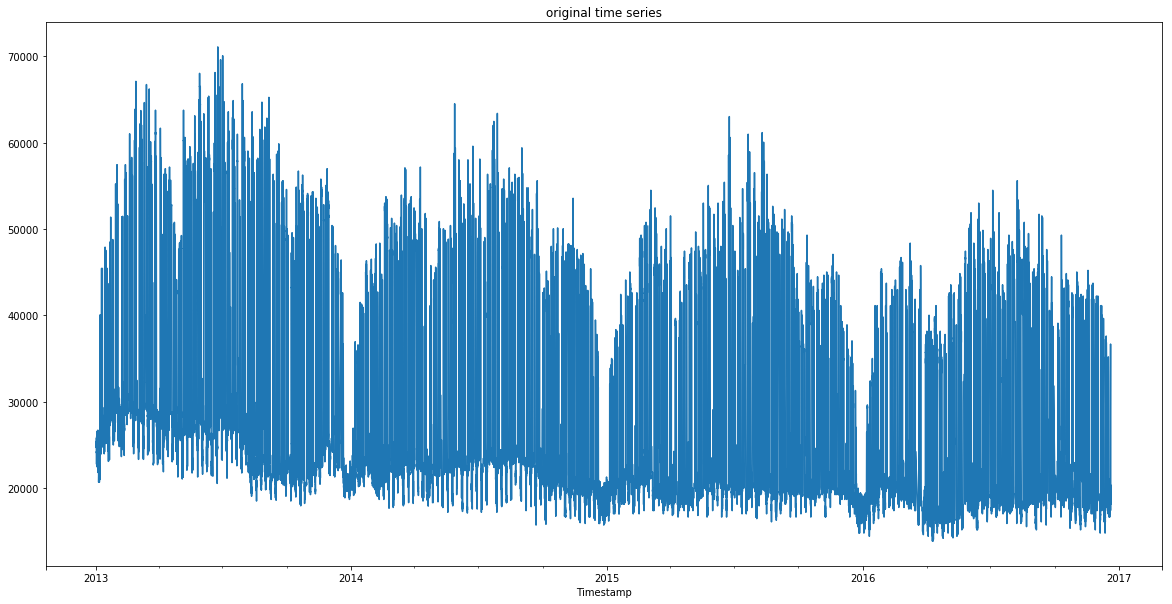

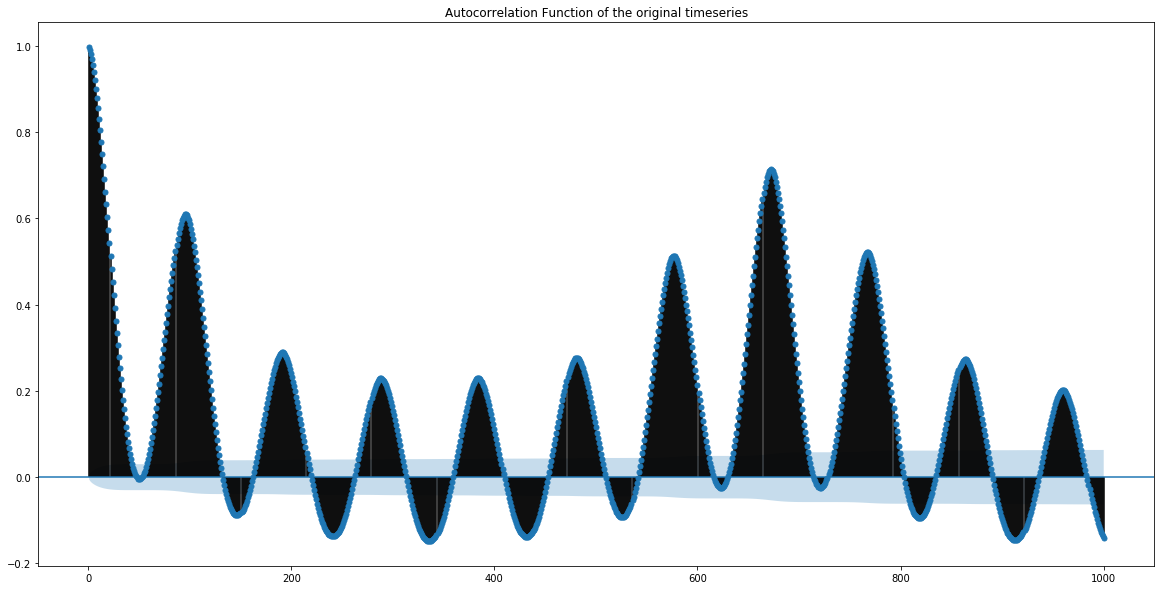

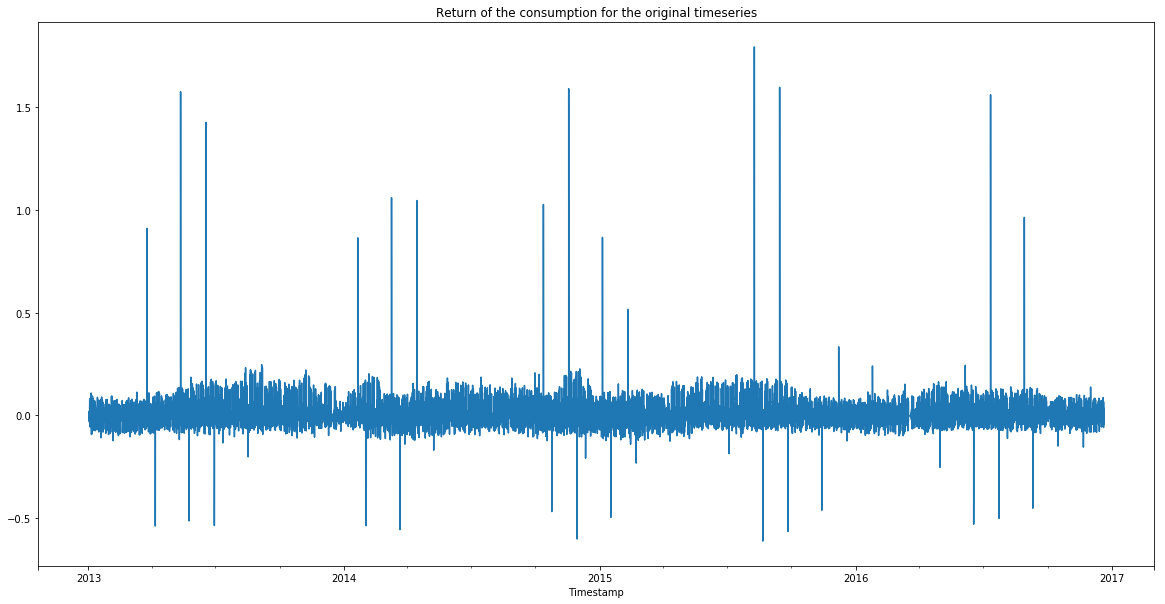

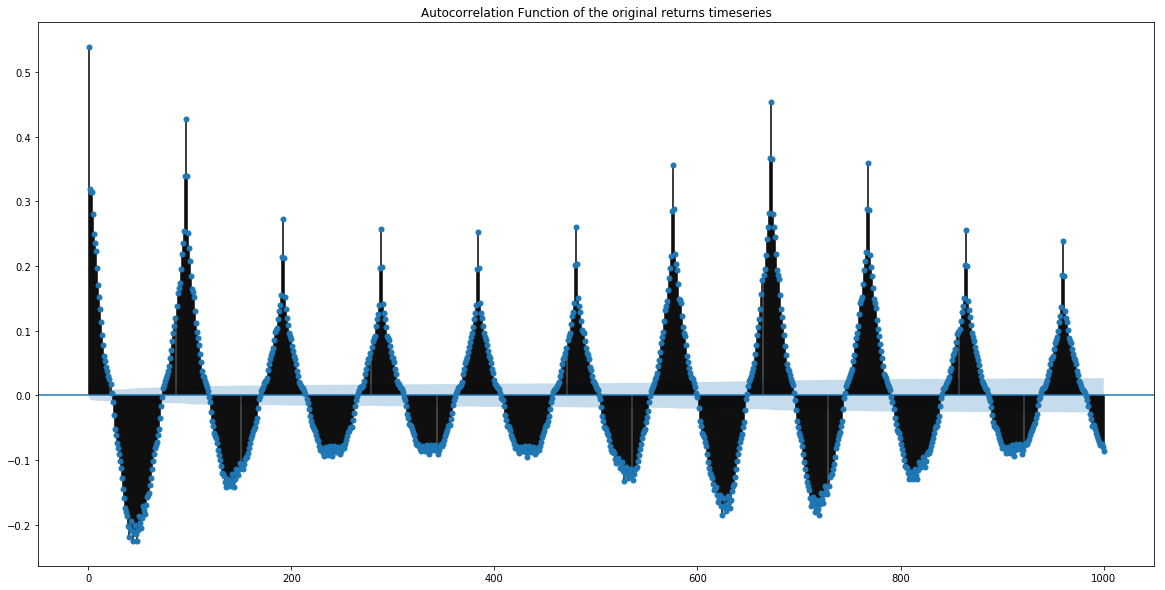

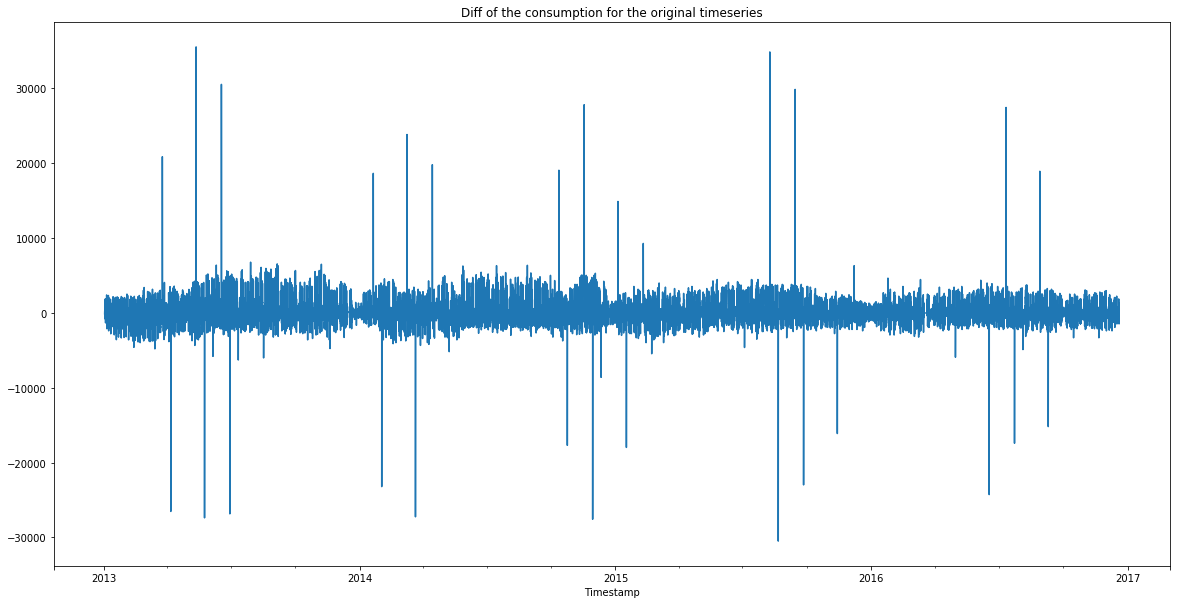

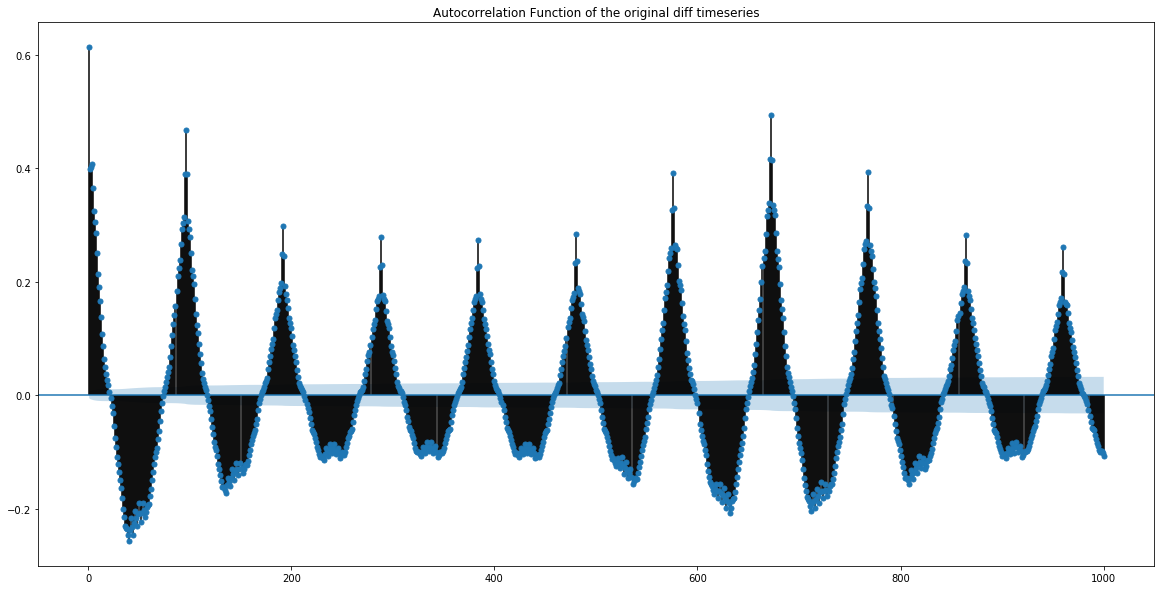


Autocorrelation of the hourly timeseries:  0.9711345967431506
NaN values:  0
Length of resampled series:  34752


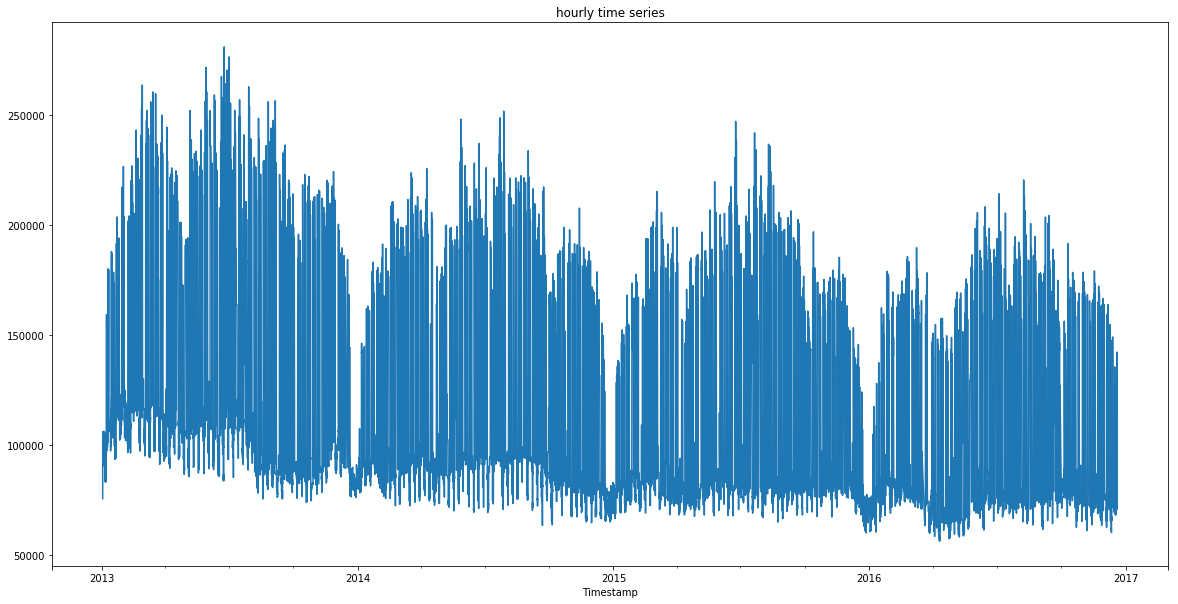

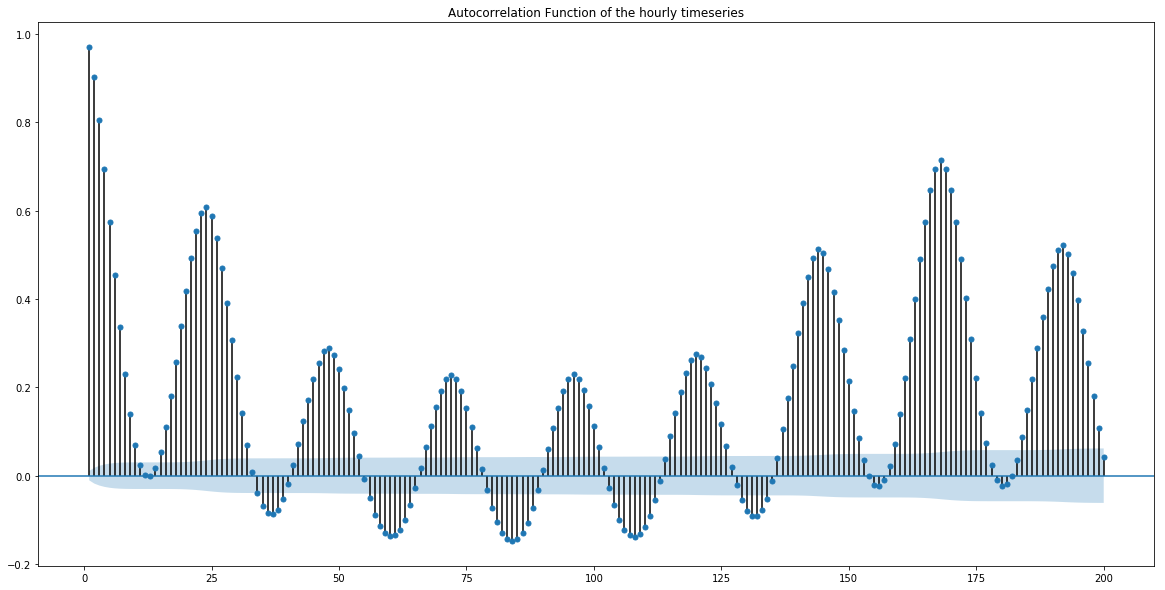

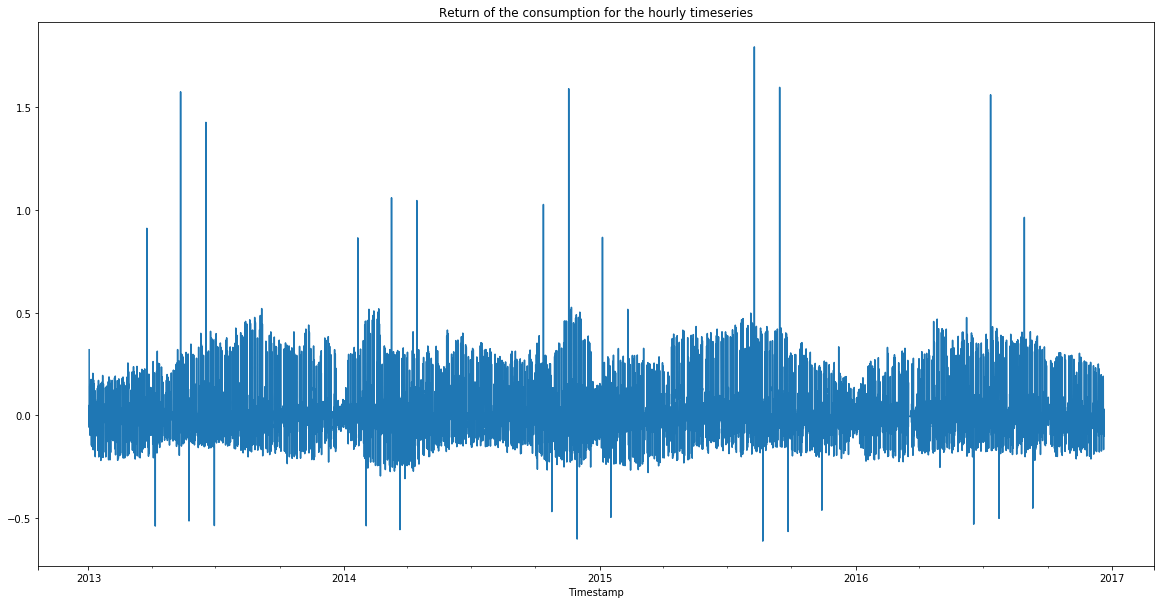

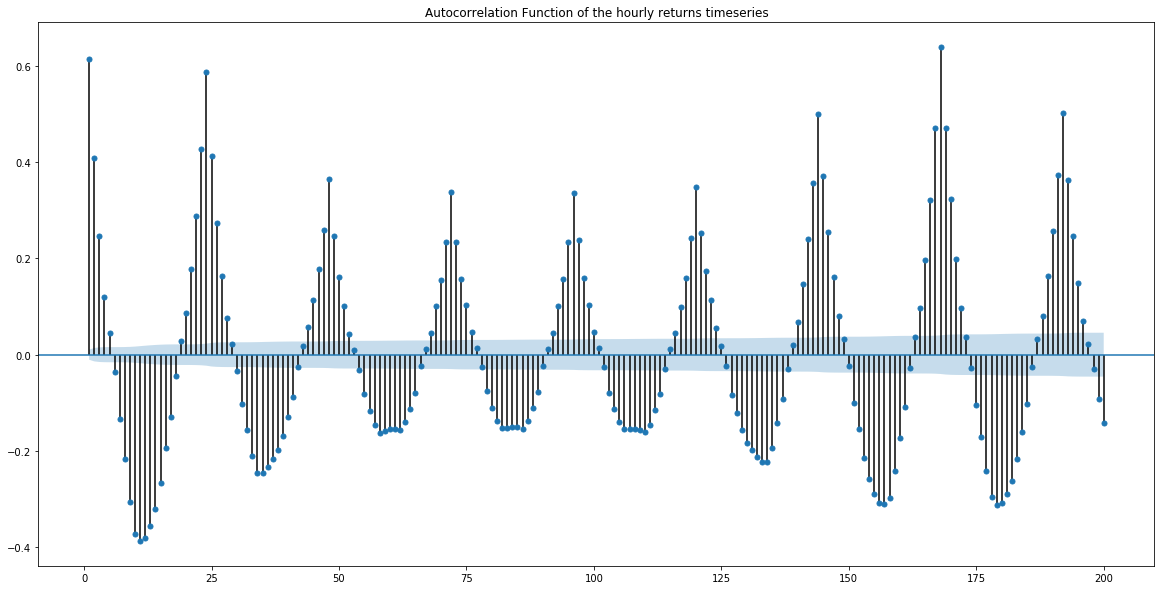

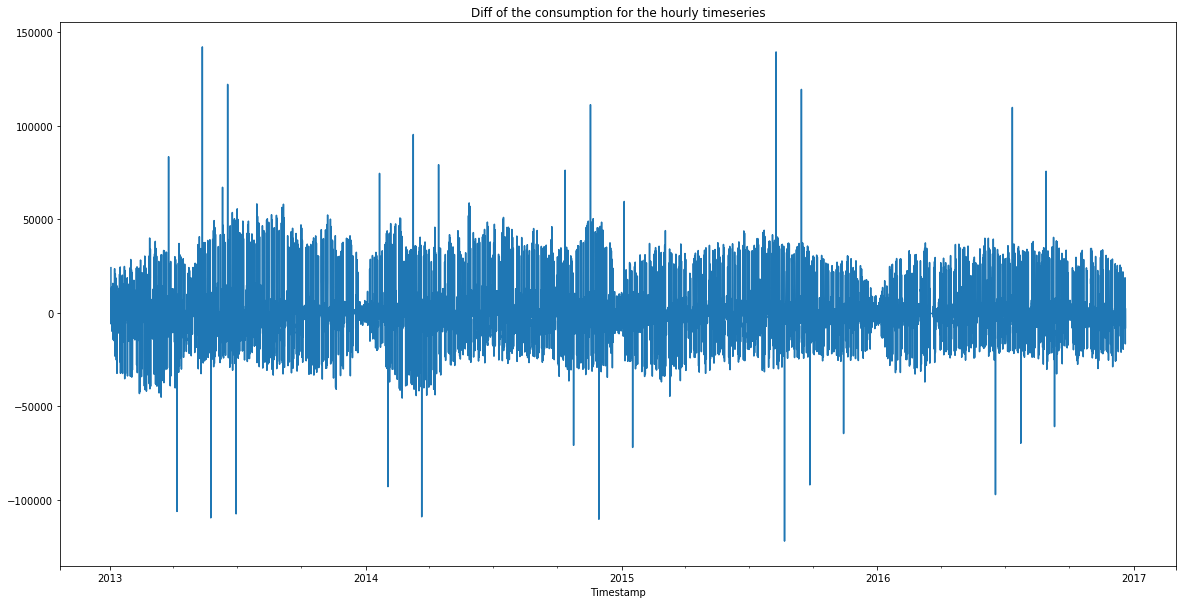

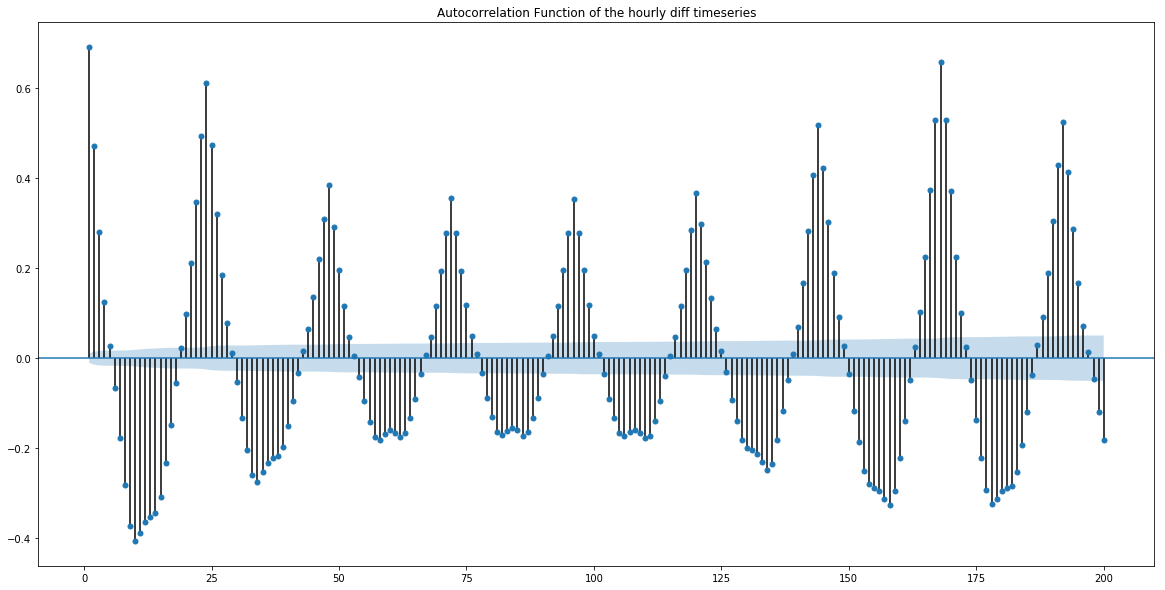


Autocorrelation of the daily timeseries:  0.5937175485152328
NaN values:  0
Length of resampled series:  1448


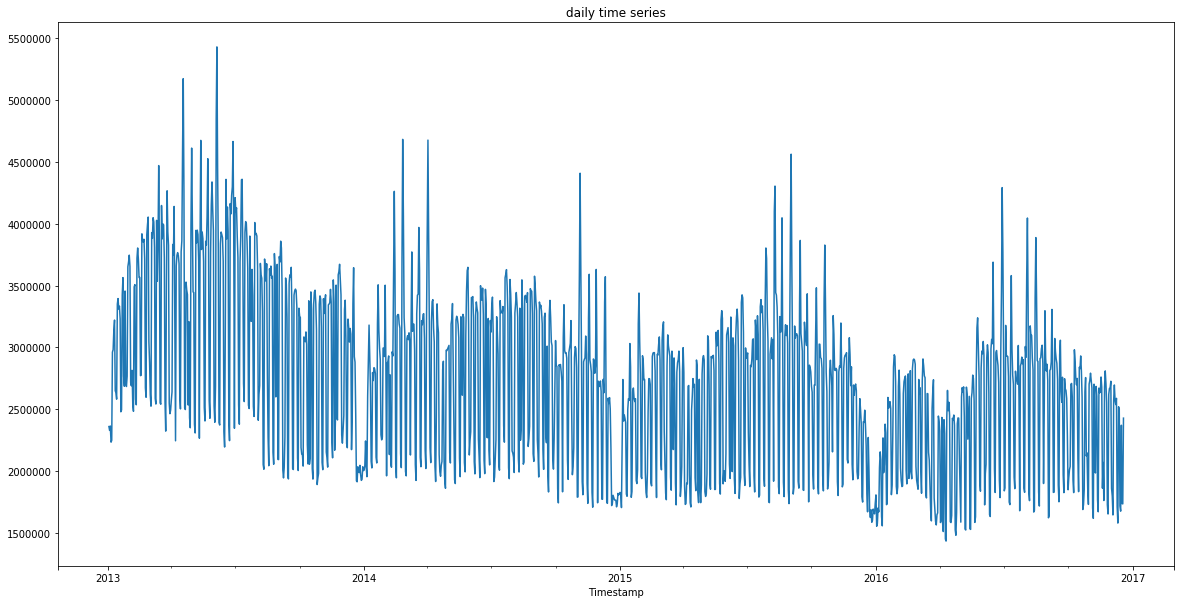

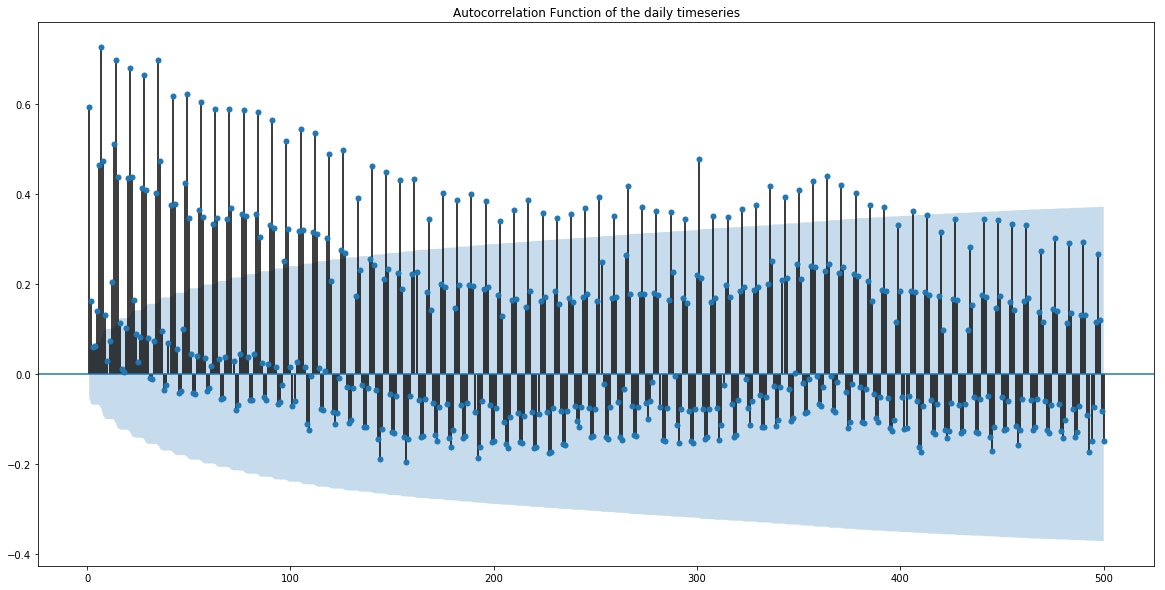

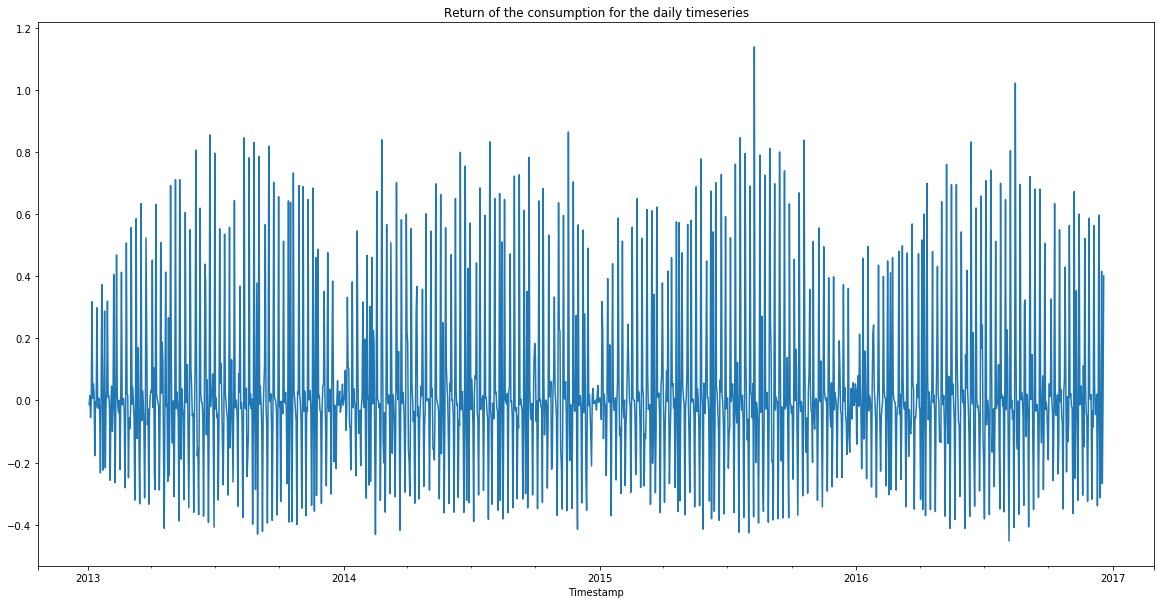

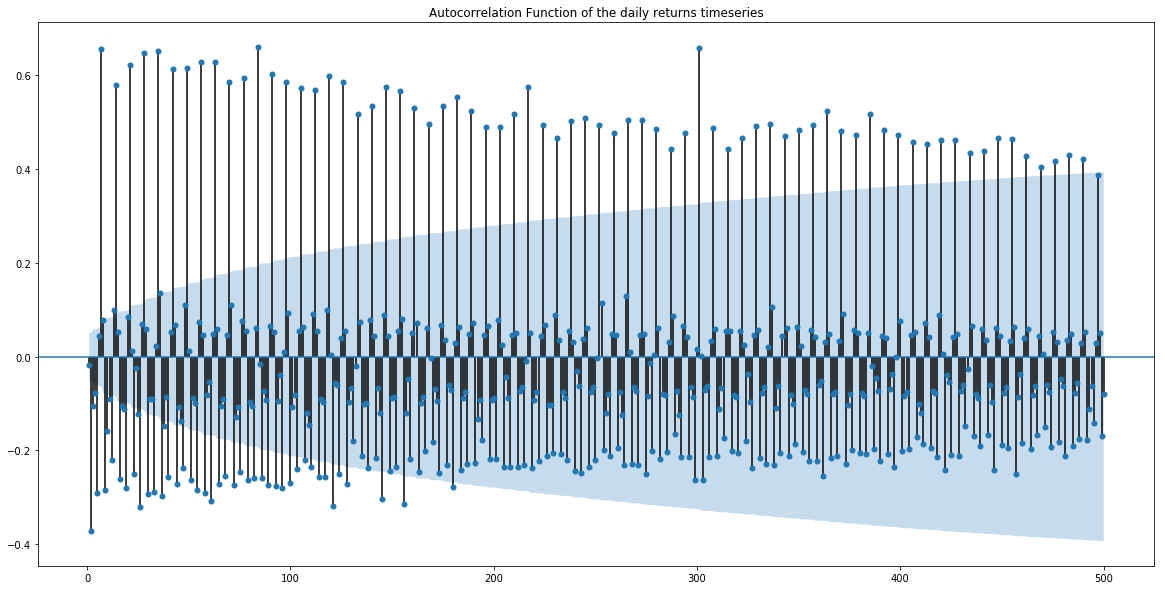

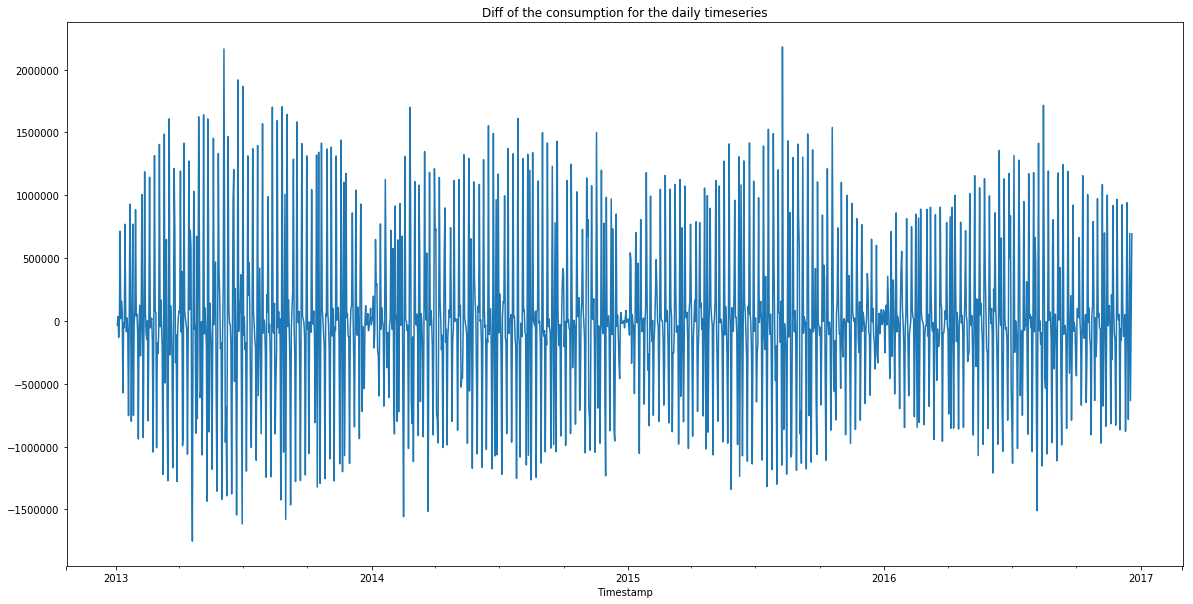

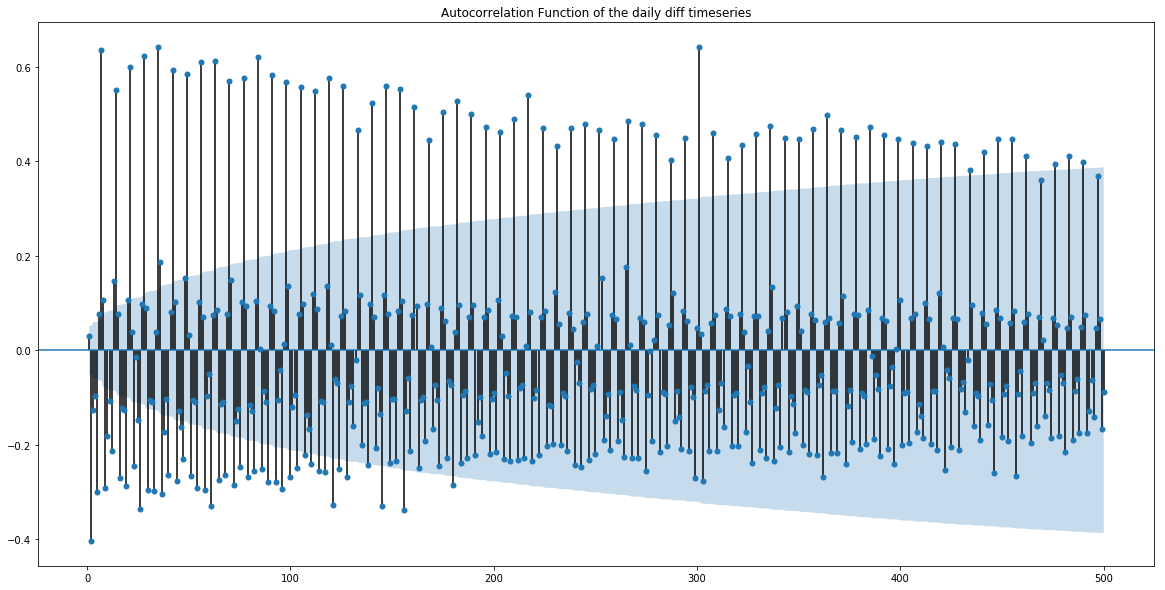


Autocorrelation of the weekly timeseries:  0.7653961792961502
NaN values:  0
Length of resampled series:  208


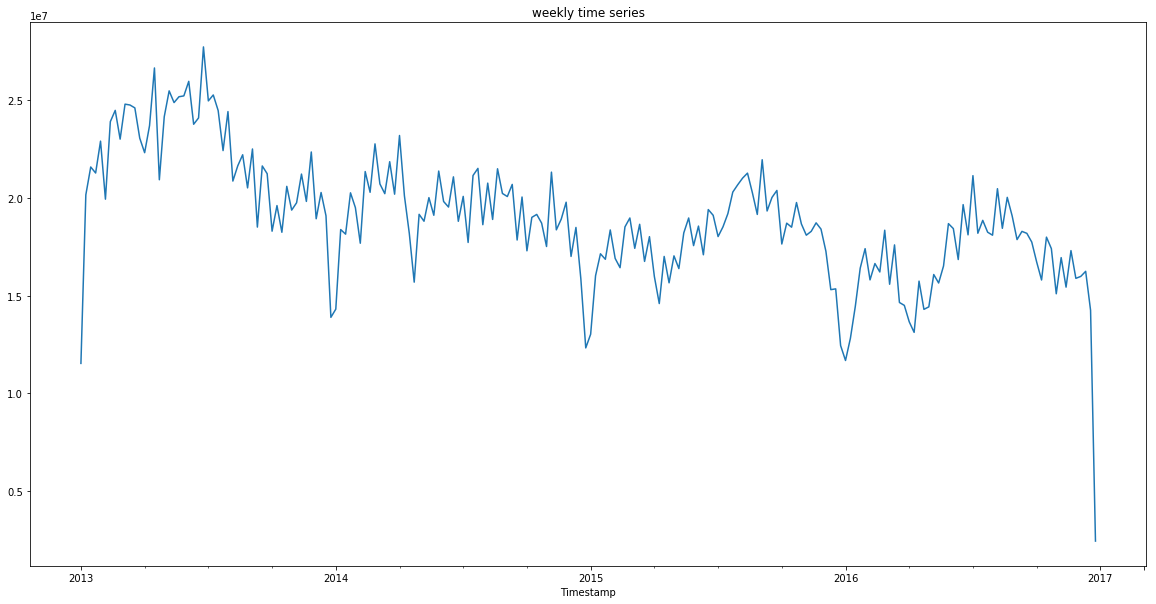

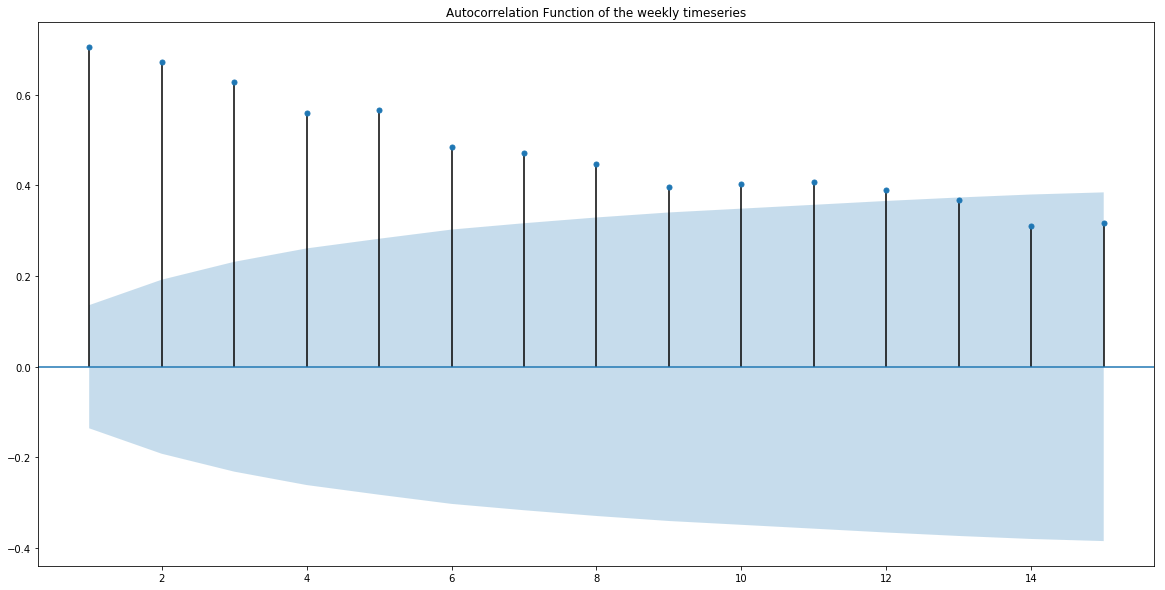

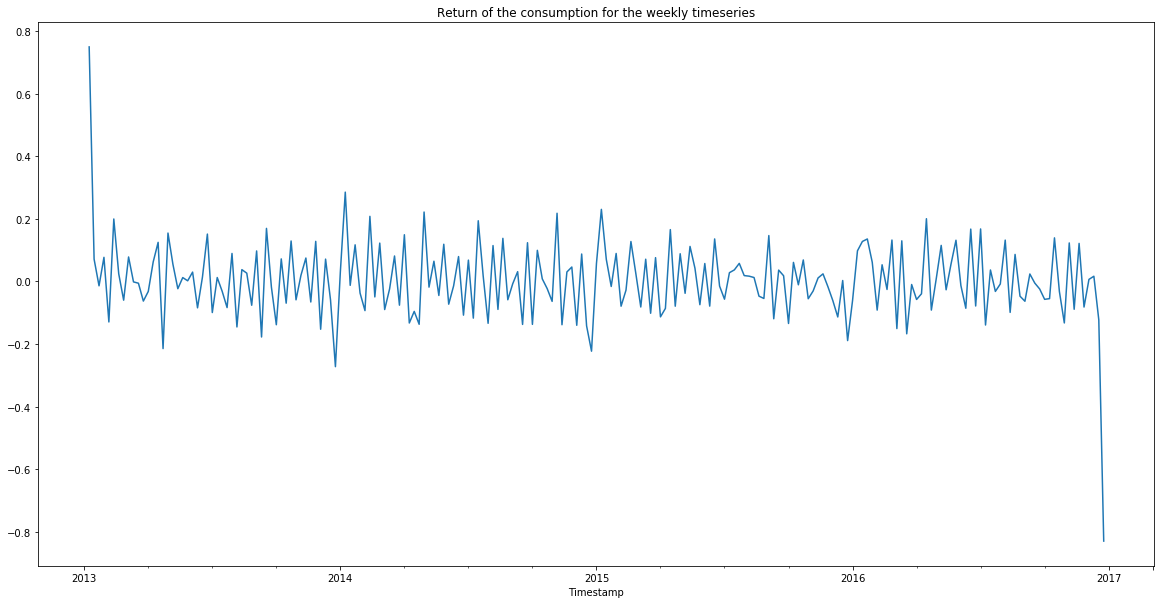

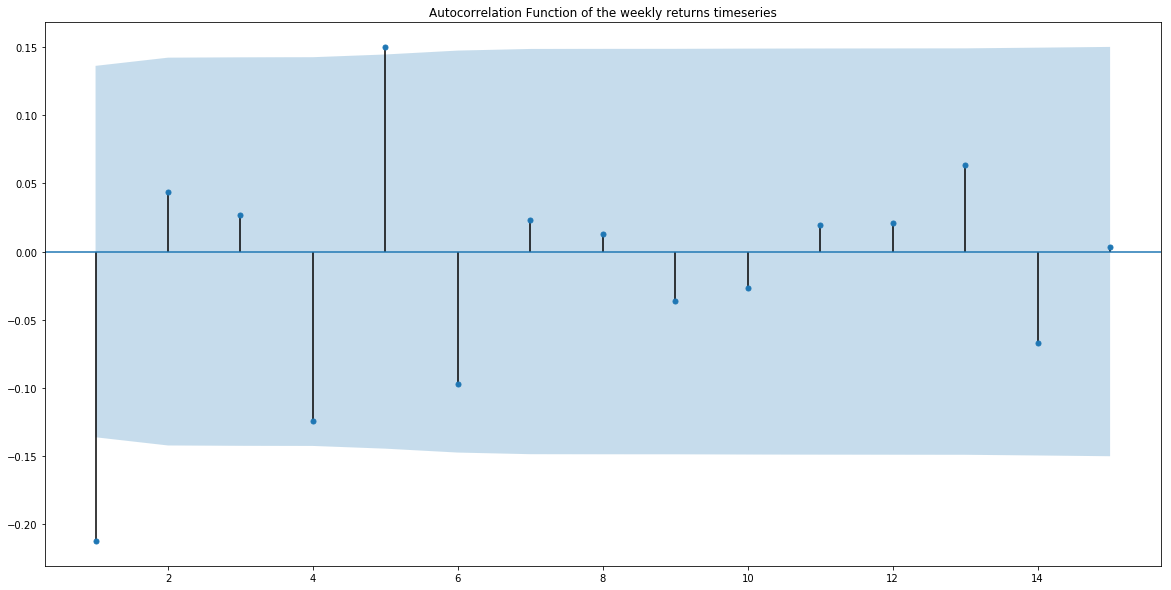

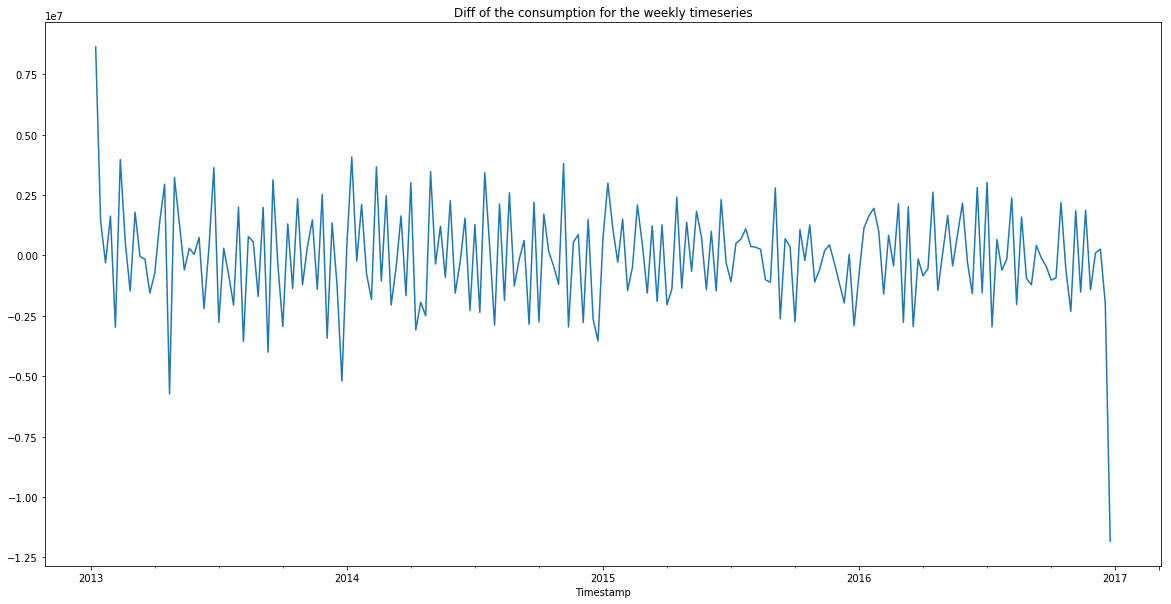

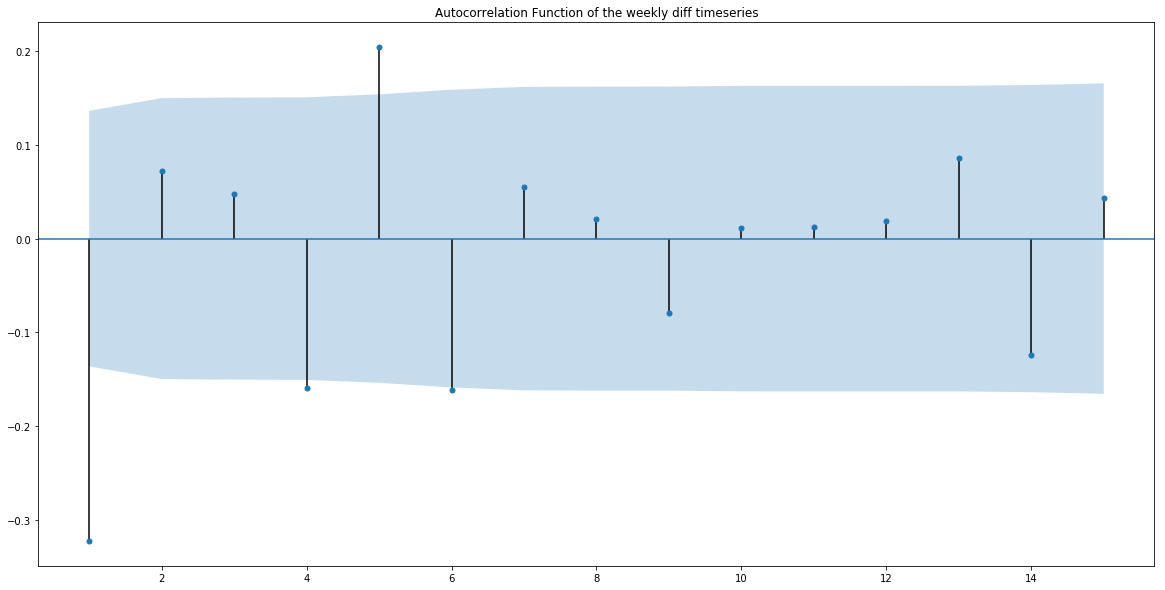


Autocorrelation of the monthly timeseries:  0.7993403037995358
NaN values:  0
Length of resampled series:  48


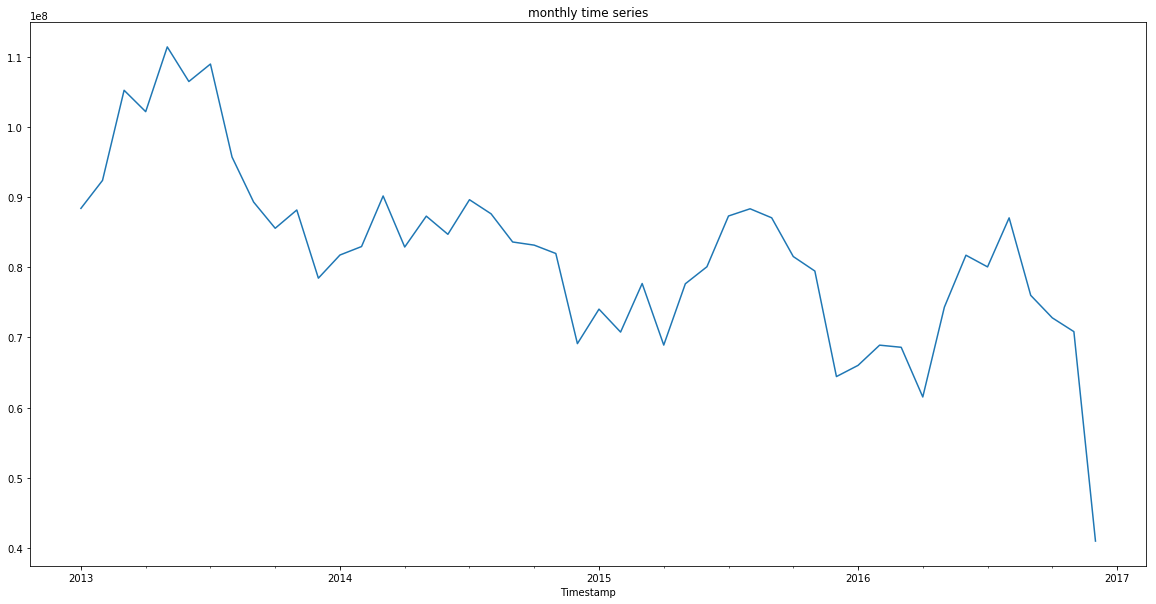

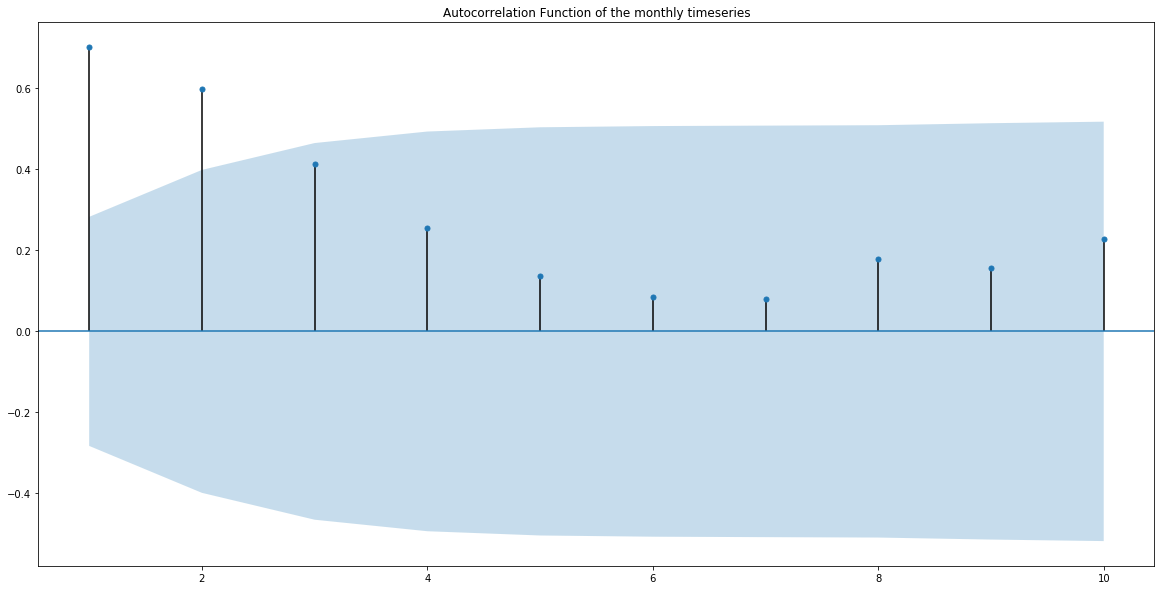

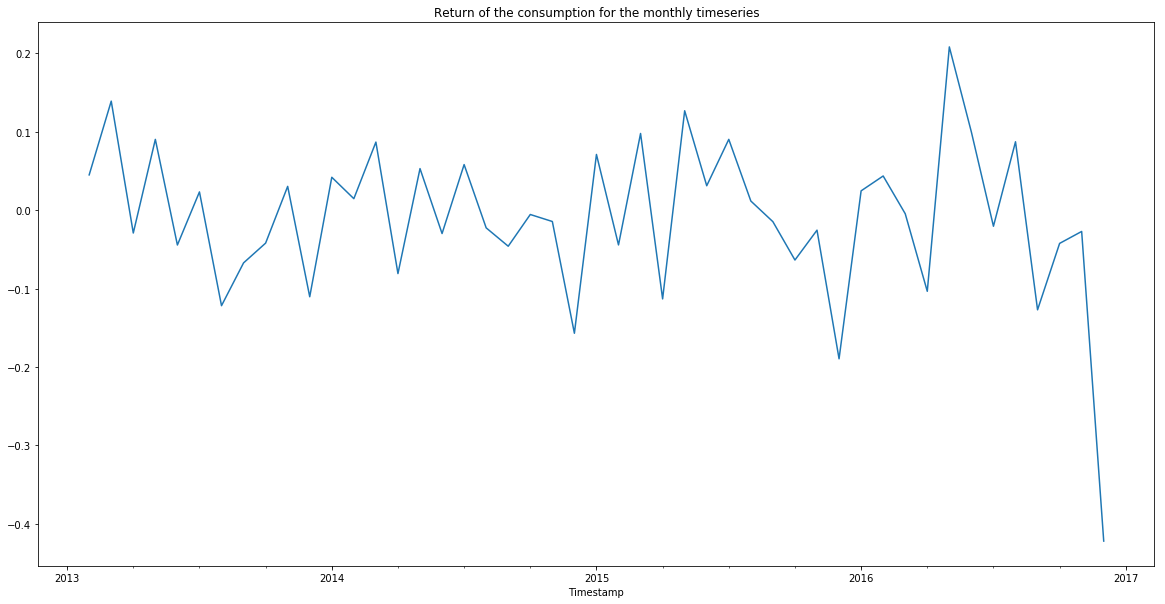

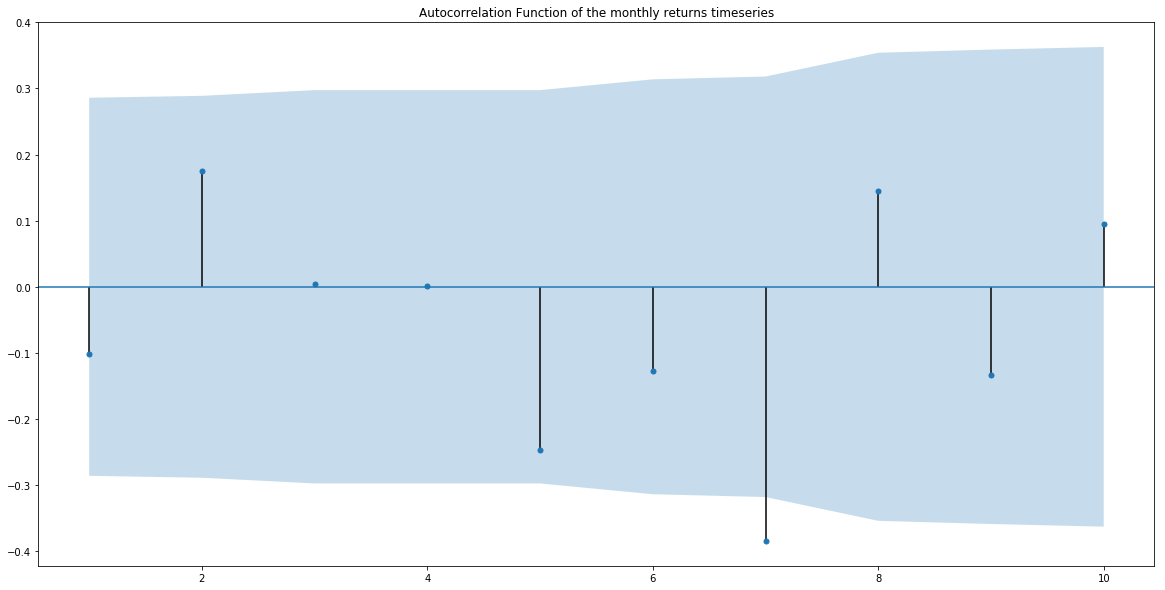

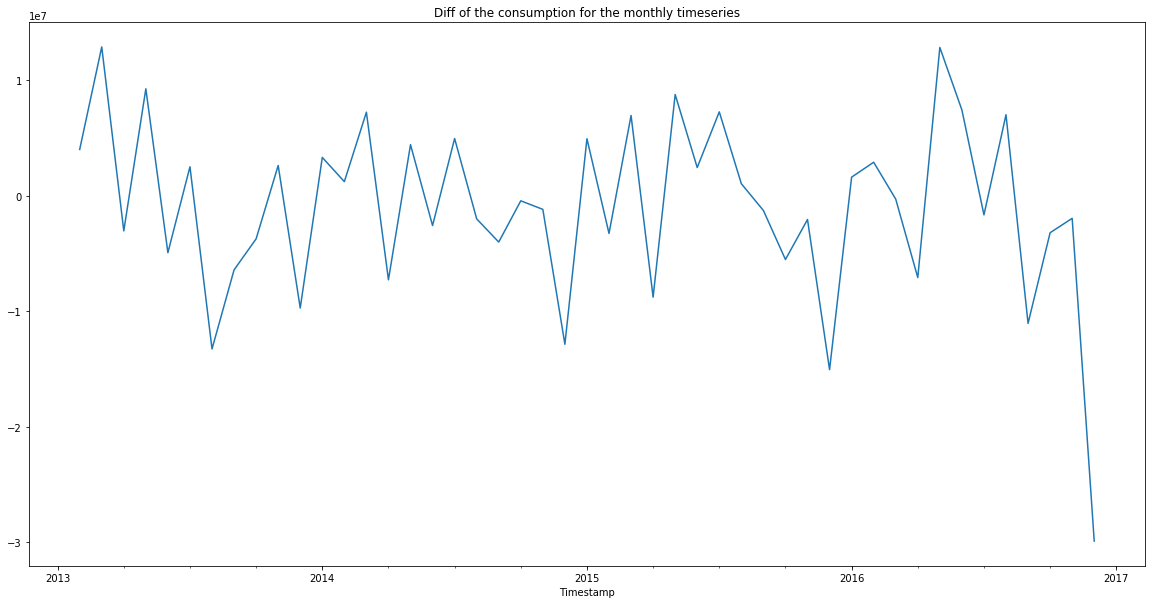

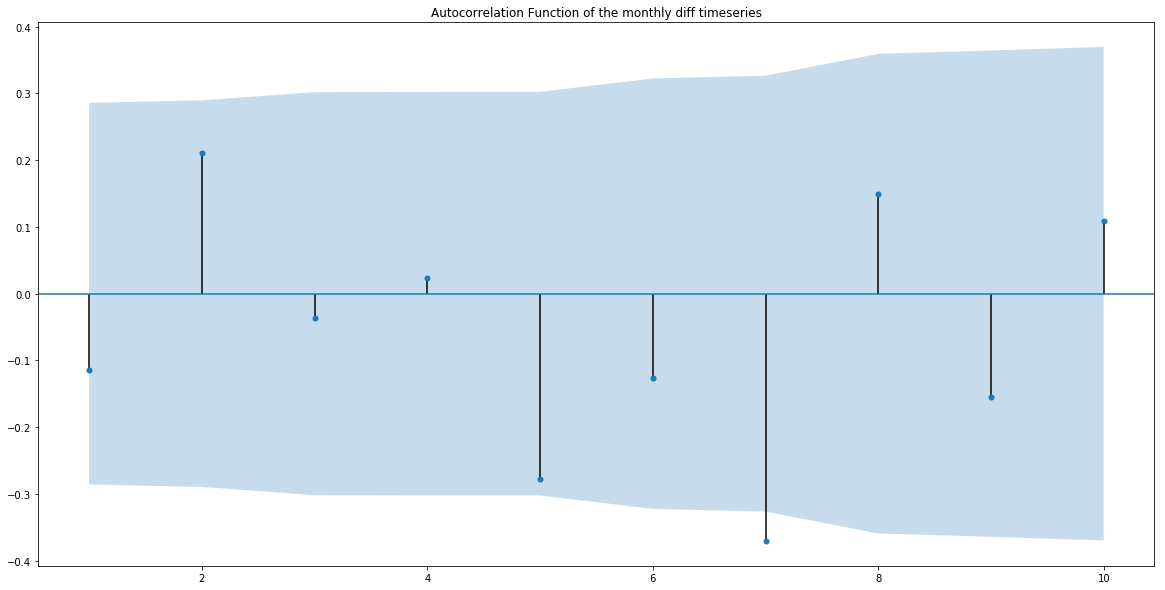

In [118]:
#Load the timeseries dataframe of the building 6
timeseries = pd.read_csv('timeseries_6_DB.csv', parse_dates=[0], index_col=0)
print(timeseries.head())

#Get ACF functions of the Value time series
ts_hourly, ts_daily, ts_weekly, ts_monthly = get_acf(timeseries['Value'], 
                                                     method='sum', alpha=0.05, Return=True, Diff=True)

In [181]:
#Augmented Dickey-Fuller test for non-stationarity test for the series
adf_test(ts_list=[ts_hourly, ts_daily, ts_weekly, ts_monthly],
                  labels_list=['hourly', 'daily', 'weekly', 'monthly'])



p-value for hourly timeseries:  0.0
ADF statistics: -20.847353523194922
Critical Value 1% :  -3.430538466392287
Critical Value 5% :  -2.861623297465434
Critical Value 10% :  -2.5668143366268303

p-value for hourly return timeseries:  0.0
ADF statistics: -31.032649462347337
Critical Value 1% :  -3.430538466392287
Critical Value 5% :  -2.861623297465434
Critical Value 10% :  -2.5668143366268303

p-value for hourly diff timeseries:  0.0
ADF statistics: -31.23286133877089
Critical Value 1% :  -3.4305384772563334
Critical Value 5% :  -2.8616233022669197
Critical Value 10% :  -2.566814339182537


p-value for daily timeseries:  0.12560849106343647
ADF statistics: -2.4596289730458873
Critical Value 1% :  -3.434953749425684
Critical Value 5% :  -2.8635732362456845
Critical Value 10% :  -2.567852483484606

p-value for daily return timeseries:  1.9060853914399185e-07
ADF statistics: -5.974047365680695
Critical Value 1% :  -3.4349569928153607
Critical Value 5% :  -2.863574667579351
Critical Valu

If the Dikey-Fuller test returns p-value>0.05 and a significantly negative test statistic, then we can reject the null hypothesis that the timeseries has a unit root and is non-stationary, with enough confidence.

*--> For daily, weekly and monthly consumption value time series can be considered as random walks (non-stationary) with enough confidence. They are by consequence not forecastable as they are.*

*--> The hourly values time series returns a null p-value that allows us to reject the non-random walk hypothesis of the series. However, we can notice a decreasing trend and an annual seasonality.*

*--> The return & diff(1) series for every time step can be considerd not as random walks with confidence. If stationary, they are forecastable with an ARIMA model. The order of the model is available according to the ACF plot.*

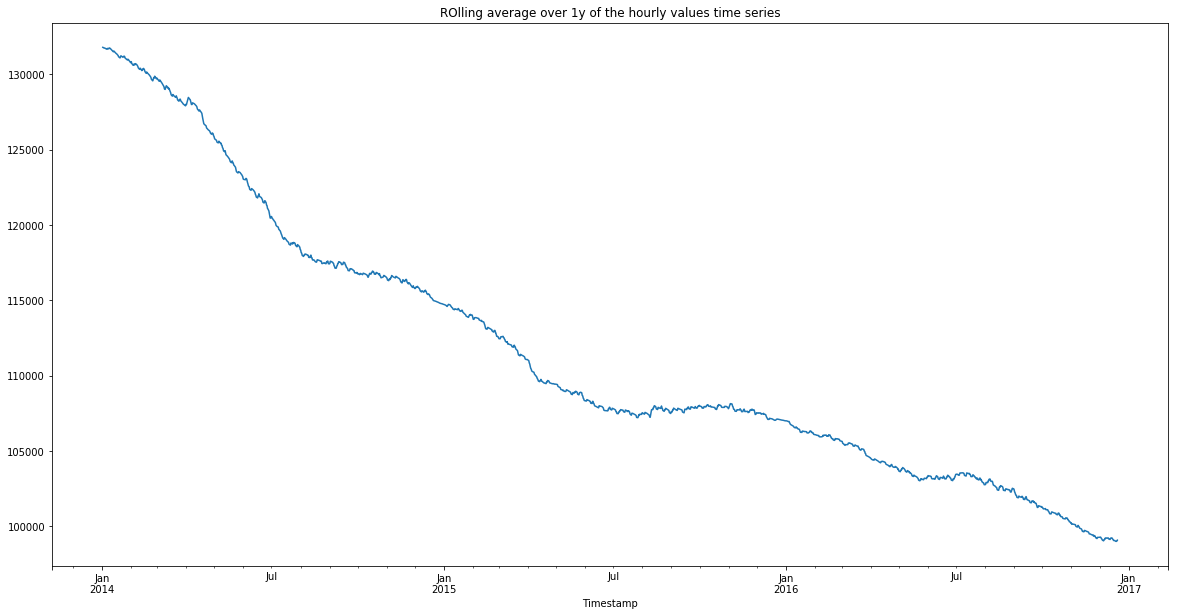

In [198]:
#Plot the rolling average over a year of the hourly values time series to get the trend
_ = ts_hourly.rolling(8760).mean().plot(title='ROlling average over 1y of the hourly values time series')
plt.show()

#### Estimate

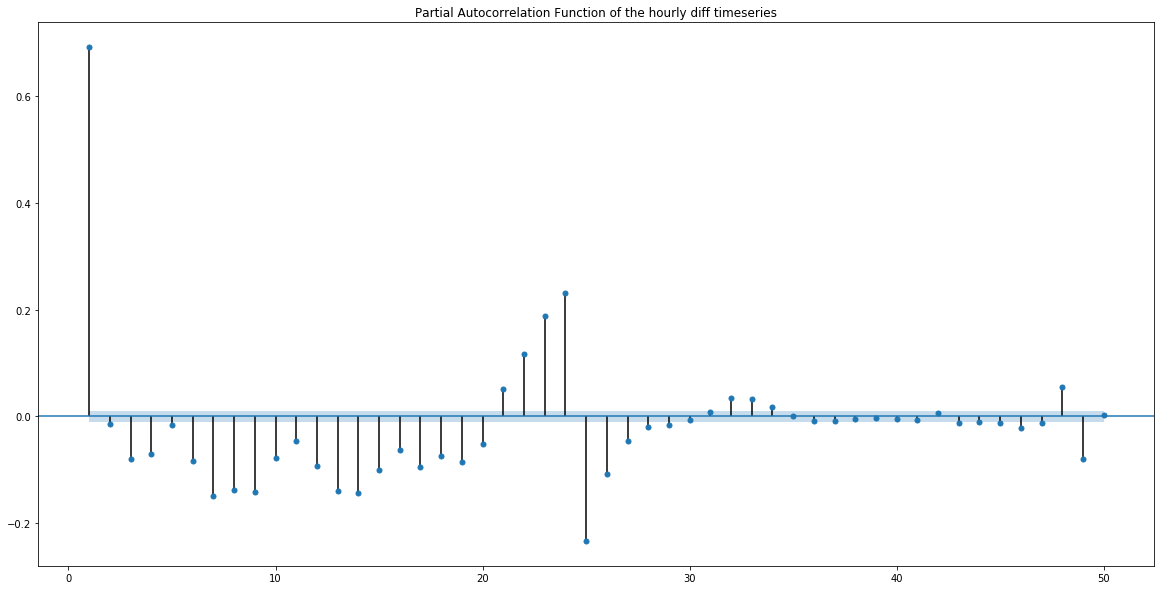

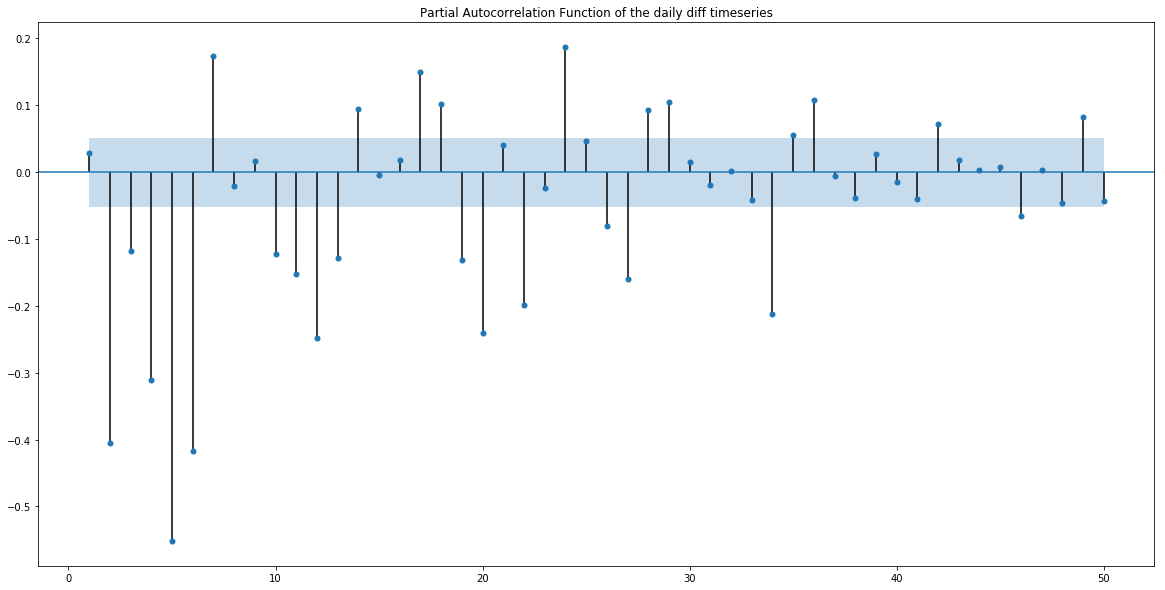

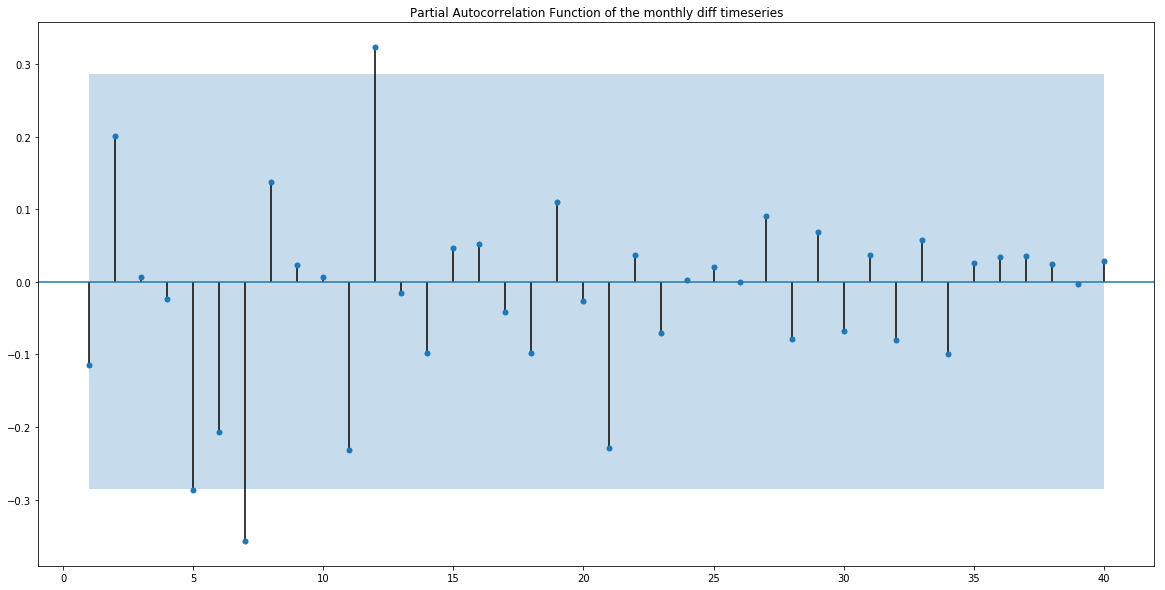

In [212]:
#Get the first-order difference for the timeseries
ts_hourly_diff = ts_hourly.diff().iloc[1:]
ts_daily_diff = ts_daily.diff().iloc[1:]
ts_monthly_diff = ts_monthly.diff().iloc[1:]

#Get the partial autocorrelation functions to see the order of the ARIMA models
plot_pacf(ts_hourly_diff, lags=100, alpha=0.05, zero=False,
                     title="Partial Autocorrelation Function of the hourly diff timeseries")
plt.show()

plot_pacf(ts_daily_diff, lags=100, alpha=0.05, zero=False,
                     title="Partial Autocorrelation Function of the daily diff timeseries")
plt.show()

plot_pacf(ts_monthly_diff, lags=40, alpha=0.05, zero=False,
                     title="Partial Autocorrelation Function of the monthly diff timeseries")
plt.show()

Order (8, 1)


C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


Order (9, 1)
Order (10, 1)
Order (11, 1)
Order (12, 1)
Order (13, 1)
Order (14, 1)


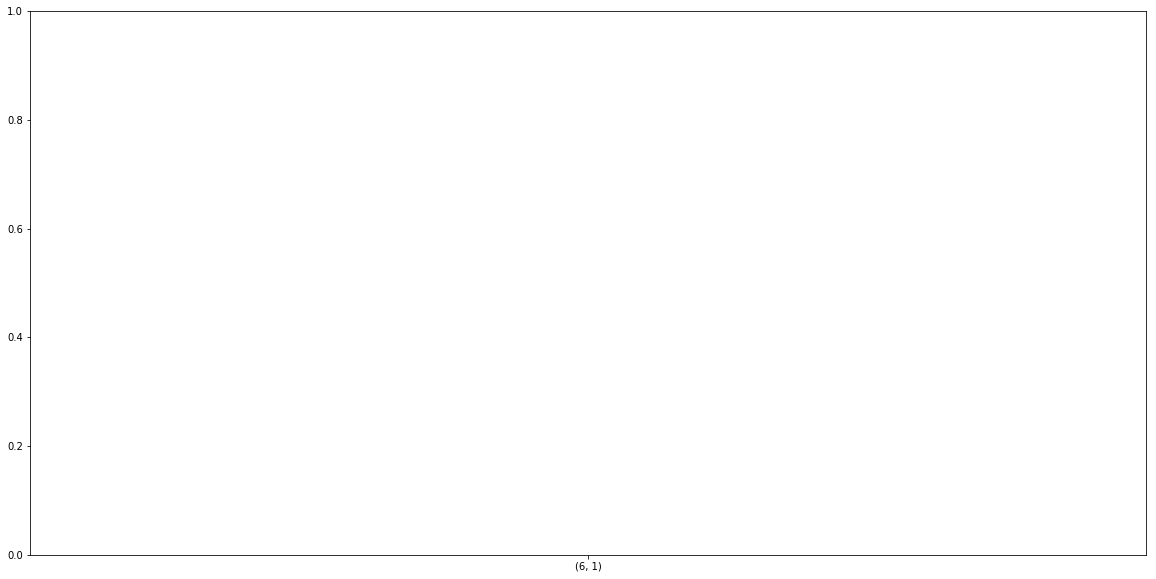

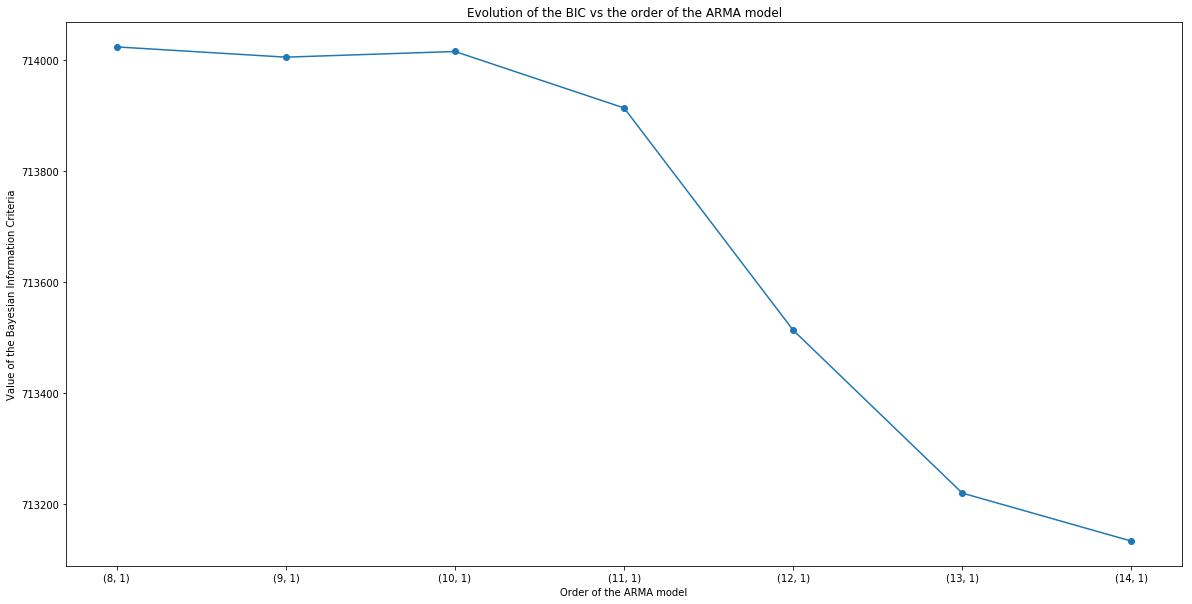

Lowest BIC obtained for order (14, 1)
Order (10, 1)
Order (11, 1)
Order (12, 1)
Order (13, 1)
Order (14, 1)
Order (15, 1)
Order (16, 1)
Order (17, 1)
Order (18, 1)
Order (19, 1)


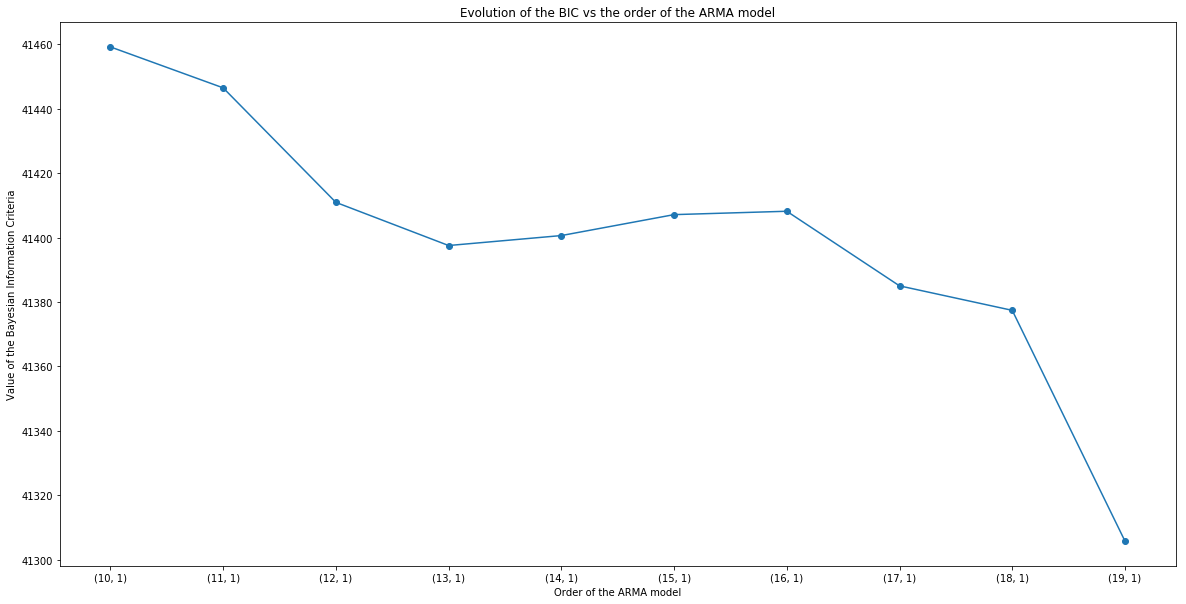

Lowest BIC obtained for order (19, 1)
Order (5, 0)
Order (6, 0)
Order (7, 0)
Order (8, 0)
Order (9, 0)
Order (10, 0)


C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:587: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:587: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


Algorithm could not converge for order (10, 0)
Order (11, 0)
Algorithm could not converge for order (11, 0)
Order (12, 0)


C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Order (13, 0)
Order (14, 0)
Order (15, 0)
Order (16, 0)
Order (17, 0)
Order (18, 0)
Order (19, 0)


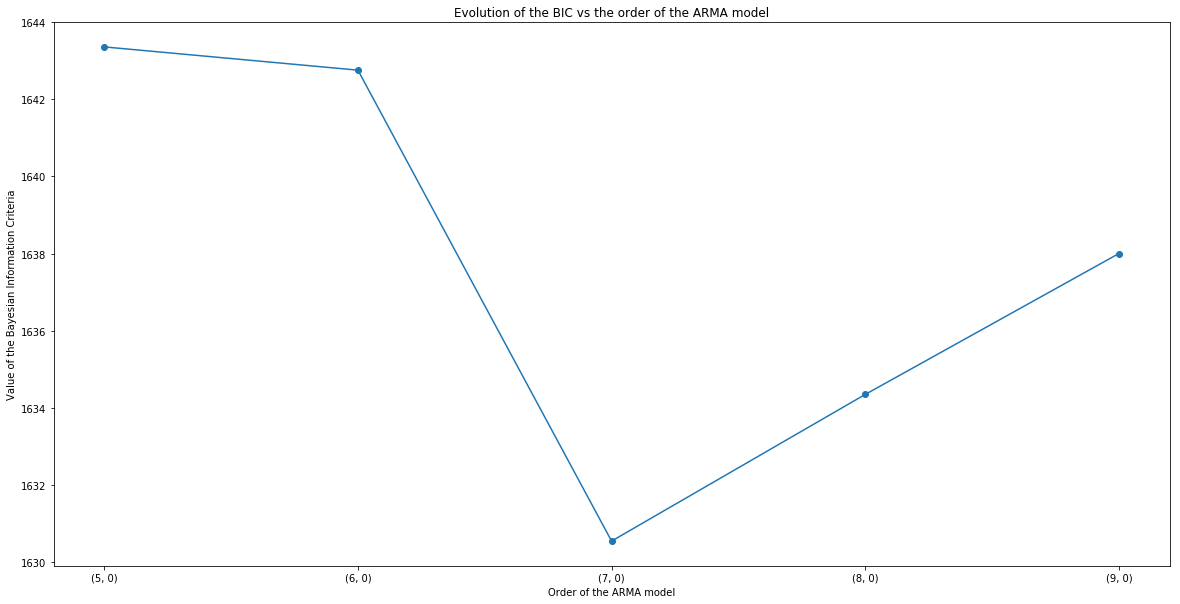

Lowest BIC obtained for order (10, 0)
Wall time: 1h 31min 51s


In [248]:
%%time

#Get the proper order for he ARMA model for the hourly values time series
#plot_BIC(ts_hourly_diff, A=range(8, 15), M=[1])

#Get the proper order for he ARMA model for the daily series
#plot_BIC(ts_daily_diff, A=range(10, 20), M=[1])

#Get the proper order for he ARMA model for the monthly series (don't converge for A=10)
plot_BIC(ts_monthly_diff, A=range(4, 13), M=[0])

#### Forecast

In [254]:
ts_hourly.tail()

Timestamp
2016-12-19 19:00:00    78660.549534
2016-12-19 20:00:00    81069.470956
2016-12-19 21:00:00    81532.725076
2016-12-19 22:00:00    78845.851181
2016-12-19 23:00:00    70877.880322
Freq: H, Name: Value, dtype: float64

C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                34751
Model:                ARIMA(25, 1, 1)   Log Likelihood             -353137.321
Method:                       css-mle   S.D. of innovations           6266.007
Date:                Mon, 21 May 2018   AIC                         706330.642
Time:                        11:05:29   BIC                         706567.409
Sample:                    01-02-2013   HQIC                        706406.083
                         - 12-19-2016                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.1333     28.930     -0.005      0.996     -56.834      56.567
ar.L1.D.Value      0.9523      0.015     63.206      0.000       0.923       0.982
ar.L2.D.Value     -0.1681      0.010

C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


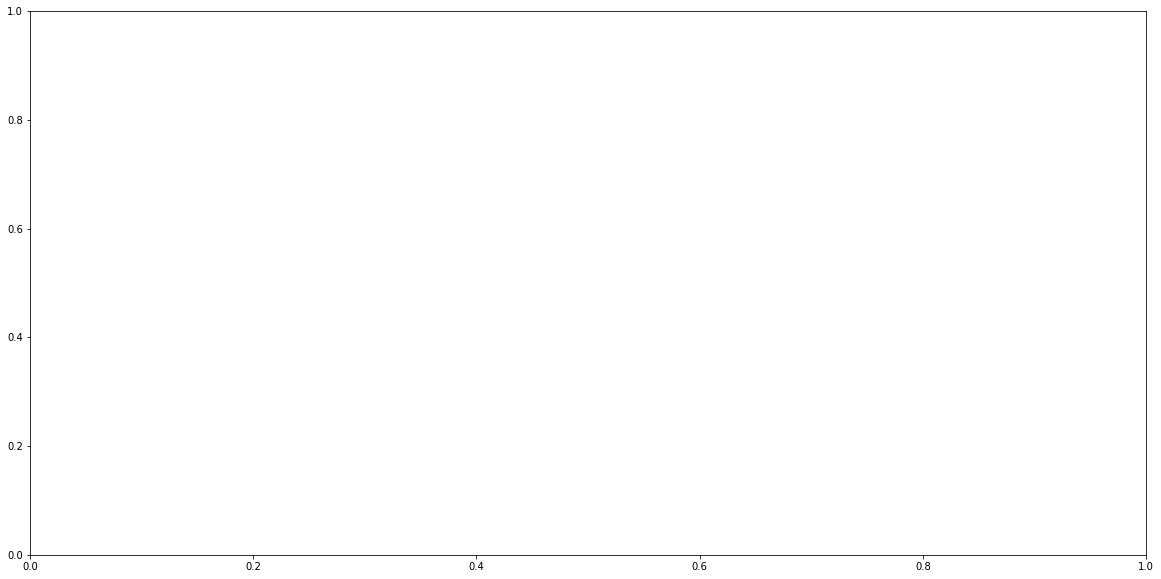

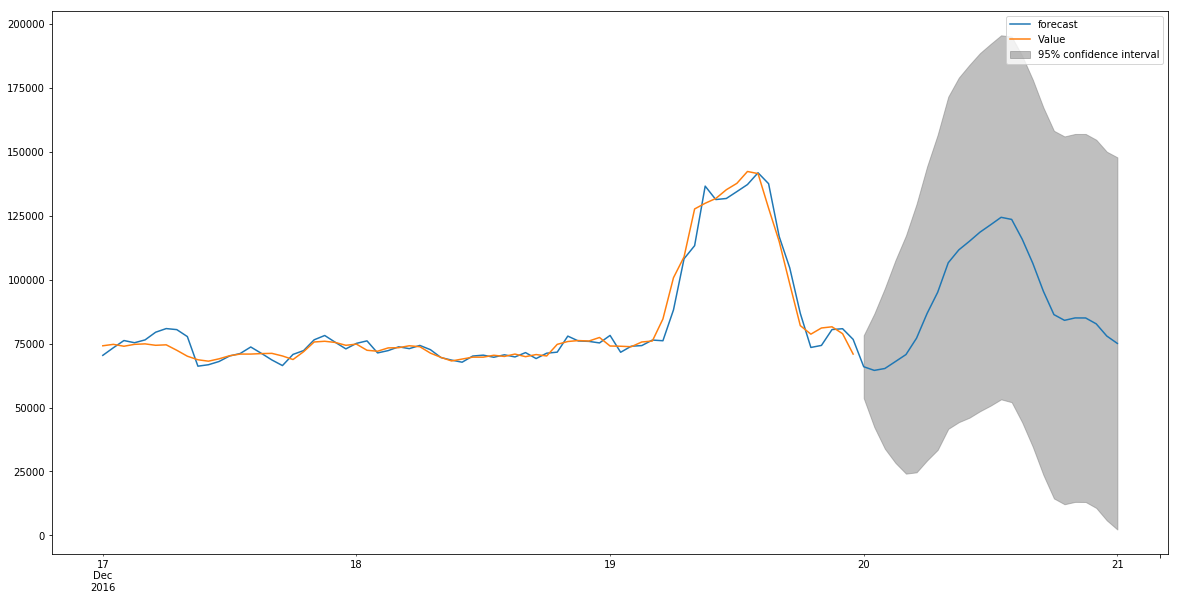

Wall time: 5h 1min 58s


In [255]:
%%time

#Fit the ARMA model to the hourly data
model = ARIMA(ts_hourly, order=(25,1,1))
result = model.fit()
print(result.summary())

#Forecast over January 2018
result.plot_predict(start='2016-12-17 00:00:00', end='2016-12-21 00:00:00')
plt.savefig('forecast/buidling6_hourly.png')
plt.show()

C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 1447
Model:                ARIMA(27, 1, 1)   Log Likelihood              -20471.792
Method:                       css-mle   S.D. of innovations         336118.348
Date:                Sun, 20 May 2018   AIC                          41003.584
Time:                        18:12:34   BIC                          41161.901
Sample:                    01-03-2013   HQIC                         41062.669
                         - 12-19-2016                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             46.9972   1223.476      0.038      0.969   -2350.972    2444.966
ar.L1.D.Value     -0.7123      0.100     -7.105      0.000      -0.909      -0.516
ar.L2.D.Value     -0.7470      0.056

C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


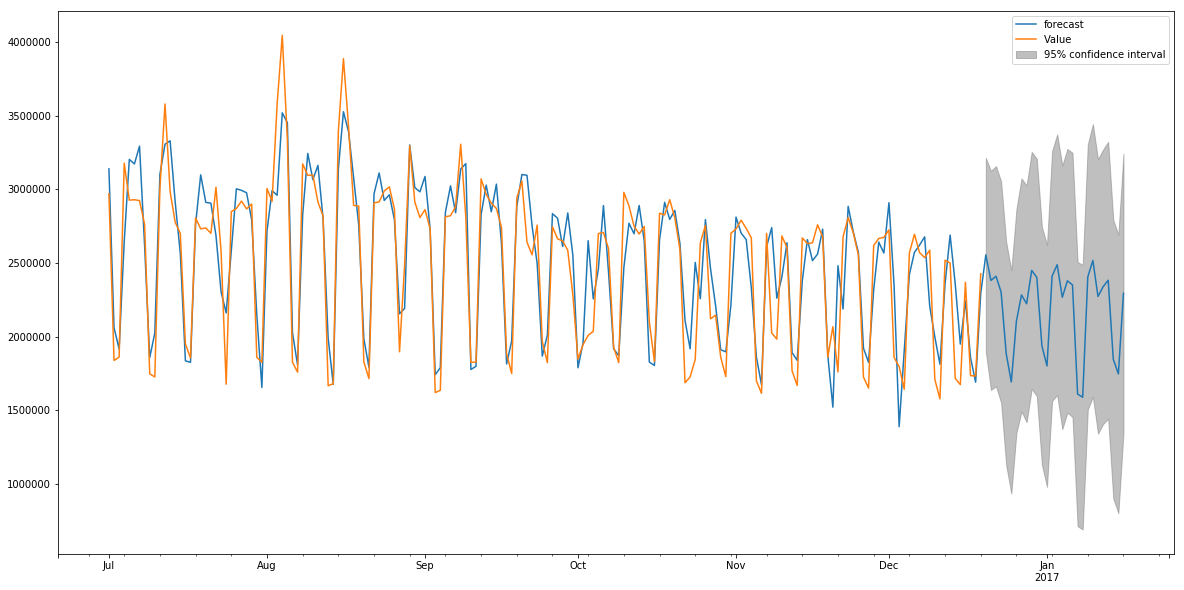

Wall time: 2h 55min 34s


In [252]:
%%time

#Fit the ARIMA model to the daily data
model = ARIMA(ts_daily, order=(27,1,1))
result = model.fit()
print(result.summary())

#Forecast over January 2018
result.plot_predict(start='2016-07-01', end='2017-01-16')
plt.savefig('forecast/buidling6_daily.png')
plt.show()

C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


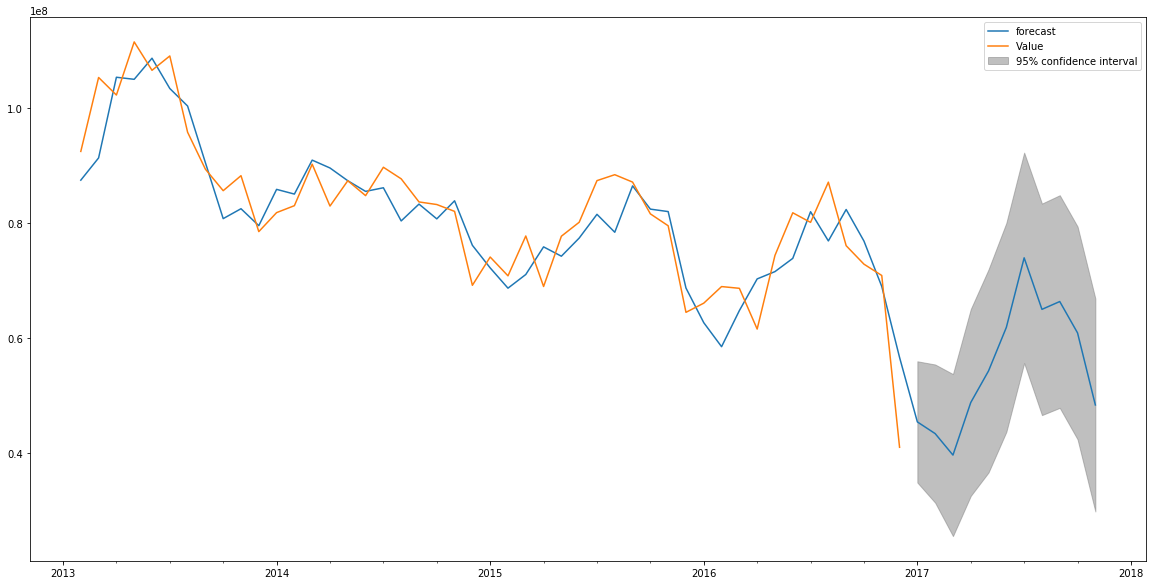

Wall time: 5.22 s


In [251]:
%%time

#Fit the ARIMA model to the monthly data
model = ARIMA(ts_monthly, order=(7,1,0))
result = model.fit()
#print(result.summary())

#Forecast over January 2018
result.plot_predict(start=0, end='2017-12')
plt.savefig('forecast/buidling6_monthly.png')
plt.show()

#### Building 269

                     Temperature       Value  Value_Return  \
Timestamp                                                    
2013-05-31 00:15:00        19.00  283.887071     -0.016667   
2013-05-31 00:30:00        19.25  283.887071      0.000000   
2013-05-31 00:45:00        19.50  283.887071      0.000000   
2013-05-31 01:00:00        18.25  293.510361      0.033898   
2013-05-31 01:15:00        17.00  312.756942      0.065574   

                     Temperature_Return  Value_Diff  Temperature_Diff  
Timestamp                                                              
2013-05-31 00:15:00           -0.037975   -4.811645             -0.75  
2013-05-31 00:30:00            0.013158    0.000000              0.25  
2013-05-31 00:45:00            0.012987    0.000000              0.25  
2013-05-31 01:00:00           -0.064103    9.623291             -1.25  
2013-05-31 01:15:00           -0.068493   19.246581             -1.25  

Autocorrelation of the original timeseries:  0.9841437154625

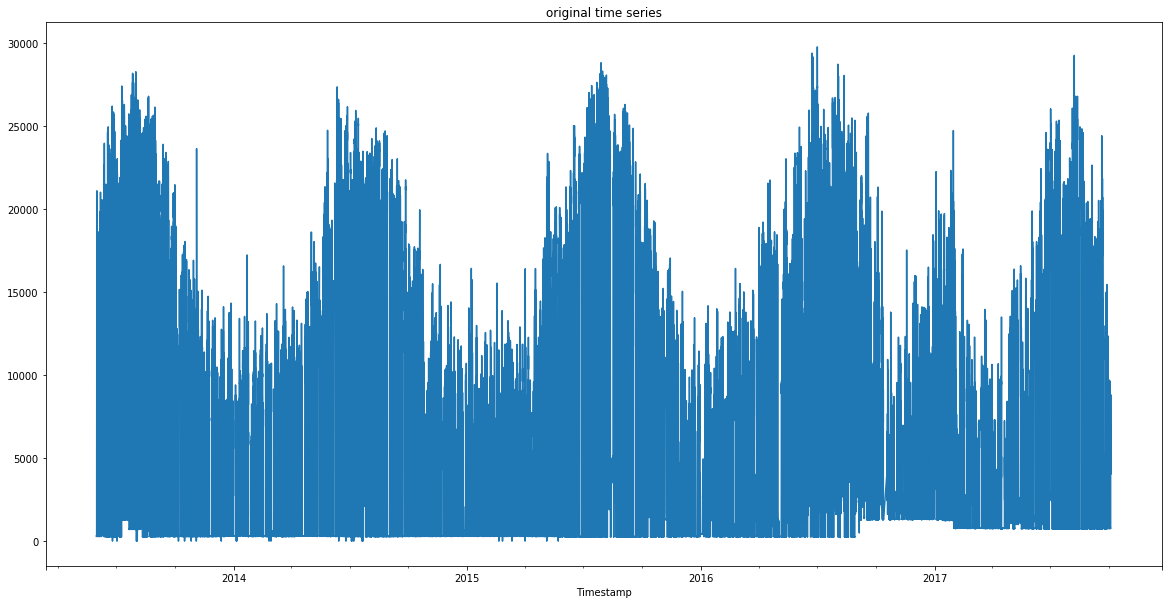

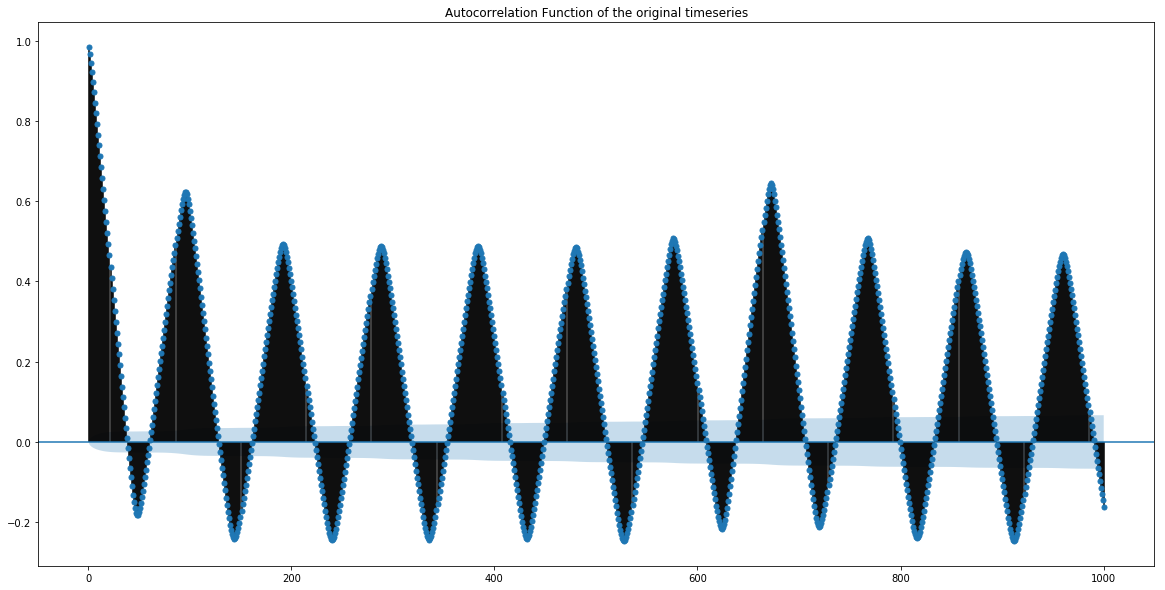

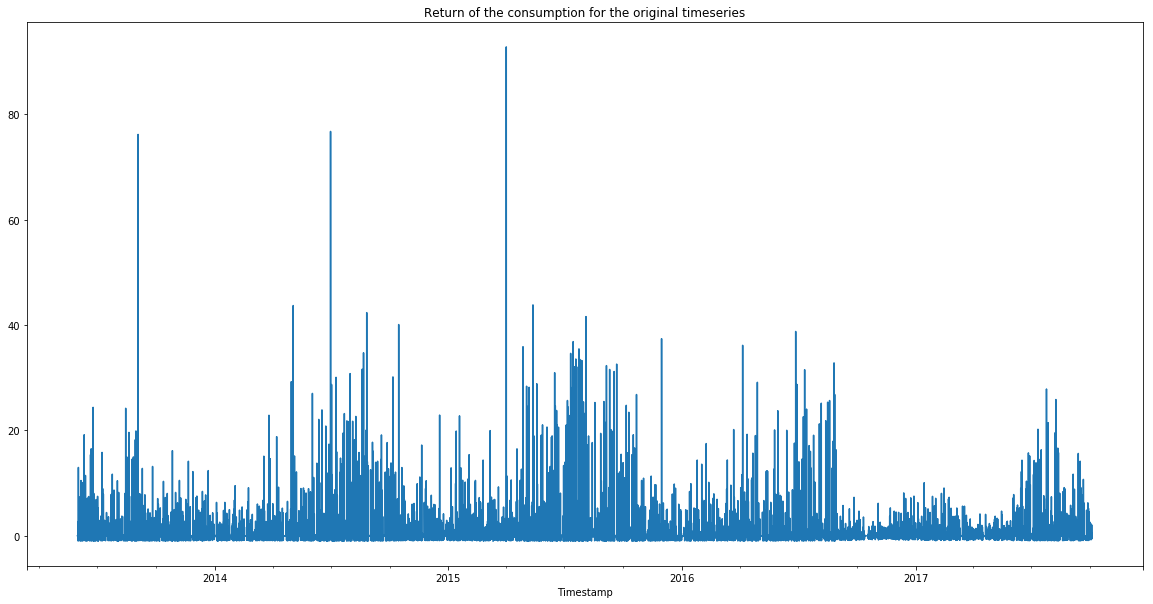

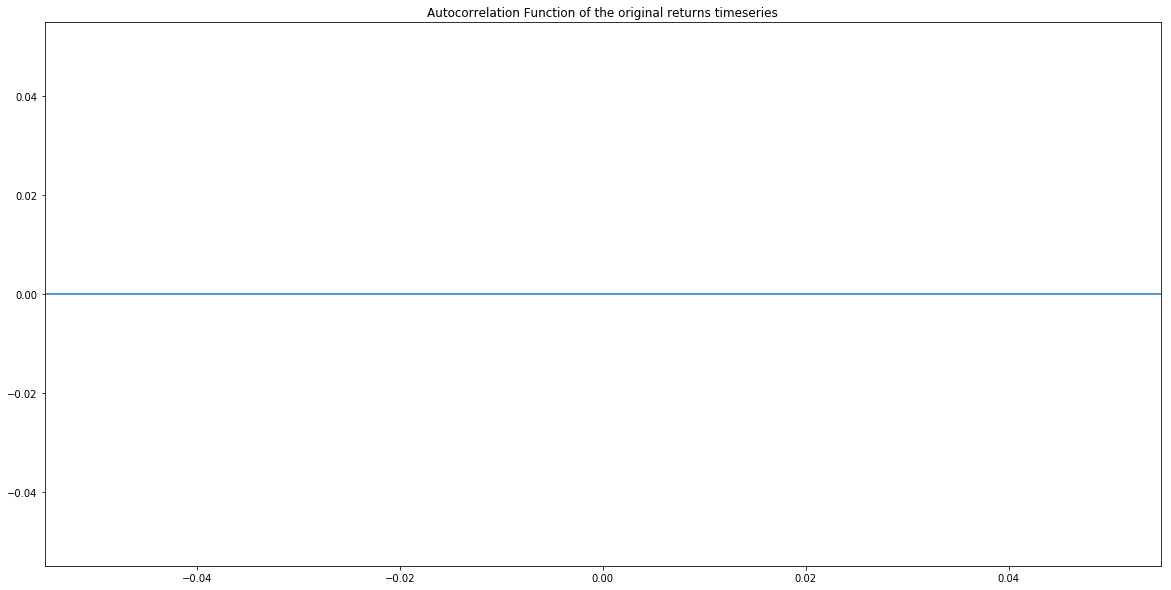

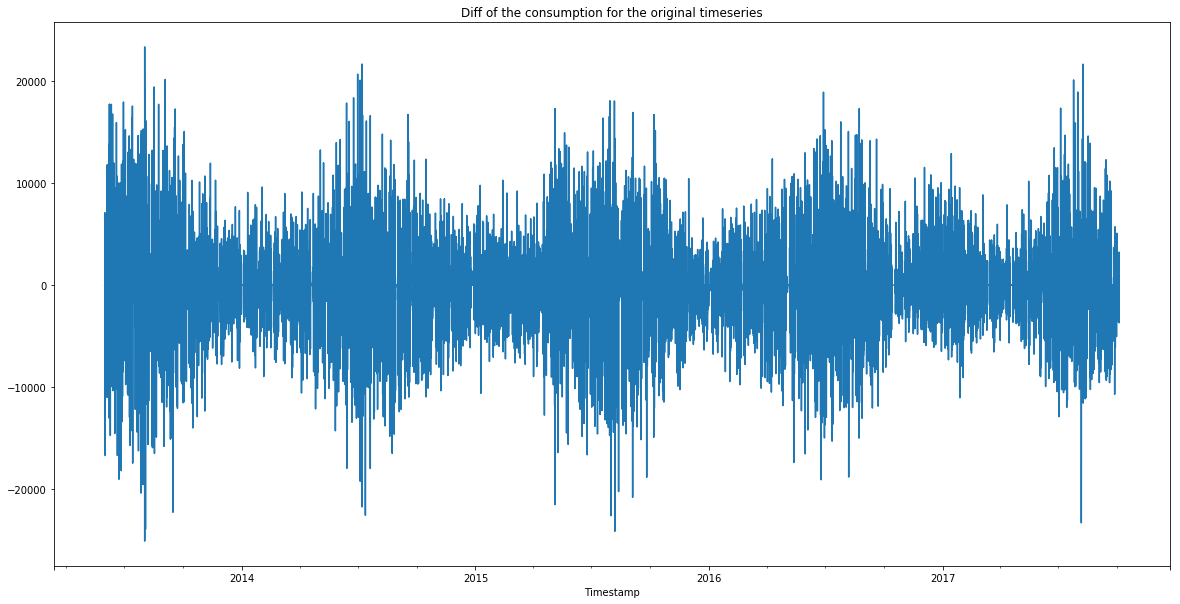

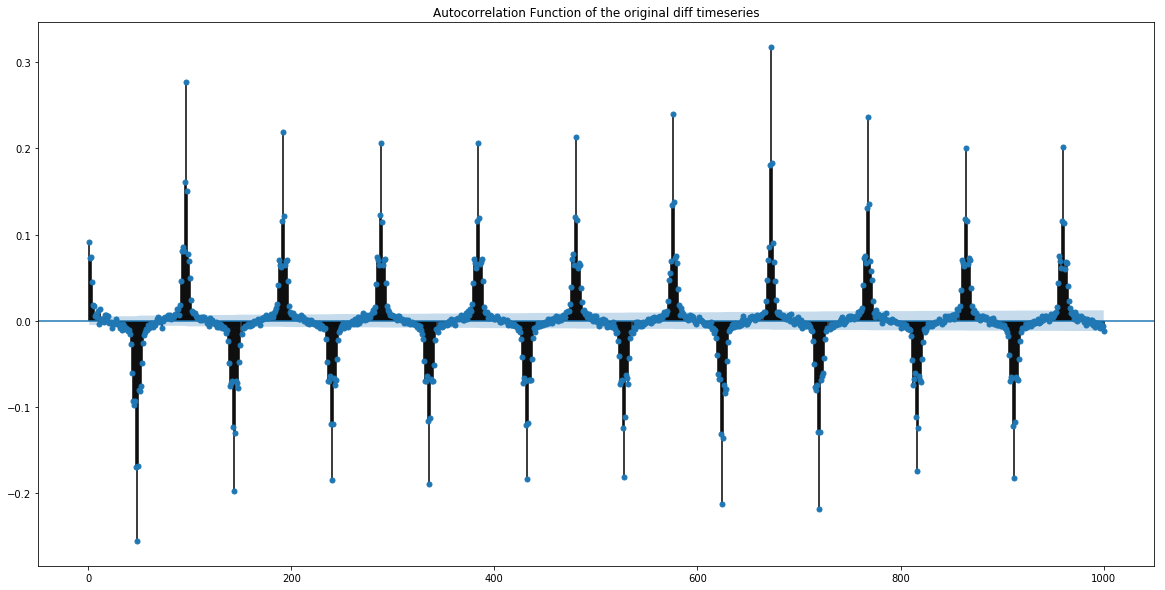


Autocorrelation of the hourly timeseries:  0.9361263554965457
NaN values:  0
Length of resampled series:  38088


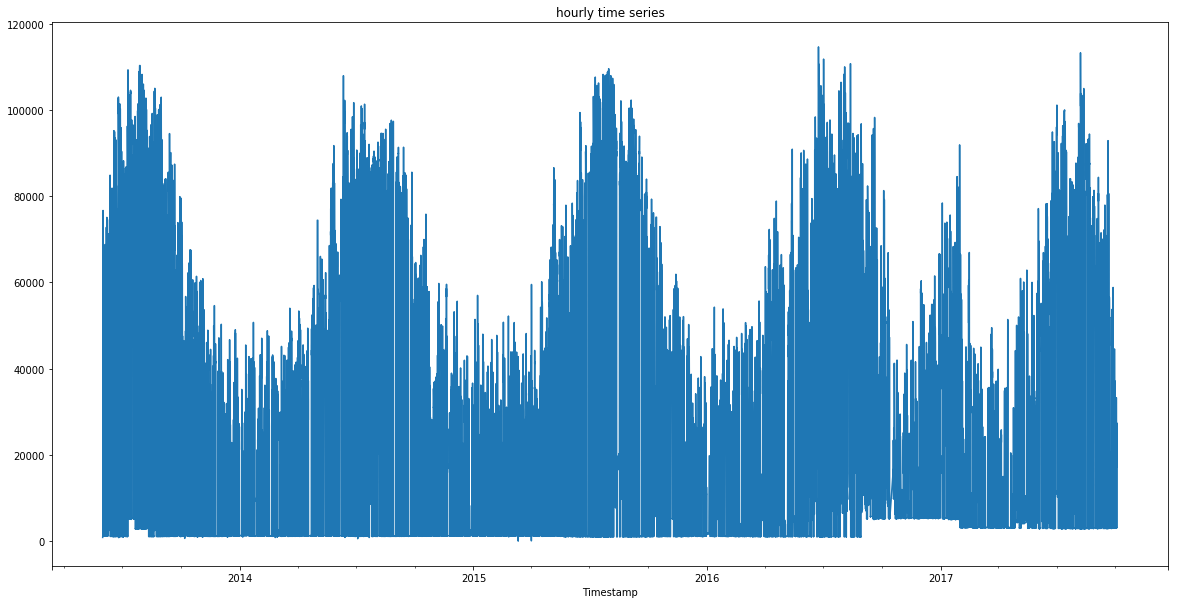

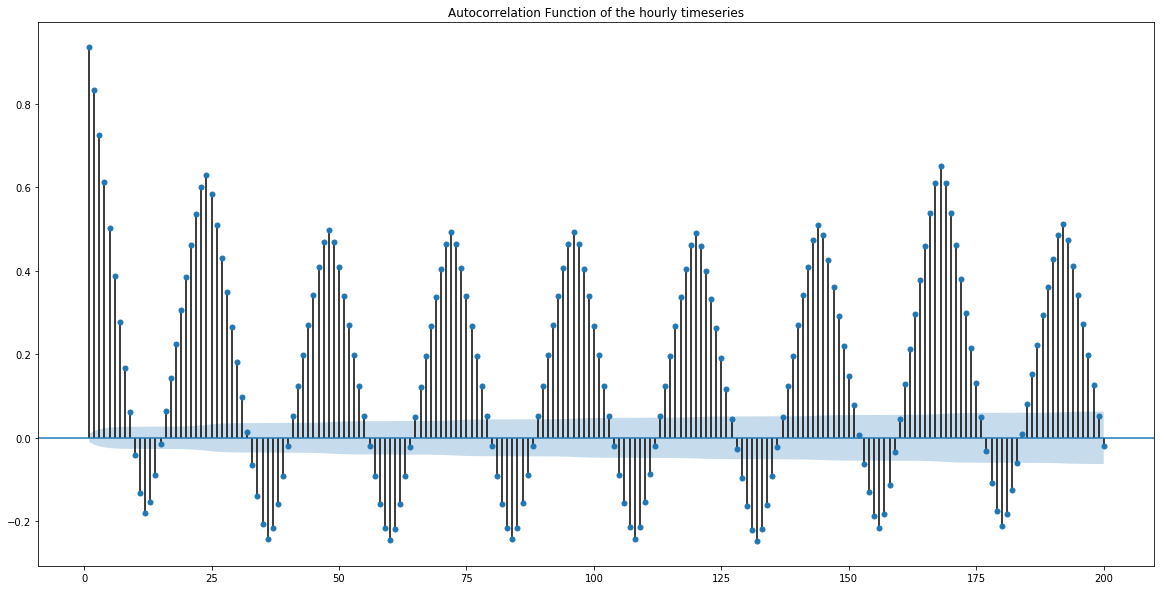

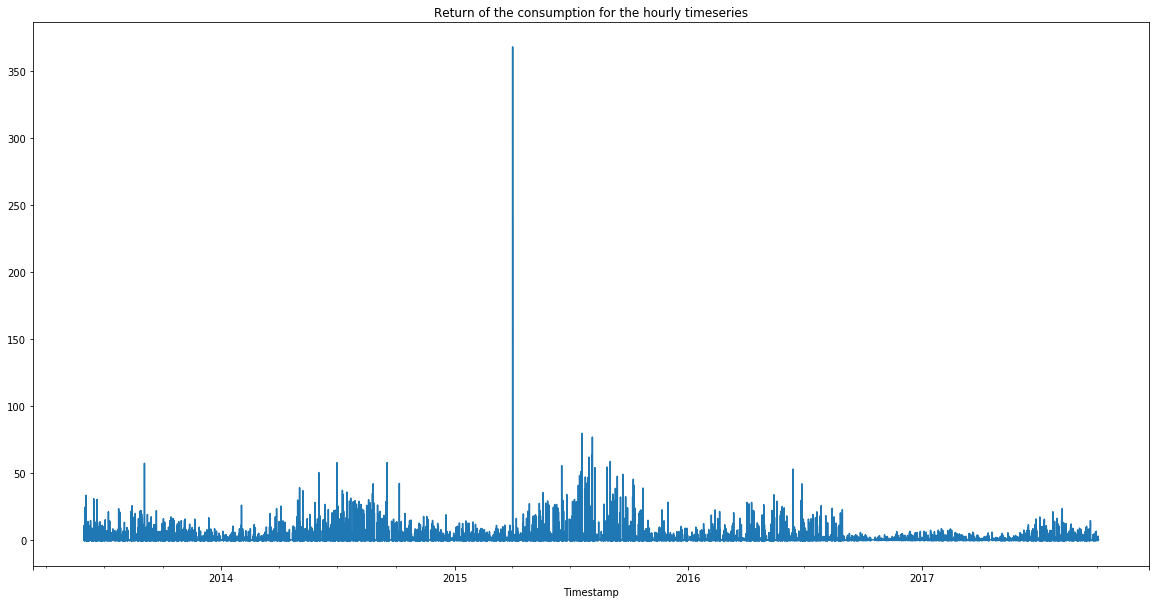

C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:353: RuntimeWarning: invalid value encountered in subtract
  xo = x - x.mean()


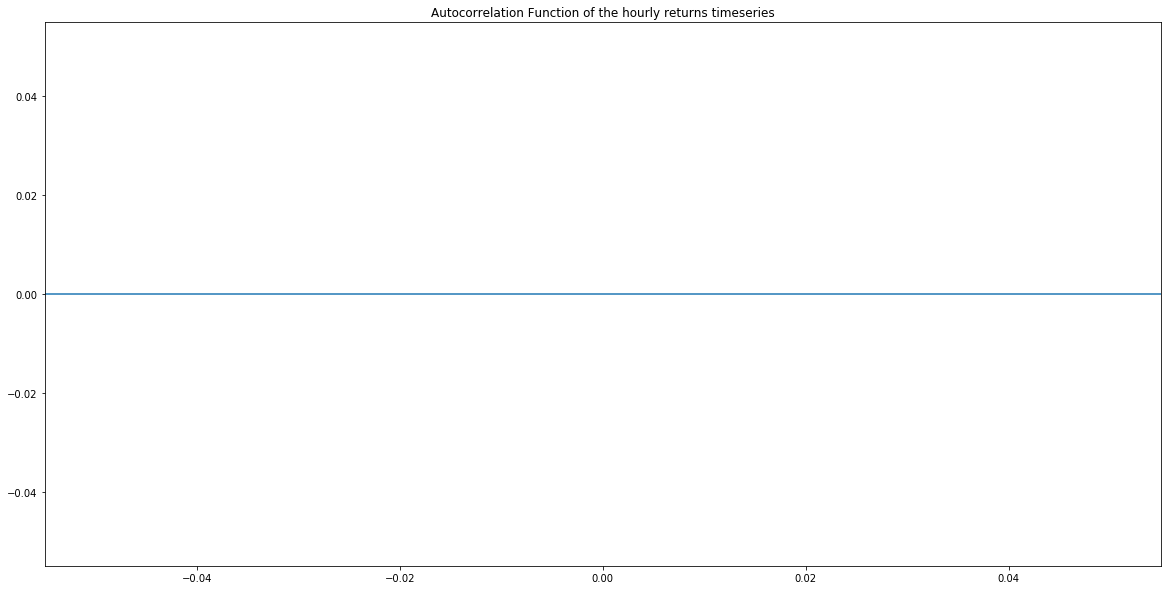

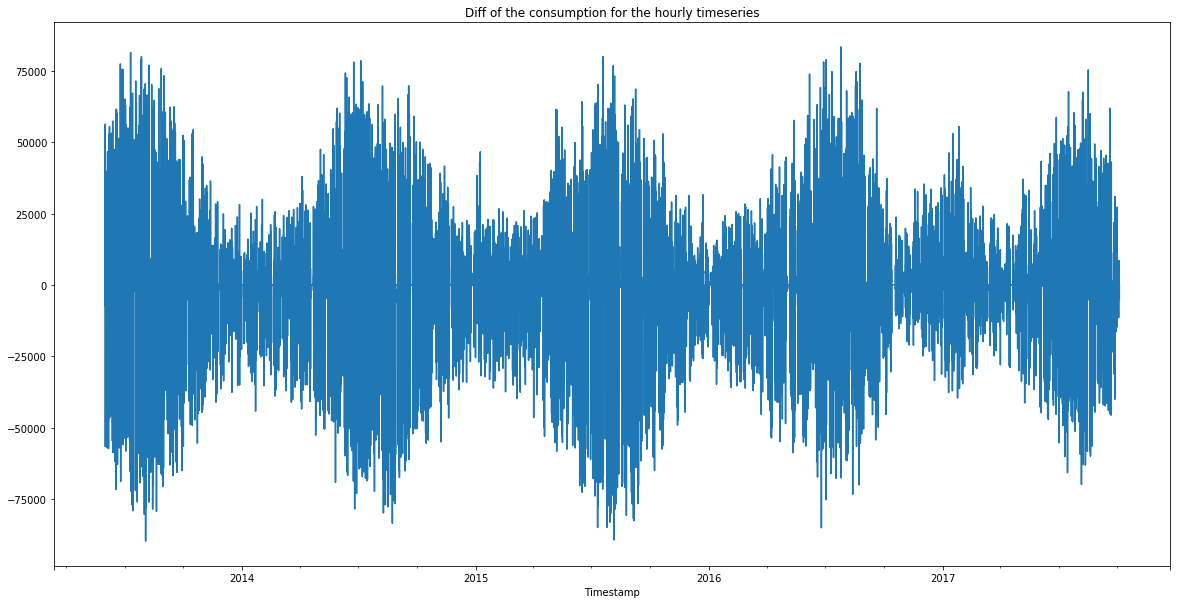

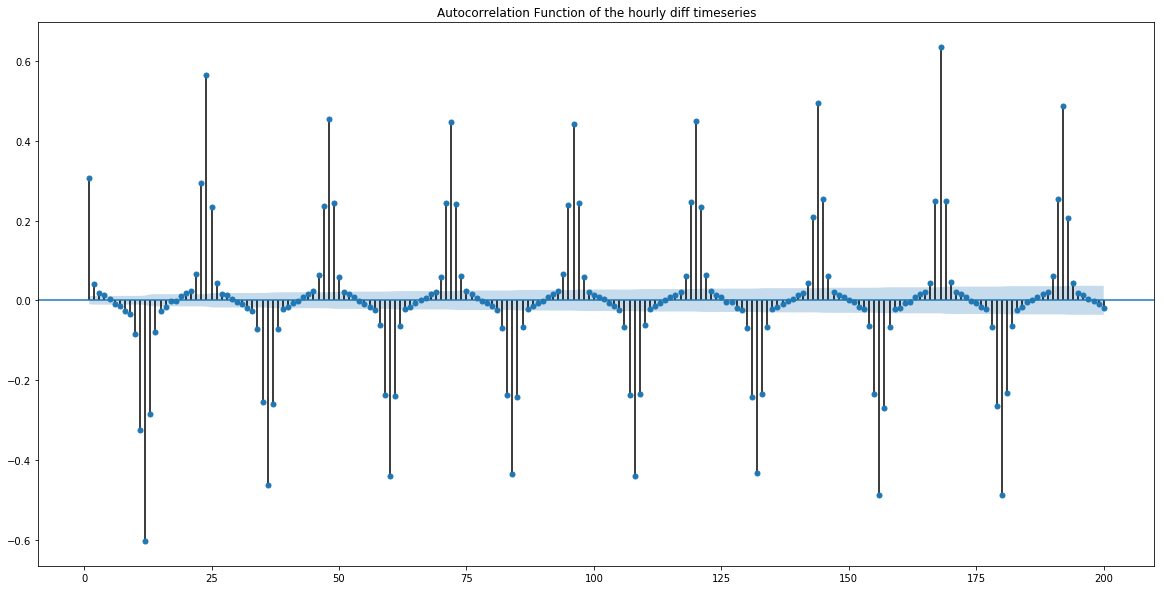


Autocorrelation of the daily timeseries:  0.55026356786994
NaN values:  0
Length of resampled series:  1587


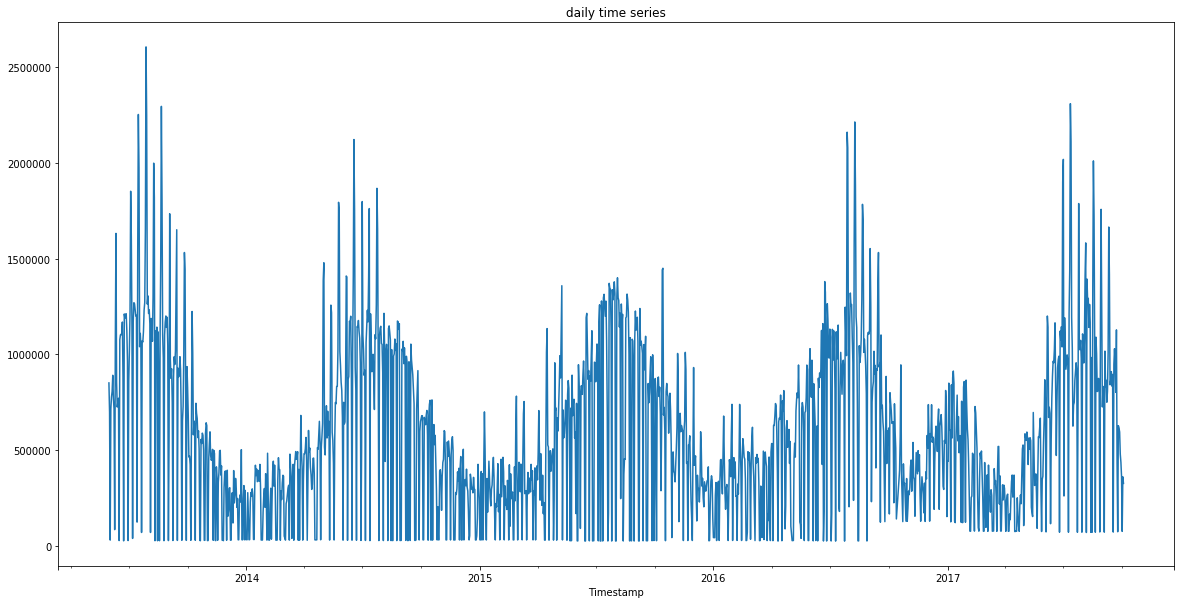

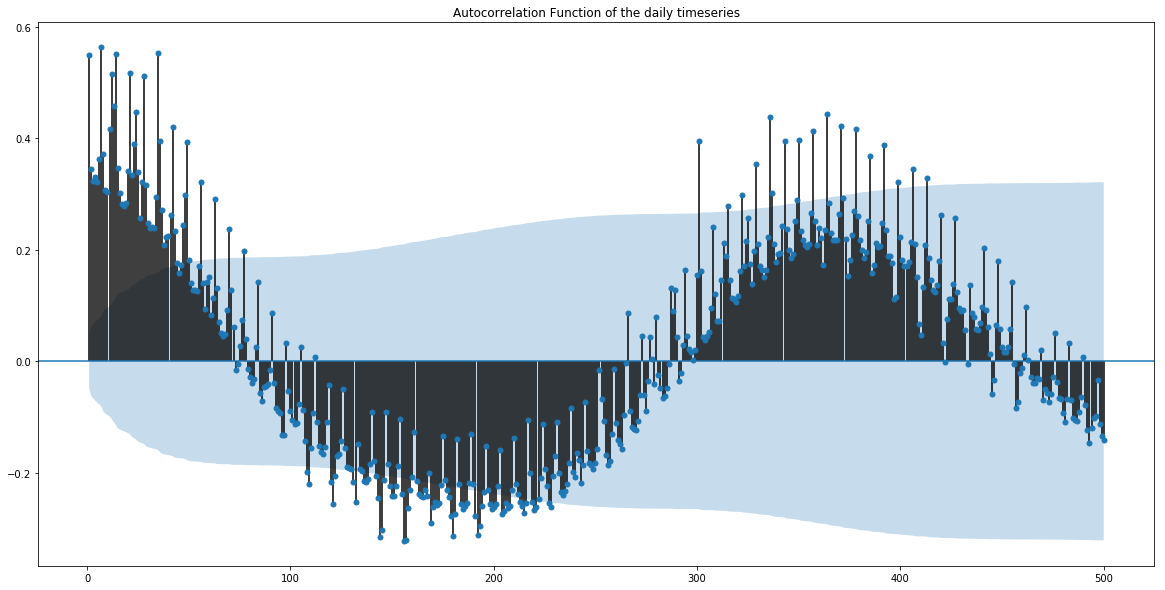

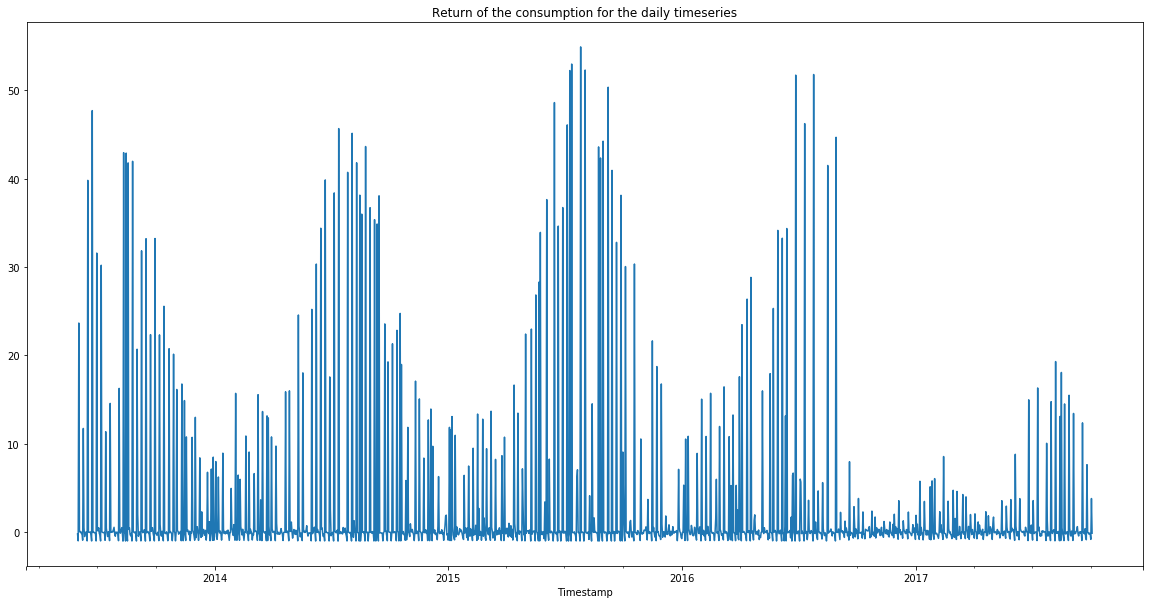

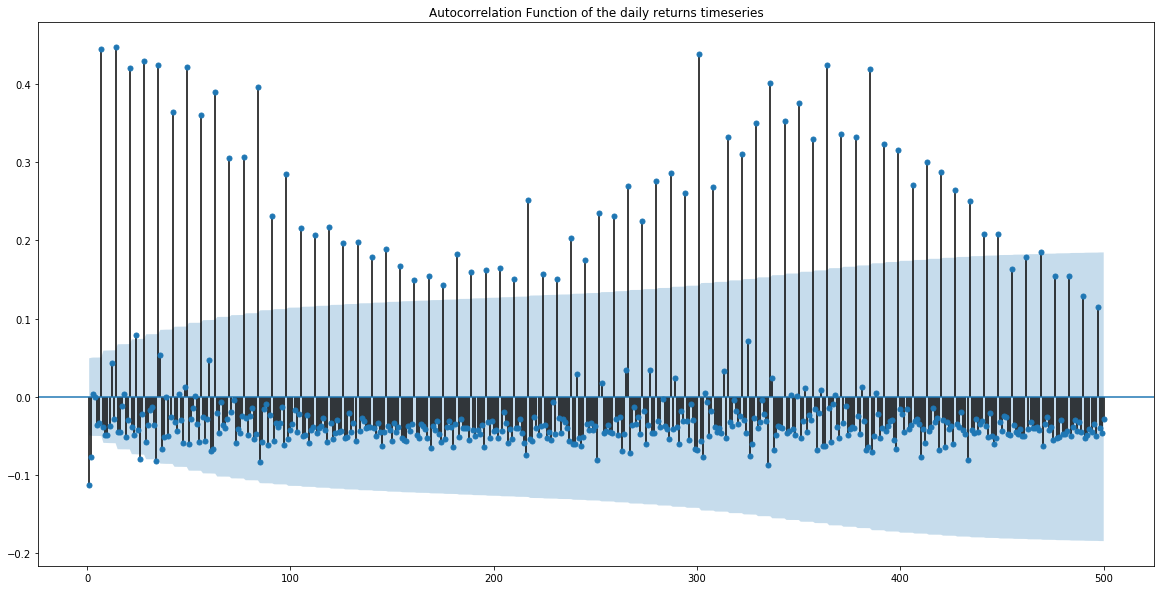

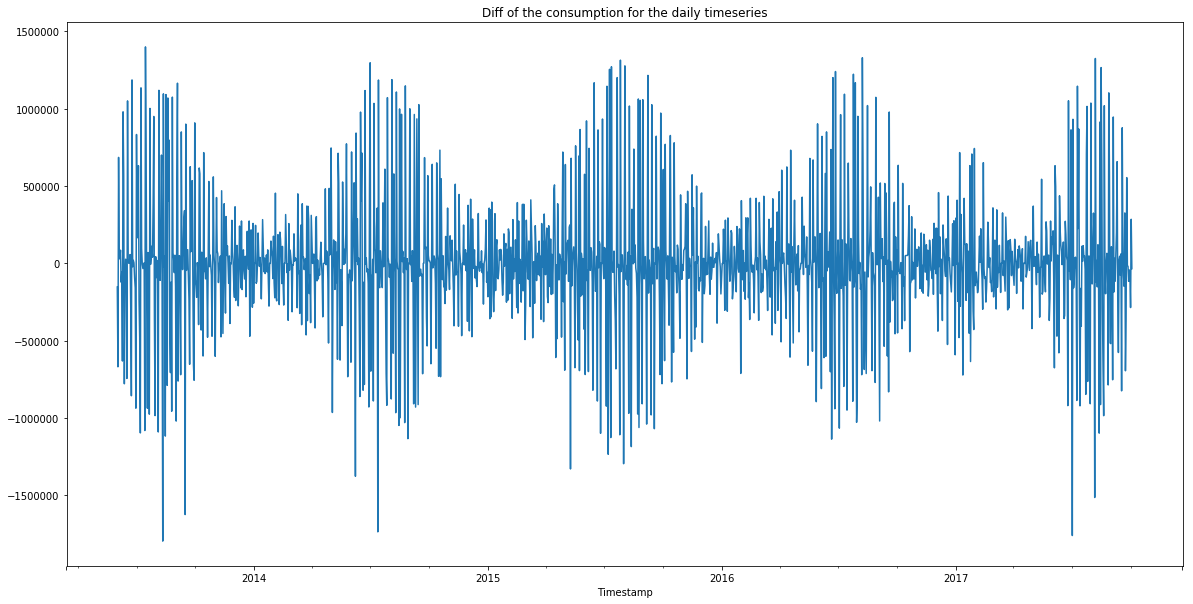

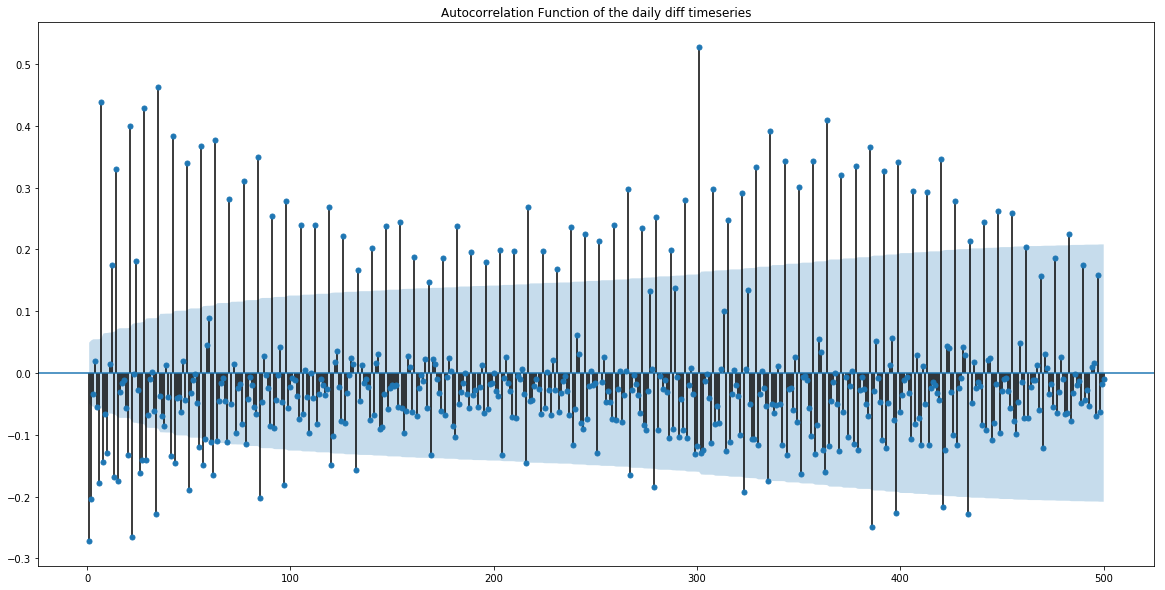


Autocorrelation of the weekly timeseries:  0.8036641947386514
NaN values:  0
Length of resampled series:  228


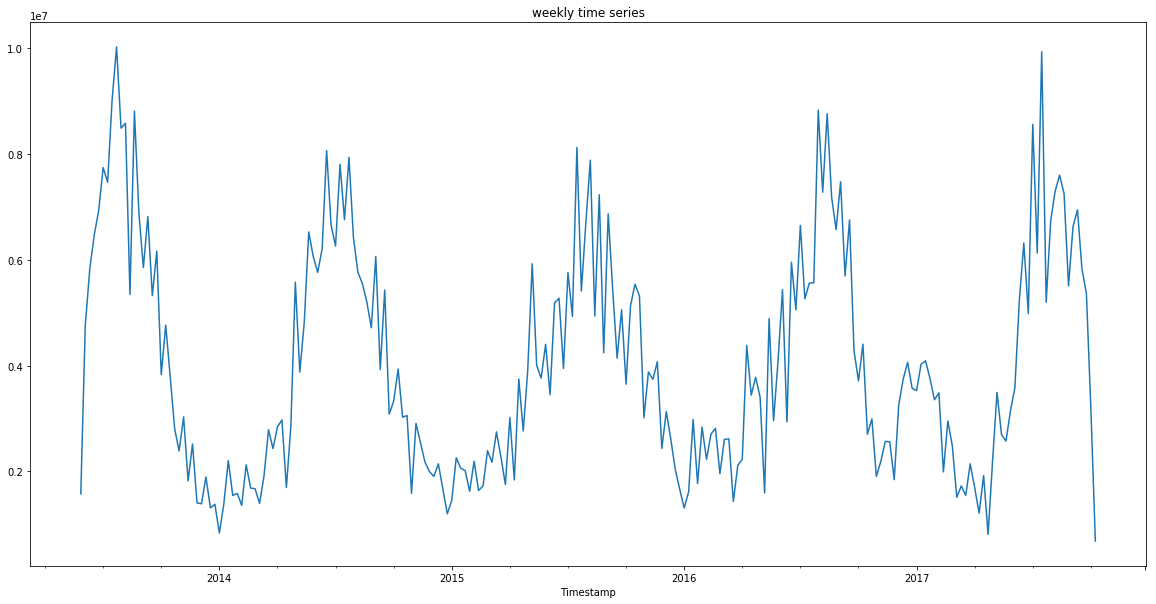

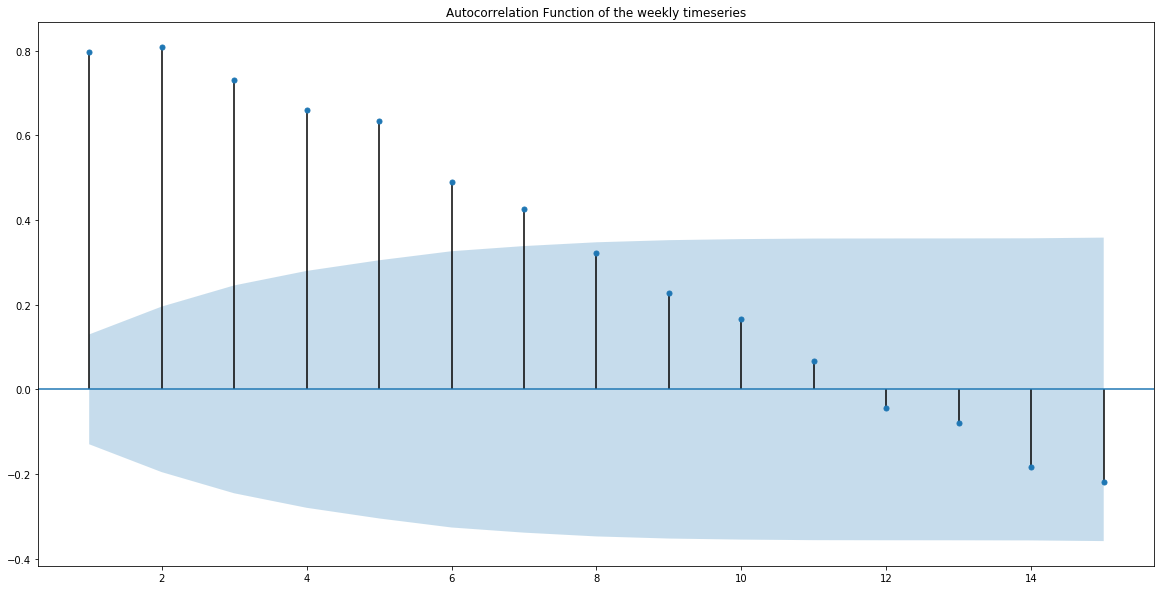

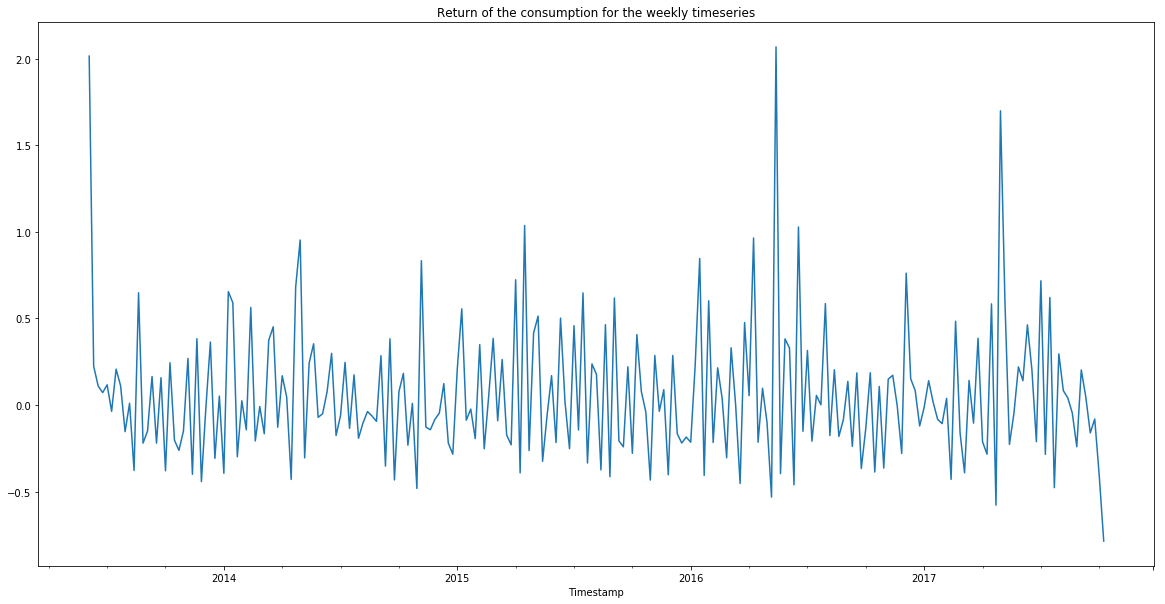

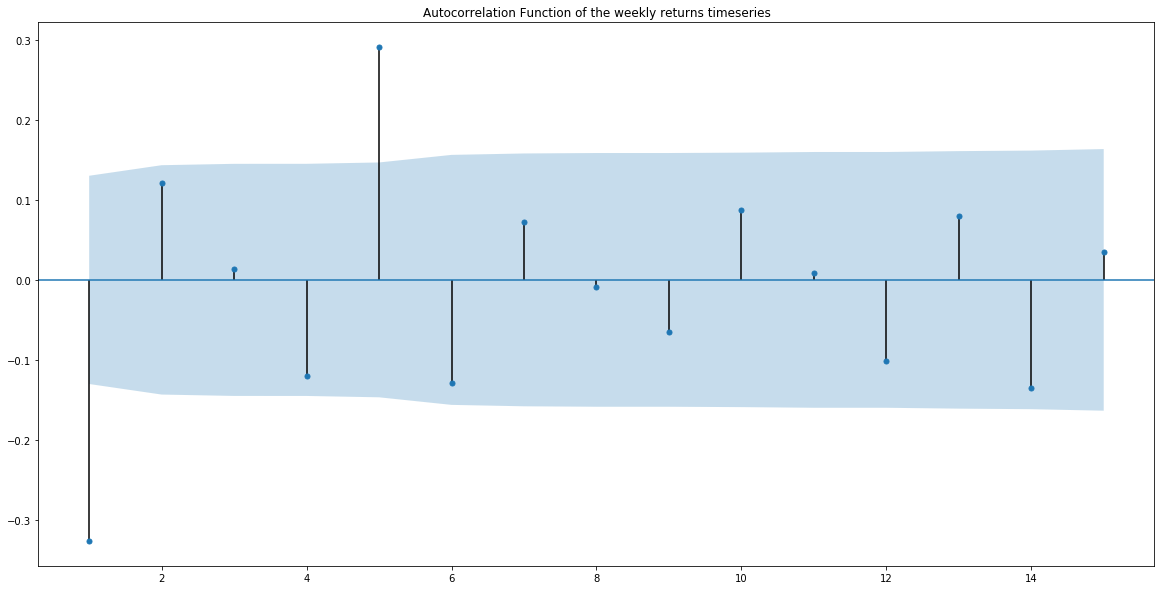

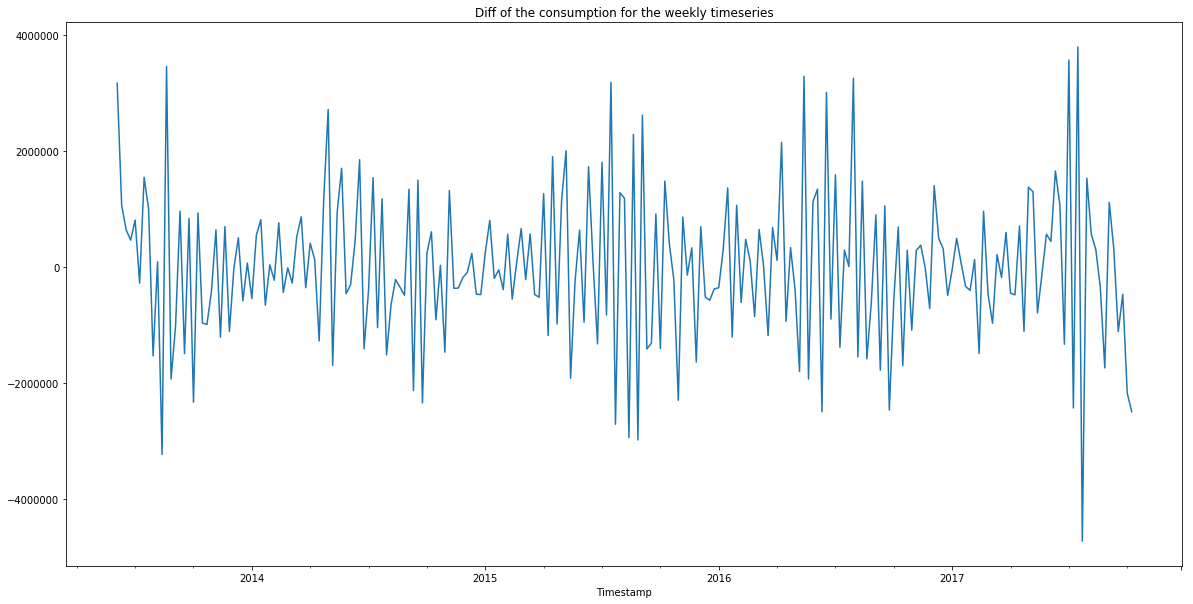

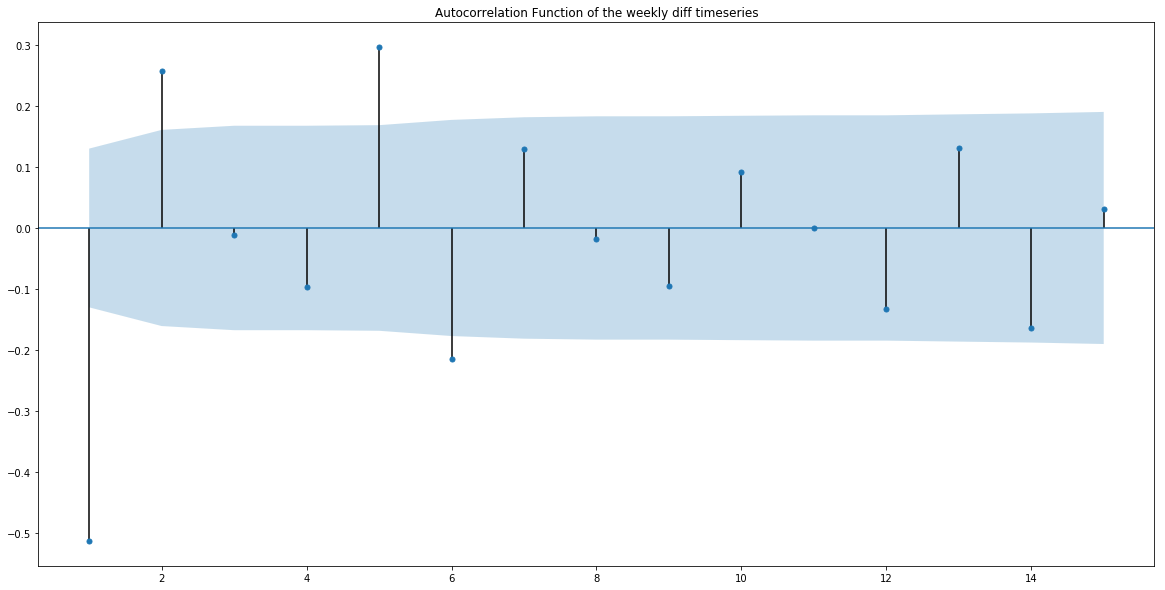


Autocorrelation of the monthly timeseries:  0.6583396023506788
NaN values:  0
Length of resampled series:  54


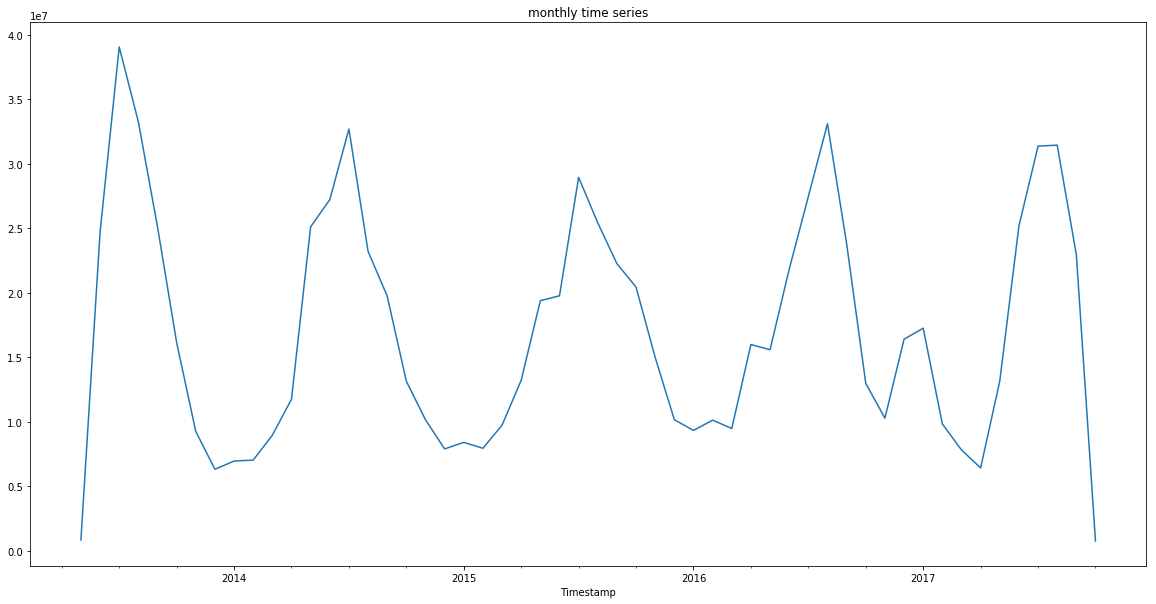

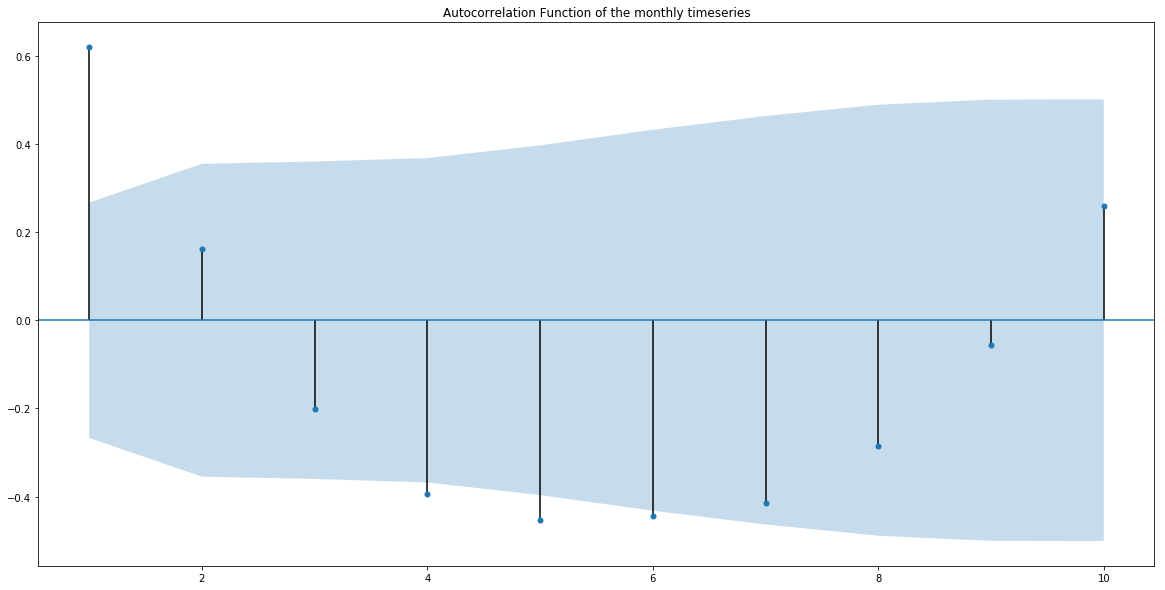

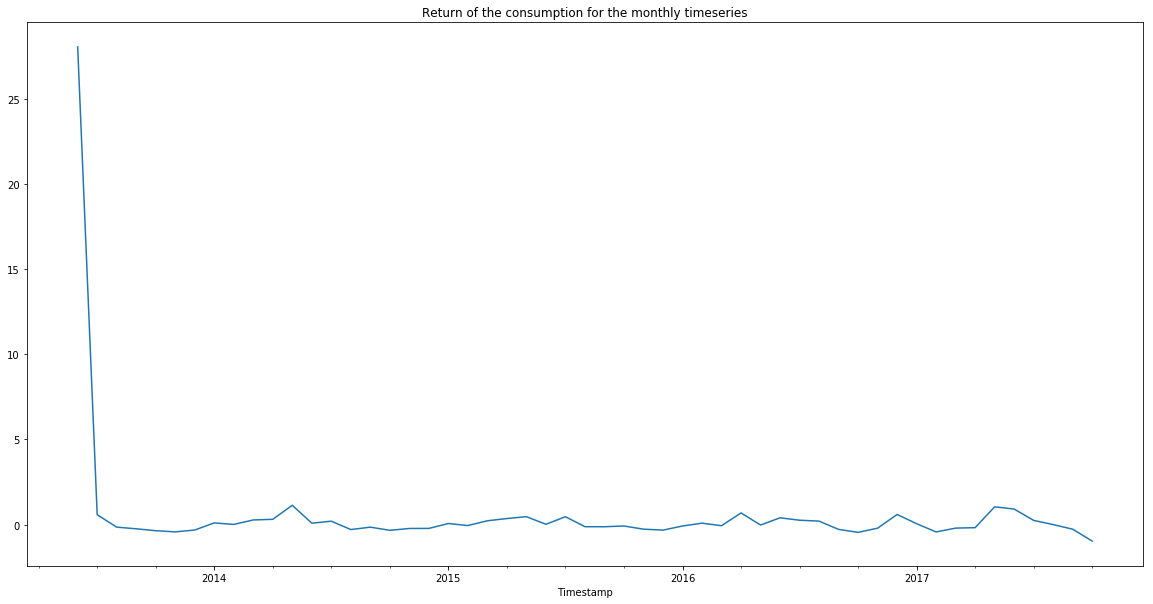

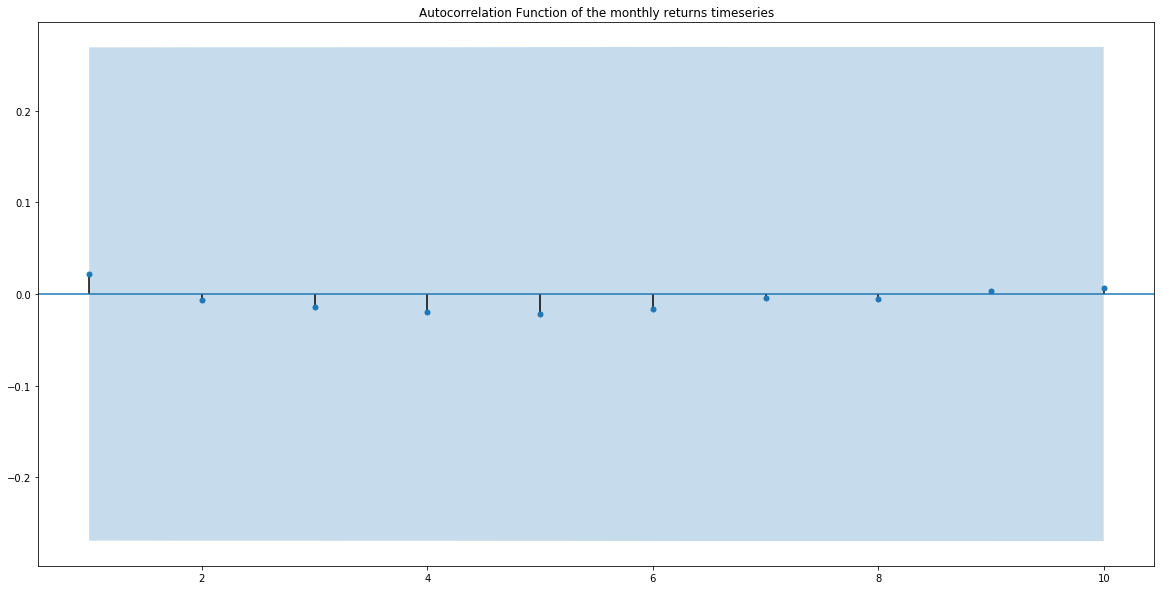

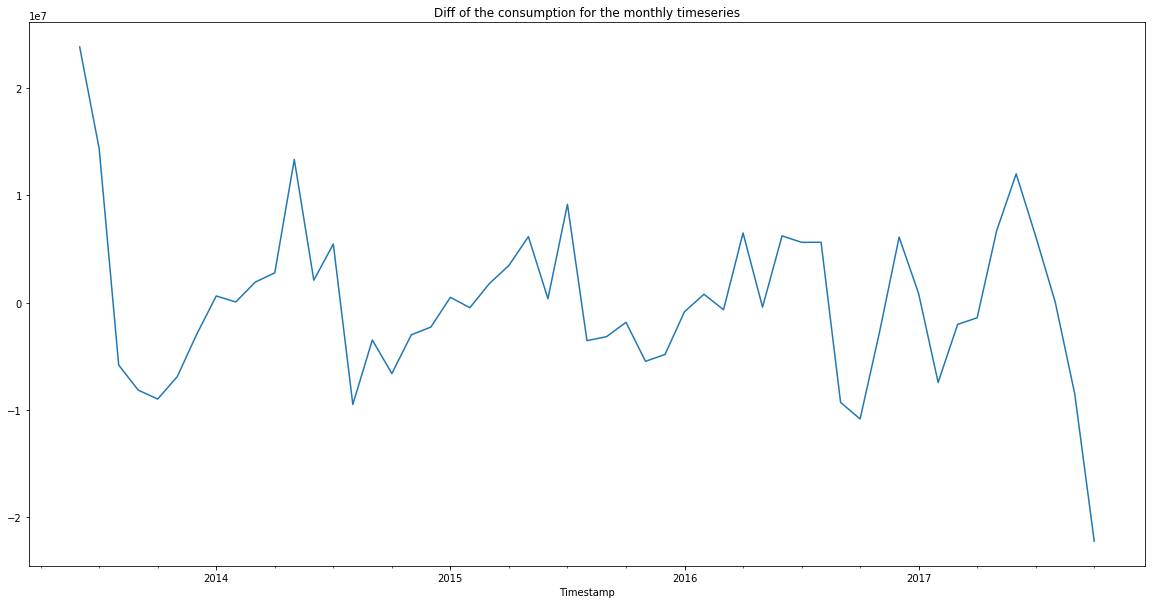

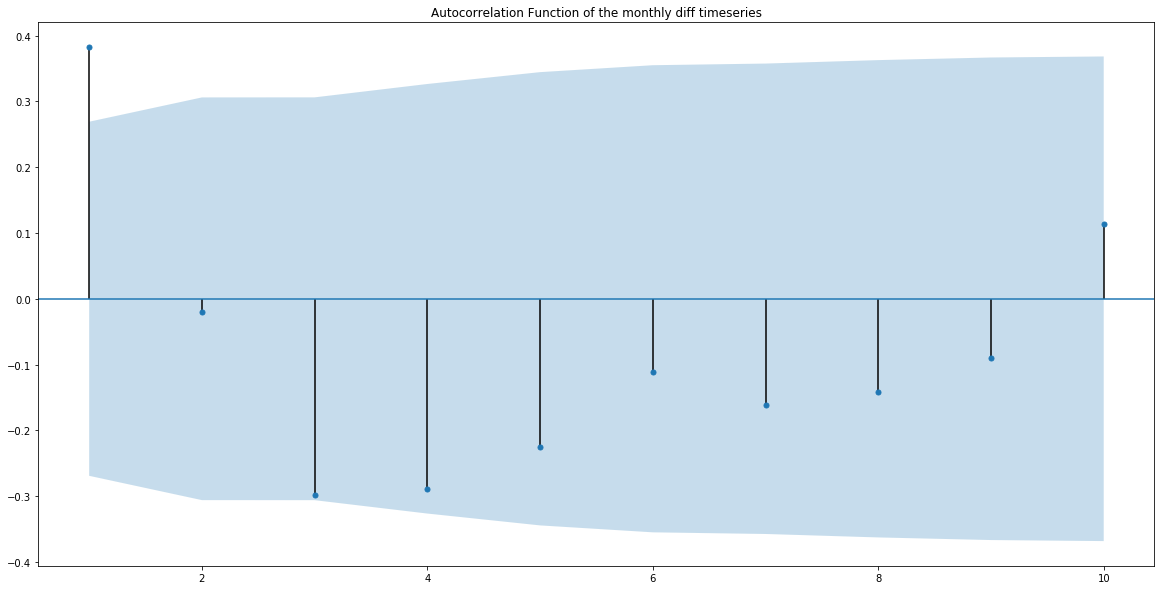

(Timestamp
 2013-05-31 00:00:00      851.661213
 2013-05-31 01:00:00     1236.592834
 2013-05-31 02:00:00     1265.462706
 2013-05-31 03:00:00     1270.274351
 2013-05-31 04:00:00     1265.462706
 2013-05-31 05:00:00     1255.839415
 2013-05-31 06:00:00     1265.462706
 2013-05-31 07:00:00     1255.839415
 2013-05-31 08:00:00     5268.751569
 2013-05-31 09:00:00    61545.754630
 2013-05-31 10:00:00    54328.286728
 2013-05-31 11:00:00    56565.701777
 2013-05-31 12:00:00    60679.658482
 2013-05-31 13:00:00    60597.860512
 2013-05-31 14:00:00    70567.589509
 2013-05-31 15:00:00    76697.625581
 2013-05-31 16:00:00    75817.094497
 2013-05-31 17:00:00    75475.467683
 2013-05-31 18:00:00    74084.902200
 2013-05-31 19:00:00    74330.296109
 2013-05-31 20:00:00    74421.717369
 2013-05-31 21:00:00    17812.710784
 2013-05-31 22:00:00     1145.171574
 2013-05-31 23:00:00     1149.983219
 2013-06-01 00:00:00     1154.794864
 2013-06-01 01:00:00     1236.592834
 2013-06-01 02:00:00     12

In [117]:
#Load the timeseries dataframe of the building 269
timeseries = pd.read_csv('timeseries_269_DB.csv', parse_dates=[0], index_col=0)
print(timeseries.head())

#Get ACF function of the consumption (Value)
ts_hourly, ts_daily, ts_weekly, ts_monthly = get_acf(timeseries['Value'], 
                                                     method='sum', alpha=0.05, Return=True, Diff=True)

---

### LSTM Neural Network
The Long Short Term Memory recurrent network is used here to analyse the consumption for the building 6 (1 feature).

In [5]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#### Data Preparation

                     Temperature         Value  Value_Return  \
Timestamp                                                      
2013-01-02 00:15:00         15.0  25177.861408     -0.000919   
2013-01-02 00:30:00         15.0  25154.698702     -0.000920   
2013-01-02 00:45:00         15.0  25177.861408      0.000921   
2013-01-02 01:00:00         15.0  25201.024114      0.000920   
2013-01-02 01:15:00         15.0  24946.234349     -0.010110   

                     Temperature_Return  Value_Diff  Temperature_Diff  
Timestamp                                                              
2013-01-02 00:15:00                 0.0  -23.162706               0.0  
2013-01-02 00:30:00                 0.0  -23.162706               0.0  
2013-01-02 00:45:00                 0.0   23.162706               0.0  
2013-01-02 01:00:00                 0.0   23.162706               0.0  
2013-01-02 01:15:00                 0.0 -254.789766               0.0                        Temperature         Value 

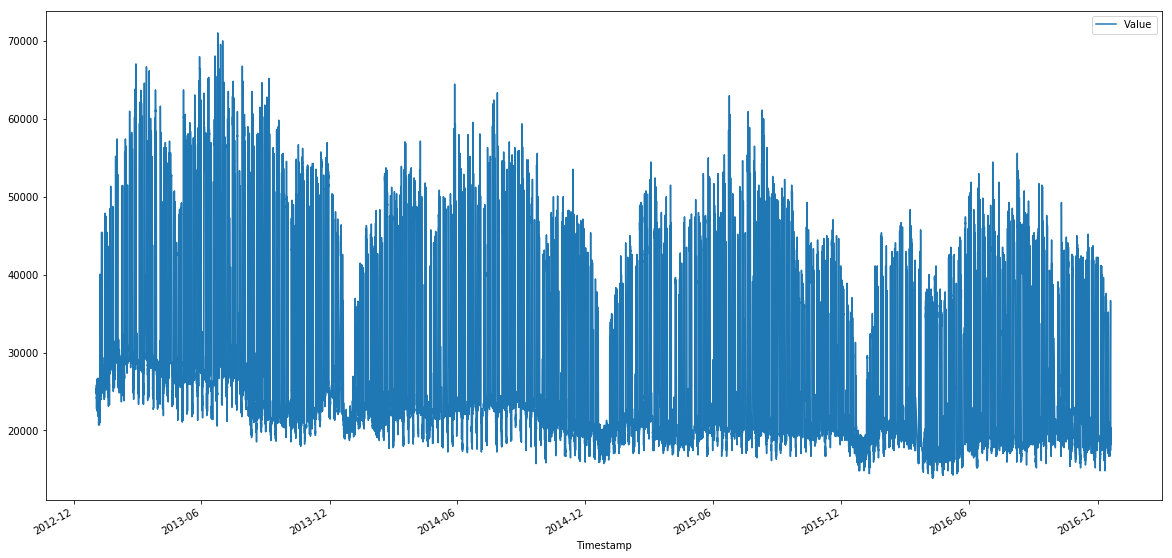

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 137696 entries, 2013-01-02 00:15:00 to 2016-12-19 23:45:00
Data columns (total 1 columns):
Value    137696 non-null float64
dtypes: float64(1)
memory usage: 2.1 MB
Timeseries Info: 
 None
                            Value         Value         Value         Value  \
Timestamp                                                                     
2013-01-02 00:15:00  25154.698702  25177.861408  25201.024114  24946.234349   
2013-01-02 00:30:00  25177.861408  25201.024114  24946.234349  24691.444583   
2013-01-02 00:45:00  25201.024114  24946.234349  24691.444583  24784.095407   
2013-01-02 01:00:00  24946.234349  24691.444583  24784.095407  24876.746231   
2013-01-02 01:15:00  24691.444583  24784.095407  24876.746231  25154.698702   

                            Value         Value         Value         Value  \
Timestamp                                                                     
2013-01-02 00:15:00  24691.444583  24784.095407

(123881, 49, 1) (123881, 1) (13765, 49, 1) (13765, 1)


In [6]:
#Load the timeseries dataframe of the building 6
timeseries = pd.read_csv('timeseries_6_DB.csv', parse_dates=[0], index_col=0)
print(timeseries.head(), timeseries.tail())
ts_values = timeseries.loc[:, ['Value']]

#Drop NaN values
ts_values.dropna(axis=0, inplace=True)

#Plot and display infos
ts_values.plot()
plt.show()
print("Timeseries Info: \n", ts_values.info())


#SHift the values to get the shifted time steps
ts_copy = ts_values.copy()
ts_shifted = pd.DataFrame()
for i in range(50):
    ts_shifted = pd.concat([ts_shifted, ts_copy.shift(-(i+1))], axis=1)
print(ts_shifted.head())
print(ts_shifted.tail())

#Drop NaN values at the tail of the dataframe
ts_shifted.dropna(axis=0, inplace=True)
print("Tail of the shifted time series after dropna()  :", ts_shifted.tail())

#Split between train and test sets (order of sequence must be kept)
train_size = int(len(ts_shifted) * 0.90)
ts_train, ts_test = ts_shifted.iloc[:train_size, :], ts_shifted.iloc[train_size:, :]
print(len(ts_shifted), len(ts_train), len(ts_test))

X_train, y_train = ts_train.iloc[:, :-1].values, ts_train.iloc[:, -1].values.reshape(-1,1)
X_test, y_test = ts_test.iloc[:, :-1].values, ts_test.iloc[:, -1].values.reshape(-1,1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

#Keep index to print predictions
ts_index = ts_test.index
print(type(ts_index))

#Scaler the values between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
X_train, y_train = scaler.fit_transform(X_train), scaler.fit_transform(y_train)
X_test, y_test = scaler.fit_transform(X_test), scaler.fit_transform(y_test)

#Reshape into 3D vectors
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [9]:
#Long SHort Term memory Recurrent Network
lstm = Sequential()
lstm.add(LSTM(input_shape=(49, 1), output_dim=49, return_sequences=True))
lstm.add(Dropout(0.5))
lstm.add(LSTM(256))
lstm.add(Dropout(0.5))
lstm.add(Dense(1, activation='linear'))
#lstm.add(Activation('linear'))

#Compile the model
lstm.compile(loss='mse', optimizer='adam')

C:\Users\Damien\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(49, 1), return_sequences=True, units=49)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
%%time

#Set a callback
early_stopping_monitor = EarlyStopping(patience=2)

#Fit the model to the data
lstm.fit(X_train, y_train, epochs=15, validation_split=0.2, callbacks=[early_stopping_monitor])

#Save the trained model
lstm.save('trained_models/lstm_simple.h5')

Train on 88092 samples, validate on 22024 samples
Epoch 1/15
88092/88092 [==============================] - 1905s 22ms/step - loss: 0.0017 - val_loss: 3.1999e-04
Epoch 2/15
88092/88092 [==============================] - 1726s 20ms/step - loss: 8.2370e-04 - val_loss: 2.1761e-04
Epoch 3/15
88092/88092 [==============================] - 1723s 20ms/step - loss: 6.6932e-04 - val_loss: 1.7867e-04
Epoch 4/15
88092/88092 [==============================] - 1718s 20ms/step - loss: 5.7621e-04 - val_loss: 2.1456e-04
Epoch 5/15
88092/88092 [==============================] - 1704s 19ms/step - loss: 5.3352e-04 - val_loss: 1.6941e-04
Epoch 6/15
88092/88092 [==============================] - 1699s 19ms/step - loss: 5.0909e-04 - val_loss: 2.8147e-04
Epoch 7/15
88092/88092 [==============================] - 1699s 19ms/step - loss: 5.0634e-04 - val_loss: 2.1793e-04
Wall time: 3h 23min 1s


Score of the predictions on test set: 0.00029242474419942675


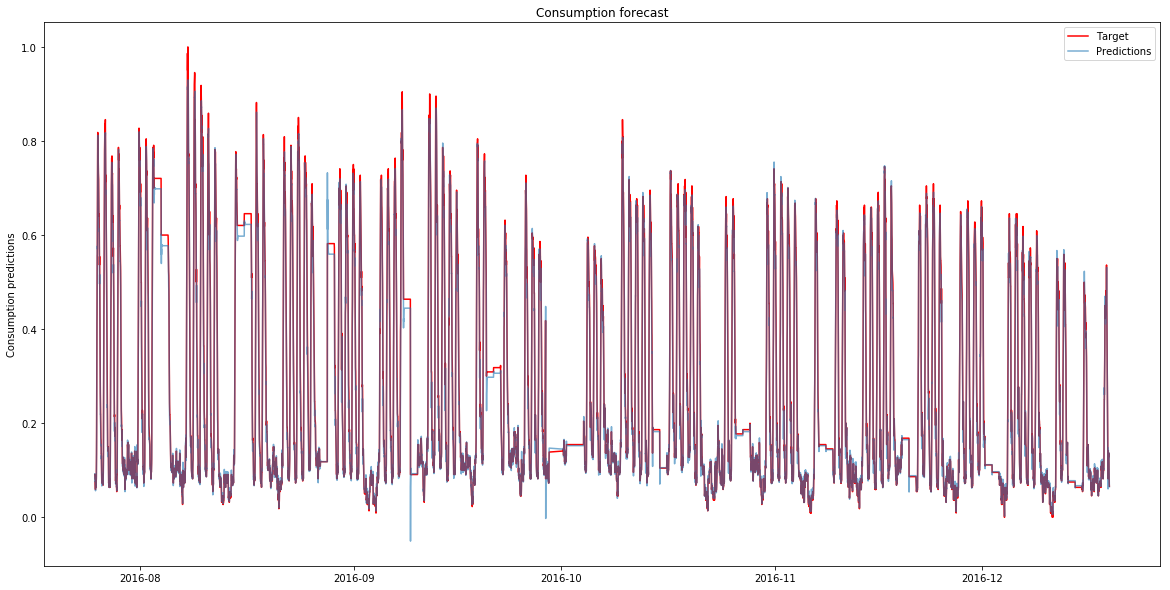

In [7]:
#Load the trained model
lstm = load_model('trained_models/lstm_simple.h5')

#Make predictions on the test set
preds = lstm.predict(X_test)
predictions = scaler.inverse_transform(preds)

#Get the score of the predictions on the test set
print("Score of the predictions on test set: {}".format(mean_squared_error(y_test, preds)))

#Plot to compare y_test & predictions
_ = plt.plot(ts_index, y_test, alpha=1, color='red')
_ = plt.plot(ts_index, preds, alpha=0.6)
_ = plt.ylabel('Consumption predictions')
_ = plt.legend(['Target', 'Predictions'])
_ = plt.title('Consumption forecast')
plt.show()

In [66]:
#Function to make predictions for futur

def forecast_futur(n_preds, lookback=50):
    """Function that creates a moving window in oder to predict for futur values of the target"""

    #get the last known value of the target
    X_last = X_test[-1, :, :].reshape(1, lookback-1, 1)
    #print(X_last.shape, X_last)
    
    preds_futur = np.empty(n_preds)
    
    #Moving window for the futur forecast
    for n in range(n_preds):
        #Predict the 1st new futur value
        pred = lstm.predict(X_last)
        #Add the prediciton to the predictions array
        preds_futur[n] = pred[0]
        pred = pred.reshape(1,1,1)
        #Remove 1st value in input array and append with the prediction obtained
        X_last = X_last[:, 1:]
        X_last = np.concatenate ([X_last, pred], axis=1)
    
    #Scale inverse the predictions
    predictions_futur = scaler.inverse_transform(preds_futur.reshape(-1,1))
    print(predictions_futur.shape)
        
    return predictions_futur

In [ ]:
%%time

#Forecast unknown data: from 20-12-2016 to 2017
n_preds = 2000
predictions_futur = forecast_futur(n_preds)
predictions_futur = predictions_futur.reshape(n_preds)

#Create the datetime index for the futur predictions
index_last = ts_index[-1]
print(index_last)
index_forecast = pd.DatetimeIndex(start=index_last, freq=('15T'), periods=n_preds)
print(type(index_forecast))

#Plot the forecast for the futur
_ = plt.plot(index_forecast, predictions_futur, color='red')
_ = plt.plot(ts_index, scaler.inverse_transform(y_test), color='blue')
_ = plt.ylabel('Value forecast for the energy consumption for futur values (no target)')
_ = plt.legend(['Forecast', 'Past Values'])
plt.savefig('forecast/Building6_LSTM.png')
plt.show()